# Connect Forest Management Model with Forest Carbon Budget Model

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
import pickle
import libcbm
import os
from util_opt import compile_events, cbm_report, compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_emissionstock, run_scenario, plugin_c_curves, cbm_report_both, compare_ws3_cbm, compare_ws3_cbm_both, track_system_stock, track_system_emission, compile_scenario_minemission, plot_scenario_minemission, kpi_age, kpi_species, cmp_c_ss, cmp_c_se, results_scenarios, bootstrap_ogi, compare_kpi_age

In [2]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'
max_harvest = 1.0

In [3]:
# Define scenario options based on case study
scenario_options = {
    'redchris': ['no_cons','evenflow_cons', 'redchrs_AAC_90%', 'redchrs_AAC_80%', 'redchrs_AAC_70%', 'redchrs_AAC_60%', 'redchrs_AAC_50%', 'redchrs_AAC_40%', 'redchrs_AAC_30%', 'redchrs_AAC_20%', 'redchrs_AAC_10%' ],
    'goldenbear': ['no_cons', 'evenflow_cons', 'gldbr_AAC_90%', 'gldbr_AAC_80%', 'gldbr_AAC_70%', 'gldbr_AAC_60%', 'gldbr_AAC_50%', 'gldbr_AAC_40%', 'gldbr_AAC_30%', 'gldbr_AAC_20%', 'gldbr_AAC_10%'],
    'equitysilver': [ 'no_cons','evenflow_cons', 'eqtslvr_AAC_90%', 'eqtslvr_AAC_80%', 'eqtslvr_AAC_70%', 'eqtslvr_AAC_60%', 'eqtslvr_AAC_50%', 'eqtslvr_AAC_40%', 'eqtslvr_AAC_30%', 'eqtslvr_AAC_20%', 'eqtslvr_AAC_10%'],
    'test': ['no_cons', 'evenflow_cons', 'bau_redchrs']
}

# Function to handle case study selection and update scenario dropdown
def select_case_study(case_study):
    print(f"Selected case study: {case_study}")
    # Update the scenario dropdown based on the selected case study
    scenario_dropdown.options = scenario_options.get(case_study, [])
    scenario_dropdown.value = scenario_options[case_study][0]  # Set a default value

# Case study dropdown
case_study_dropdown = widgets.Dropdown(
    options=['redchris', 'goldenbear', 'equitysilver', 'test'],
    value='goldenbear',
    description='Case Study:'
)
case_study_dropdown.observe(lambda change: select_case_study(change['new']), names='value')
display(case_study_dropdown)

# Function to handle scenario selection
def select_scenario(scenario_name):
    print(f"Selected scenario: {scenario_name}")

# Scenario dropdown
scenario_dropdown = widgets.Dropdown(
    options=scenario_options['redchris'],  # Set initial options based on default case study
    value=scenario_options['redchris'][1],  # Set initial value
    description='Scenario:'
)
scenario_dropdown.observe(lambda change: select_scenario(change['new']), names='value')
display(scenario_dropdown)

# Function to handle objective functon
def select_obj(obj_mode):
    print(f"Selected objective: {obj_mode}")
obj_dropdown = widgets.Dropdown(
    options=['max_hv', 'min_ha', 'max_st', 'min_em'],
    value='min_em',
    description='Objective:'
)
display(obj_dropdown)
obj_dropdown.observe(lambda change: select_obj(change['new']), names='value')

Dropdown(description='Case Study:', index=1, options=('redchris', 'goldenbear', 'equitysilver', 'test'), value…

Dropdown(description='Scenario:', index=1, options=('no_cons', 'evenflow_cons', 'redchrs_AAC_90%', 'redchrs_AA…

Dropdown(description='Objective:', index=3, options=('max_hv', 'min_ha', 'max_st', 'min_em'), value='min_em')

In [4]:
# Initialize main widget components 
hwp_pool_effect = widgets.FloatSlider(min=0, max=1, step=1, description='HWP_effect', value=1, layout=widgets.Layout(margin='10px 0'))
release_immediately = widgets.FloatSlider(min=0, max=1, step=1, description='Release immediately', value=1, layout=widgets.Layout(margin='10px 0'))
displacement_effect = widgets.FloatSlider(min=0, max=1, step=1, description='Displacement', value=1, layout=widgets.Layout(margin='10px 0'))
clt_percentage = widgets.FloatSlider(min=0, max=1, step=0.1, description='CLT_percent:', value=0.5, layout=widgets.Layout(margin='10px 0'))
credibility = widgets.FloatSlider(min=0, max=1, step=0.1, description='Credibility:', value=1, layout=widgets.Layout(margin='10px 0'))
# max_harvest = widgets.FloatSlider(min=0, max=1, step=0.05, description='Max_harvest:', value=1.0, layout=widgets.Layout(margin='10px 0'))
budget_input = widgets.FloatText(value=10000000, description='Budget:', layout=widgets.Layout(margin='10px 0'))

release_immediately.layout.display = 'none' if hwp_pool_effect.value != 0 else 'block'
displacement_effect.layout.display = 'block' if hwp_pool_effect.value != 0 else 'none'
clt_percentage.layout.display = 'block' if hwp_pool_effect.value != 0 and displacement_effect.value != 0 else 'none'
credibility.layout.display = 'block' if hwp_pool_effect.value != 0 and displacement_effect.value != 0 else 'none'

container = widgets.VBox([
    hwp_pool_effect, release_immediately, displacement_effect, clt_percentage, credibility, budget_input  
    # ,max_harvest
])

display(container)

def update_widgets(change):
    hwp_pool_effect_value = hwp_pool_effect.value
    displacement_effect_value = displacement_effect.value

    release_immediately.layout.display = 'block' if hwp_pool_effect_value == 0 else 'none'
    displacement_effect.layout.display = 'block' if hwp_pool_effect_value != 0 else 'none'

    clt_percentage.layout.display = 'block' if hwp_pool_effect_value != 0 and displacement_effect_value != 0 else 'none'
    credibility.layout.display = 'block' if hwp_pool_effect_value != 0 and displacement_effect_value != 0 else 'none'

hwp_pool_effect.observe(update_widgets, names='value')
displacement_effect.observe(update_widgets, names='value')

In [5]:
#Start Calculating the Running Time
Start = time.time()

In [6]:
case_study = case_study_dropdown.value
scenario_name = scenario_dropdown.value
obj_mode = obj_dropdown.value
hwp_pool_effect_value = hwp_pool_effect.value
release_immediately_value = release_immediately.value if hwp_pool_effect_value == 0 else 0
displacement_effect = displacement_effect.value if hwp_pool_effect_value != 0 else 0
clt_percentage = clt_percentage.value if displacement_effect != 0 else 0
credibility = credibility.value if displacement_effect != 0 else 0
# max_harvest = max_harvest.value
budget_input = budget_input.value

In [7]:
# Define case study mappings and retrieve model details based on case study
case_study_options = {
    'redchris': {
        'model_name': 'redchris',
        'model_path': './data/woodstock_model_files_redchris'
    },
    'goldenbear': {
        'model_name': 'goldenbear',
        'model_path': './data/woodstock_model_files_goldenbear'
    },
    'equitysilver': {
        'model_name': 'equitysilver',
        'model_path': './data/woodstock_model_files_equitysilver'
    },
    'test': {
        'model_name': 'redchris',
        'model_path': './data/woodstock_model_files_redchris_test'
    }
}

model_info = case_study_options.get(case_study)

if model_info:
    model_name = model_info['model_name']
    model_path = model_info['model_path']
else:
    print('The case study name is not valid')


In [8]:
# Create and Run `ForestModel` instance
fm = ws3.forest.ForestModel(model_name=model_name,
                            model_path=model_path,
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()
fm.grow()

In [9]:
# Flag 'harvest' as a harvesting action in the ws3 model
harvest_acode='harvest'
fm.actions[harvest_acode].is_harvest = True

In [10]:
# Read curves
file_directory = "./inputs/curves"
file_names = [f"{case_study}_c_curves_p.pkl", f"{case_study}_c_curves_f.pkl"]
loaded_data = {}

for filename in file_names:
    file_path = os.path.join(file_directory, filename)
    with open(file_path, 'rb') as file:
        loaded_data[filename] = pickle.load(file)
    print(f"Loaded data from {file_path}")

c_curves_p = loaded_data.get(f"{case_study}_c_curves_p.pkl")
c_curves_f = loaded_data.get(f"{case_study}_c_curves_f.pkl")

Loaded data from ./inputs/curves/goldenbear_c_curves_p.pkl
Loaded data from ./inputs/curves/goldenbear_c_curves_f.pkl


In [11]:
# Plug carbon and old groth yield curves into forest model
plugin_c_curves(fm, c_curves_p, c_curves_f)
bootstrap_ogi(fm)

Running for goldenbear_min_em_no_cons...
running no_cons scenario
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-09
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3905 rows, 36130 columns and 36130 nonzeros
Model fingerprint: 0x18933553
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 3905 rows and 36130 columns
Presolve time: 0.03s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0133786e+07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.03 seconds (0.01 work units)
Optimal objective -5.013378556e+07


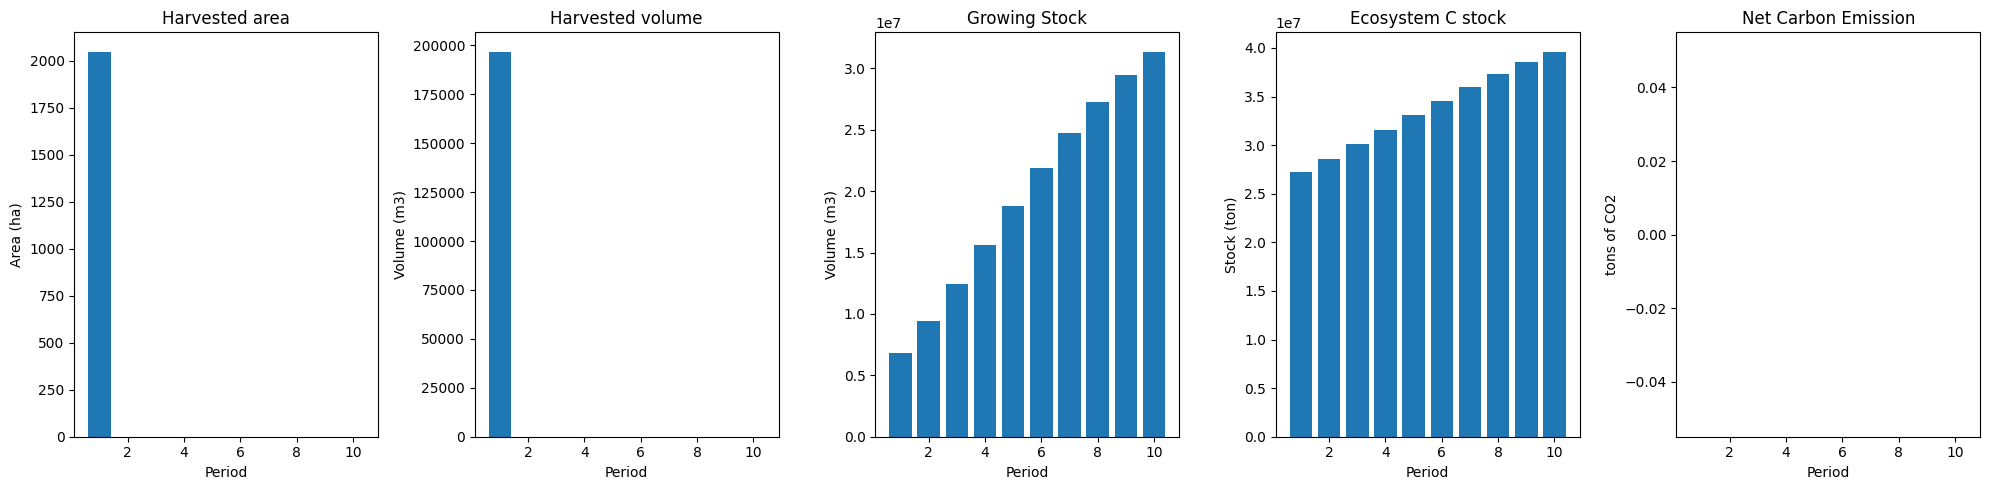

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_no_cons_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  208
The economic indicator (the provincial government revenues) is:  7094
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


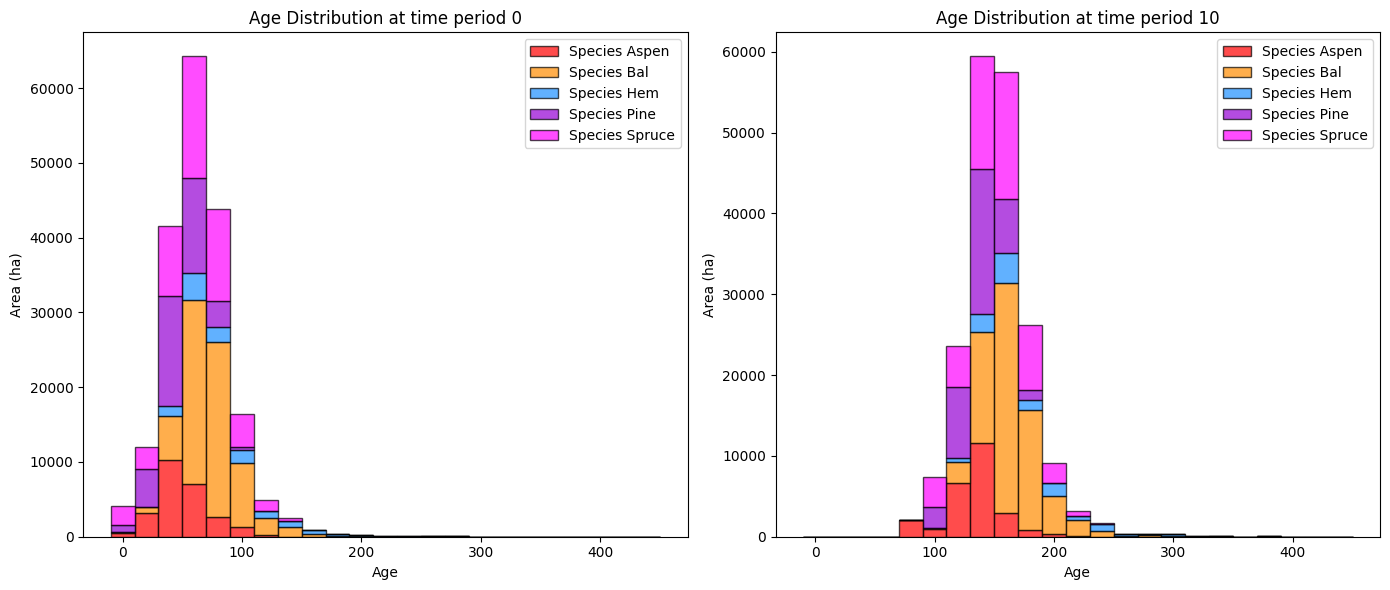

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_no_cons_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   8040.264040   8037.555506
Bal     278.565372  15963.007735  15684.442363
Aspen   273.490478  11264.193215  10990.702737
Pine      0.000000   7631.887200   7631.887200
Hem     419.699331   3929.593538   3509.894208

Old growth has **increased** by 45854.48 hectares from time period 0 to time period 10.


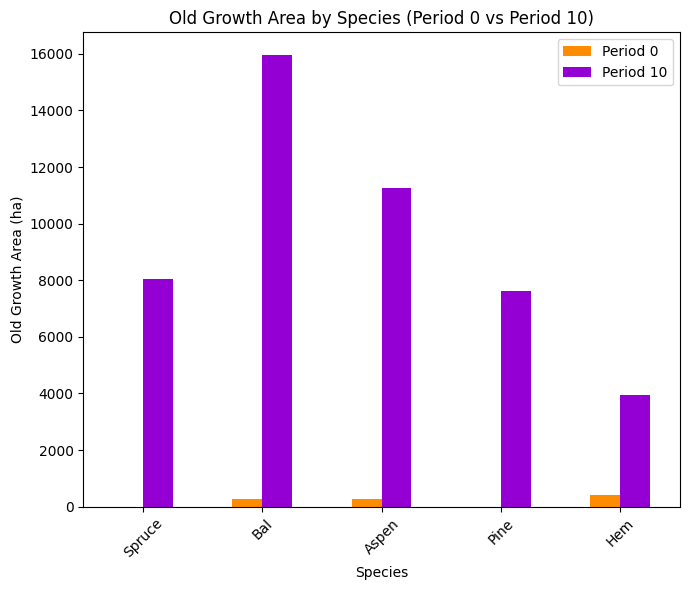

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_no_cons_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.9274

Diversity has **decreased** by 1.82% from time 0 to time 10.


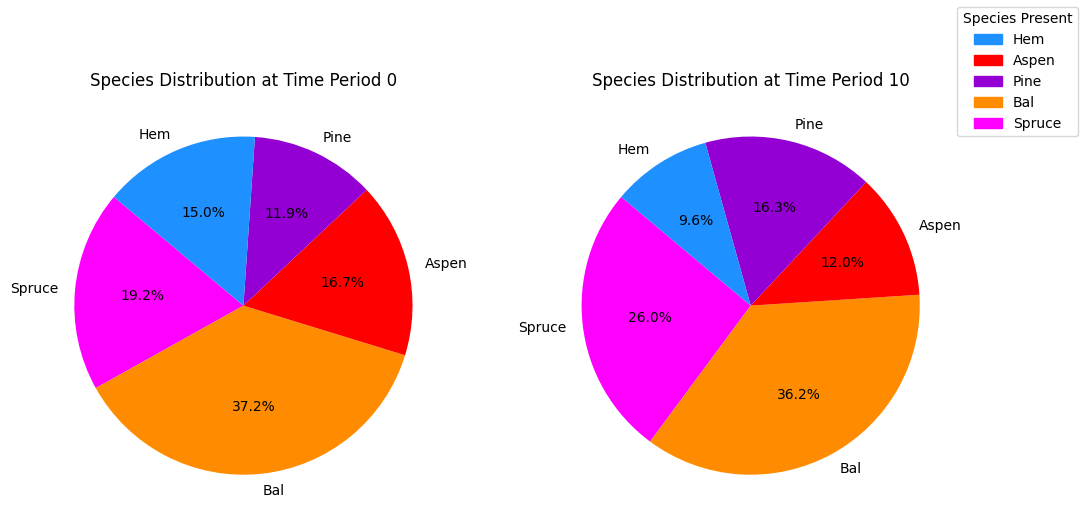

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_em_no_cons_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x14bd878b
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.13s
Presolved: 1911 rows, 34099 columns, 409165 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00

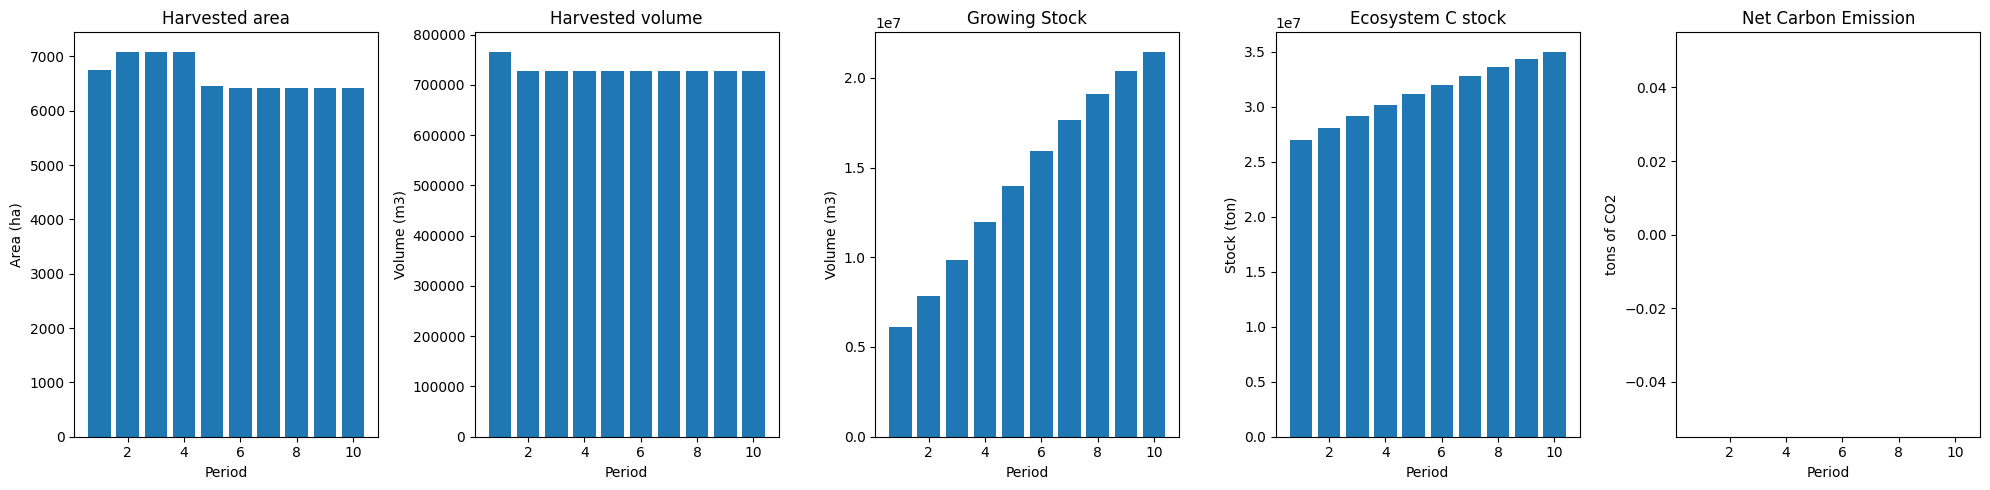

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7734
The economic indicator (the provincial government revenues) is:  263762
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


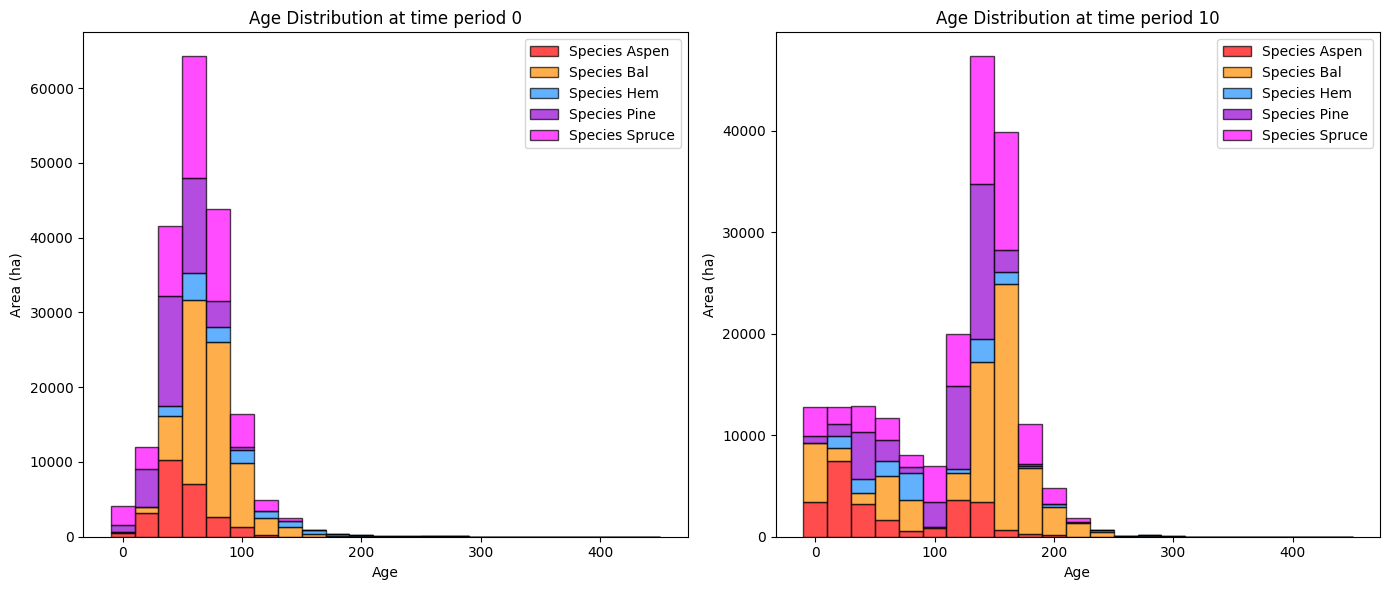

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0           10   Difference
Spruce    2.708533  4178.736448  4176.027915
Bal     278.565372  8822.787379  8544.222007
Aspen   273.490478  2555.924852  2282.434374
Pine      0.000000  3560.331018  3560.331018
Hem     419.699331   708.923341   289.224010

Old growth has **increased** by 18852.24 hectares from time period 0 to time period 10.


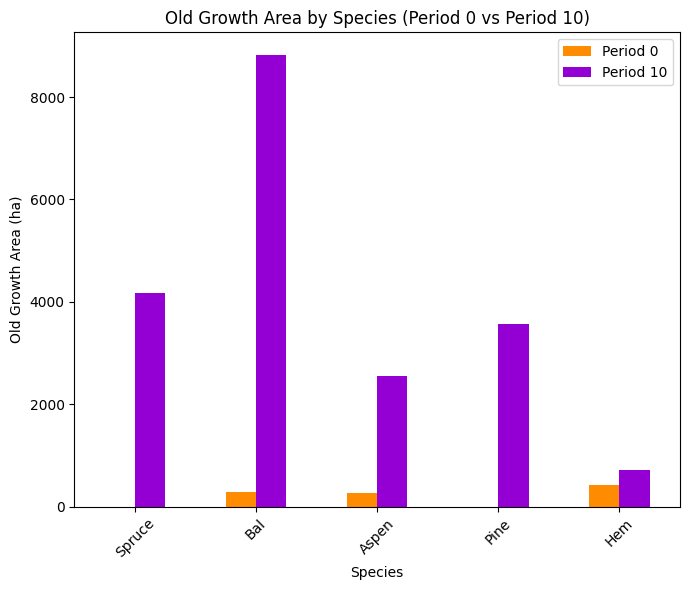

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8666

Diversity has **decreased** by 7.89% from time 0 to time 10.


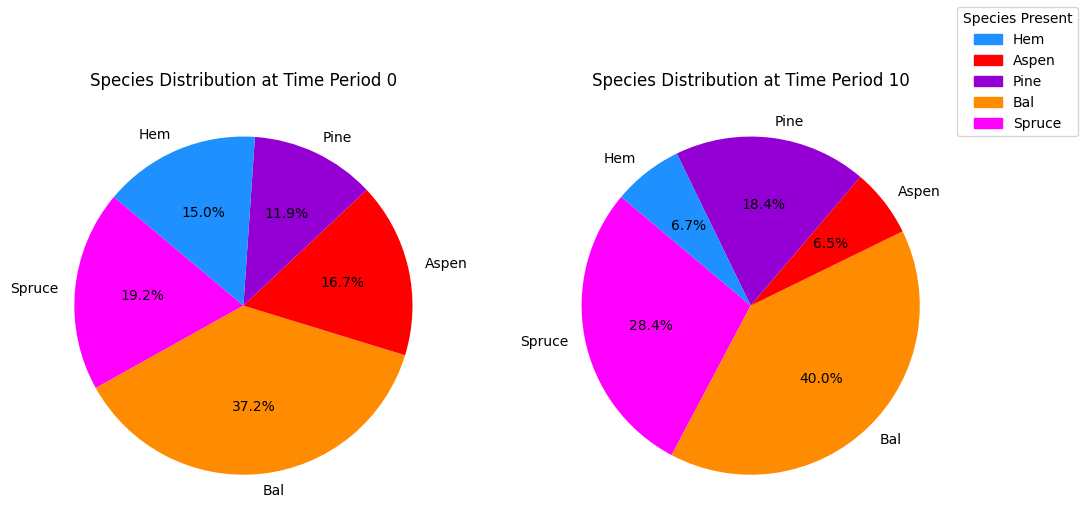

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_species_pie.pdf


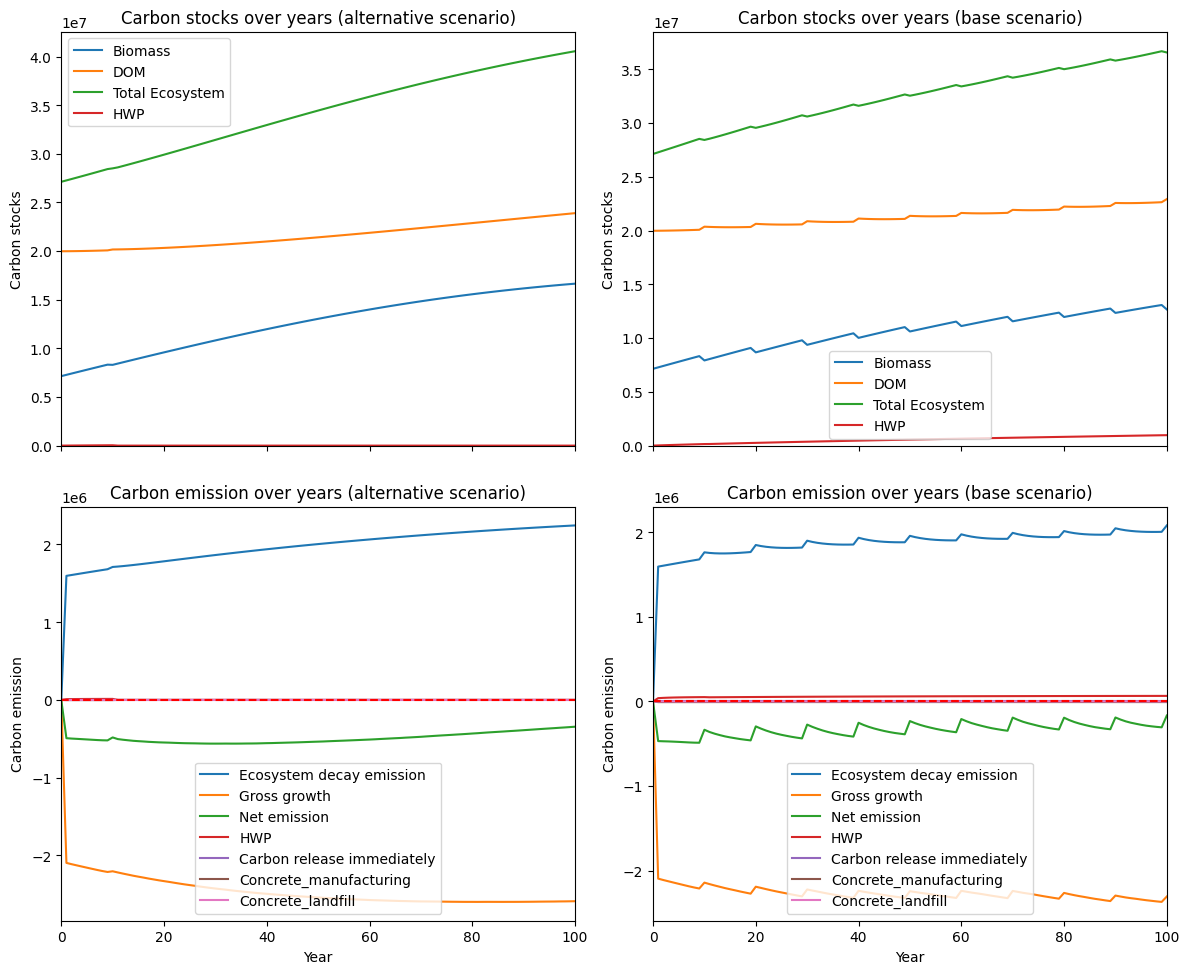

---------------------------------------------------------------------------------------
Net emission difference -15966769.398525765
Net emission base scenario -33380413.402354177
Net emission alternative scenario -49347182.80087994
dollar_per_ton is:  0.62630077195975
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  3861.527592  3861.527592
Bal     0.0  7140.220356  7140.220356
Aspen   0.0  8708.268363  8708.268363
Pine    0.0  4071.556182  4071.556182
Hem     0.0  3220.670198  3220.670198

Overall, the old growth area has **increased** by 27002.24 hectares in the alternative scenario compared to the base scenario.


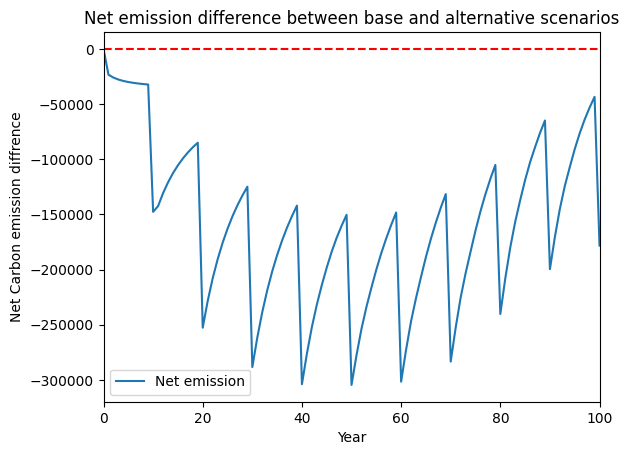

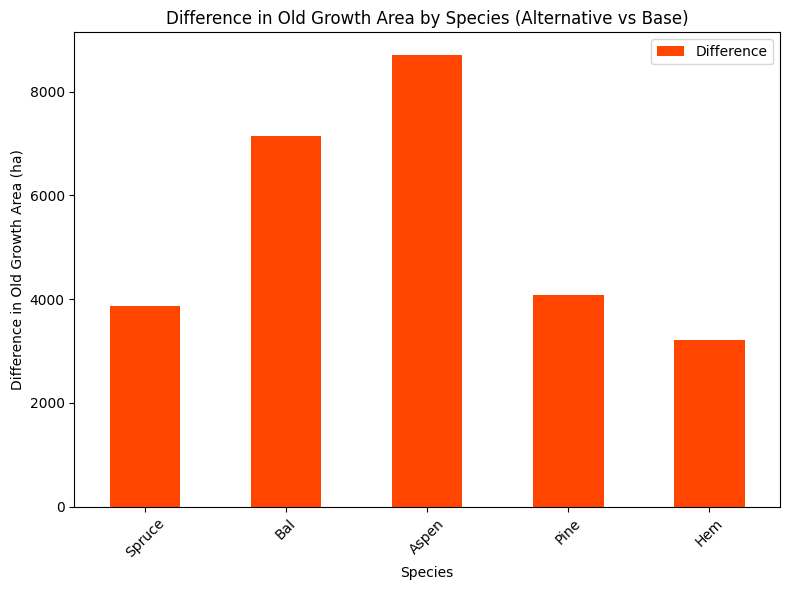

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_kpi_age_difference.pdf


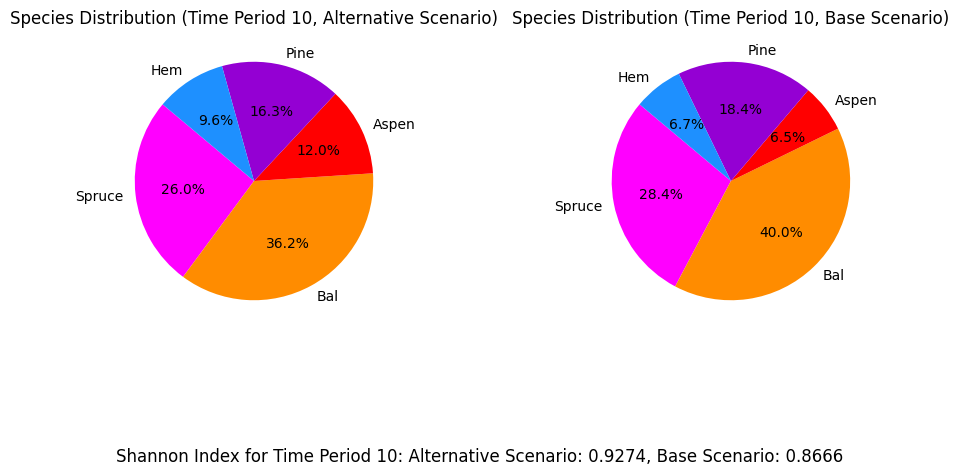

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_em_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_min_em_evenflow_cons...
running even flow constraints scenario
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3945 rows, 36130 columns and 430076 nonzeros
Model fingerprint: 0xa203b387
Coefficient statistics:
  Matrix range     [1e-02, 9e+04]
  Objective range  [2e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 2035 rows and 2031 columns
Presolve time: 0.10s
Presolved: 1910 rows, 34099 columns, 402875 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering ti

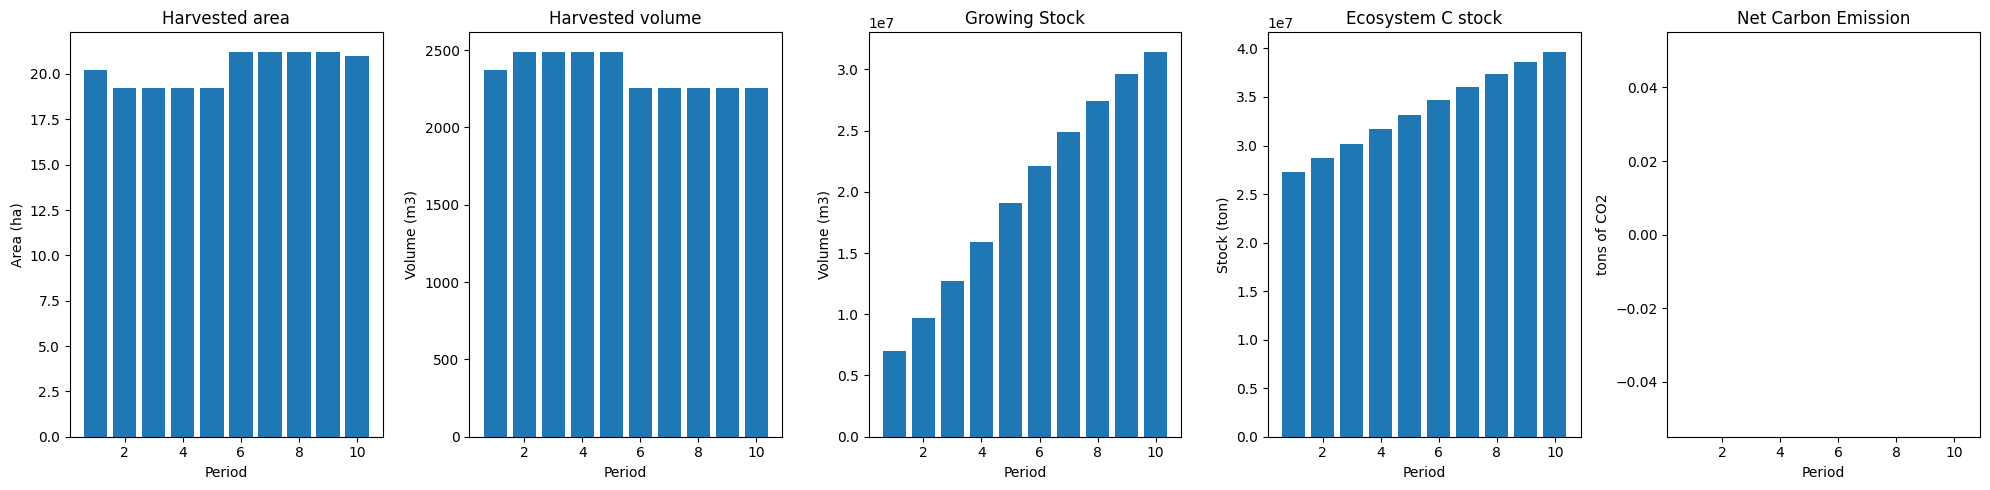

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_evenflow_cons_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  24
The economic indicator (the provincial government revenues) is:  850
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


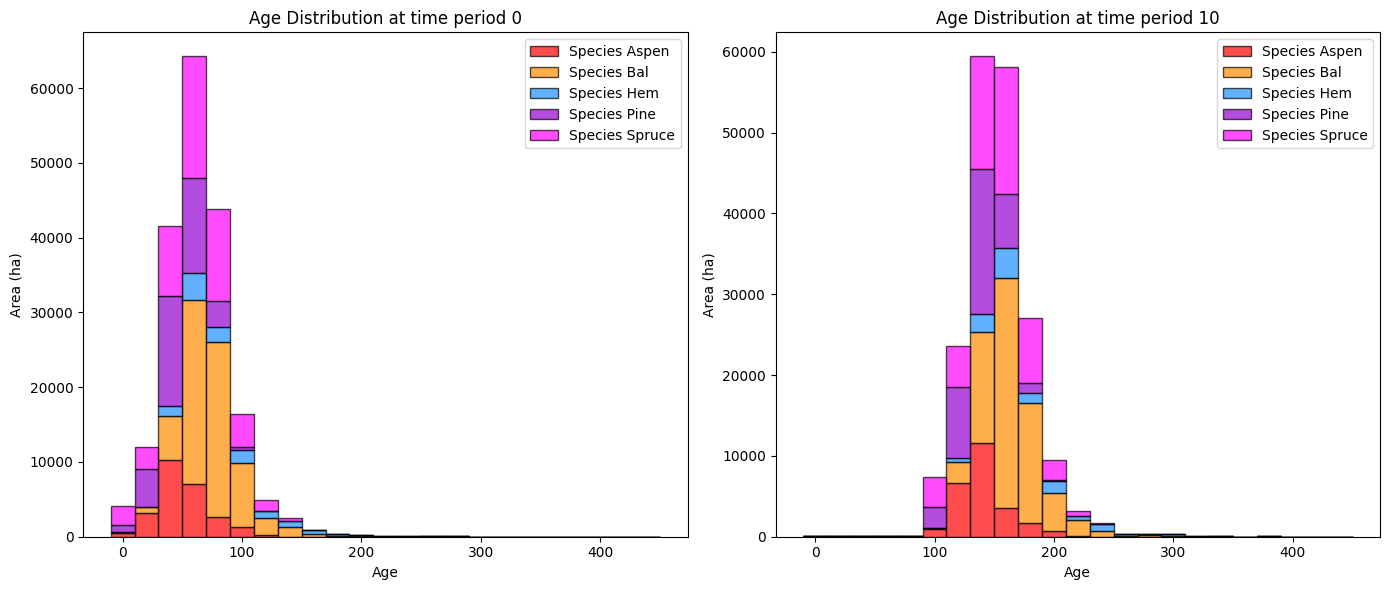

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_evenflow_cons_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   8040.264040   8037.555506
Bal     278.565372  15963.007735  15684.442363
Aspen   273.490478  13002.514422  12729.023944
Pine      0.000000   7631.887200   7631.887200
Hem     419.699331   3929.593538   3509.894208

Old growth has **increased** by 47592.80 hectares from time period 0 to time period 10.


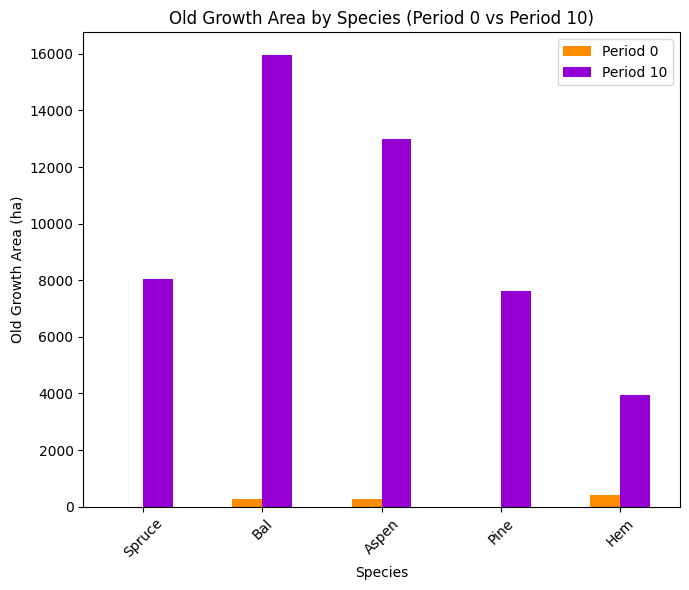

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_evenflow_cons_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.9283

Diversity has **decreased** by 1.73% from time 0 to time 10.


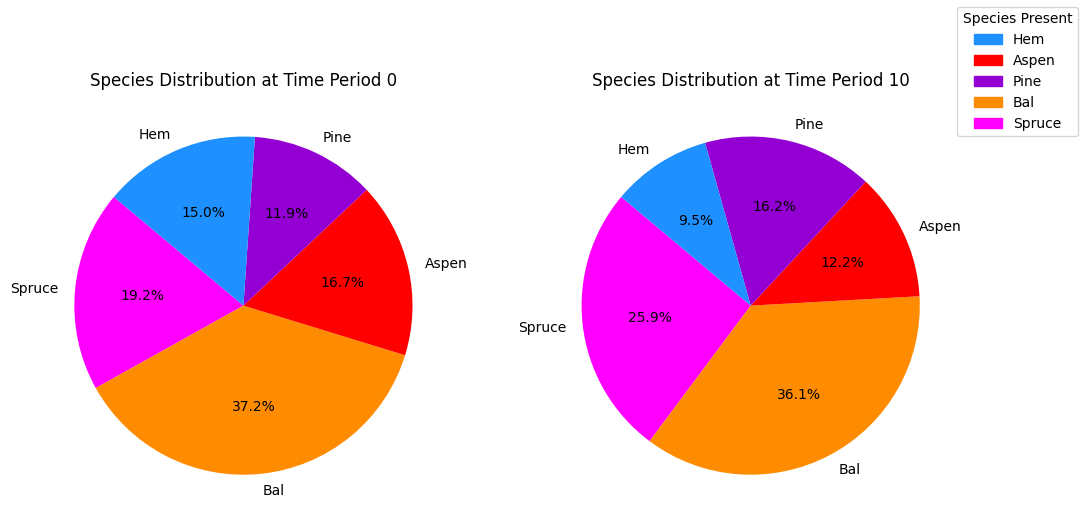

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_em_evenflow_cons_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x14bd878b
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.14s
Presolved: 1911 rows, 34099 columns, 409165 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time

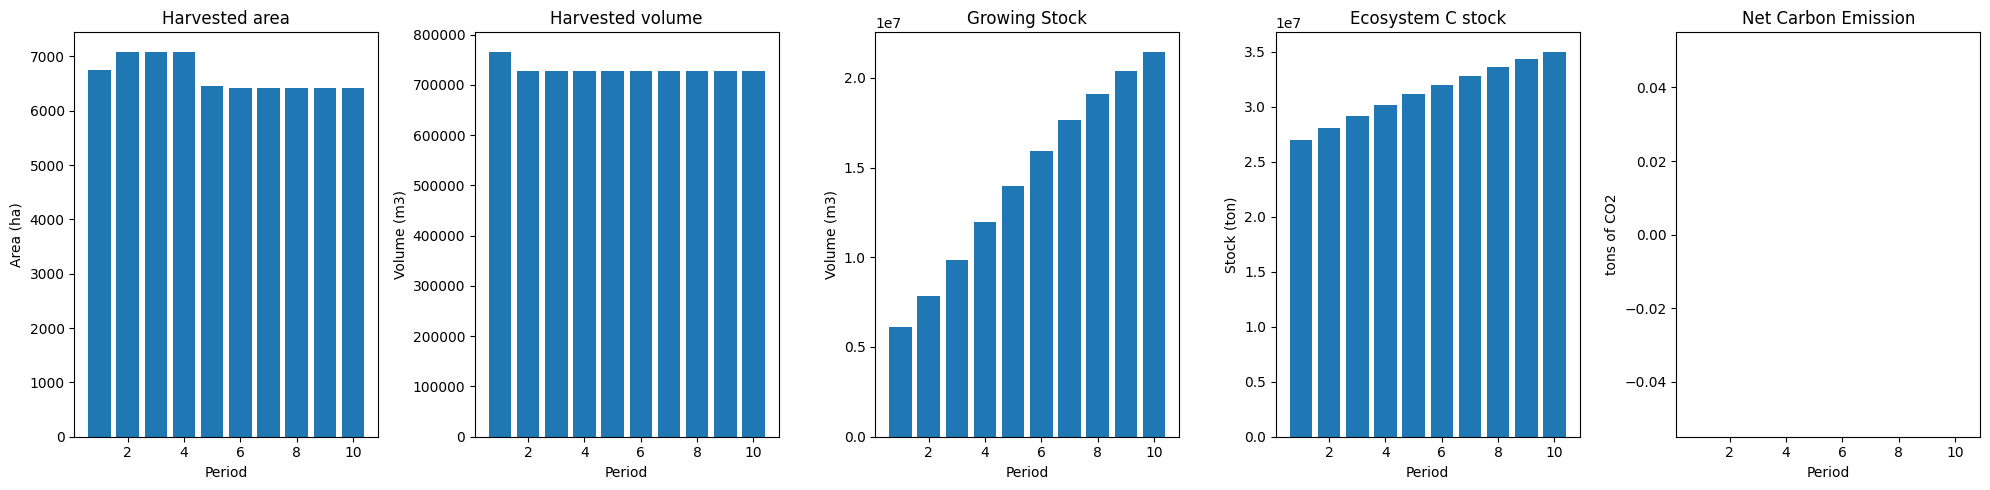

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7734
The economic indicator (the provincial government revenues) is:  263762
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


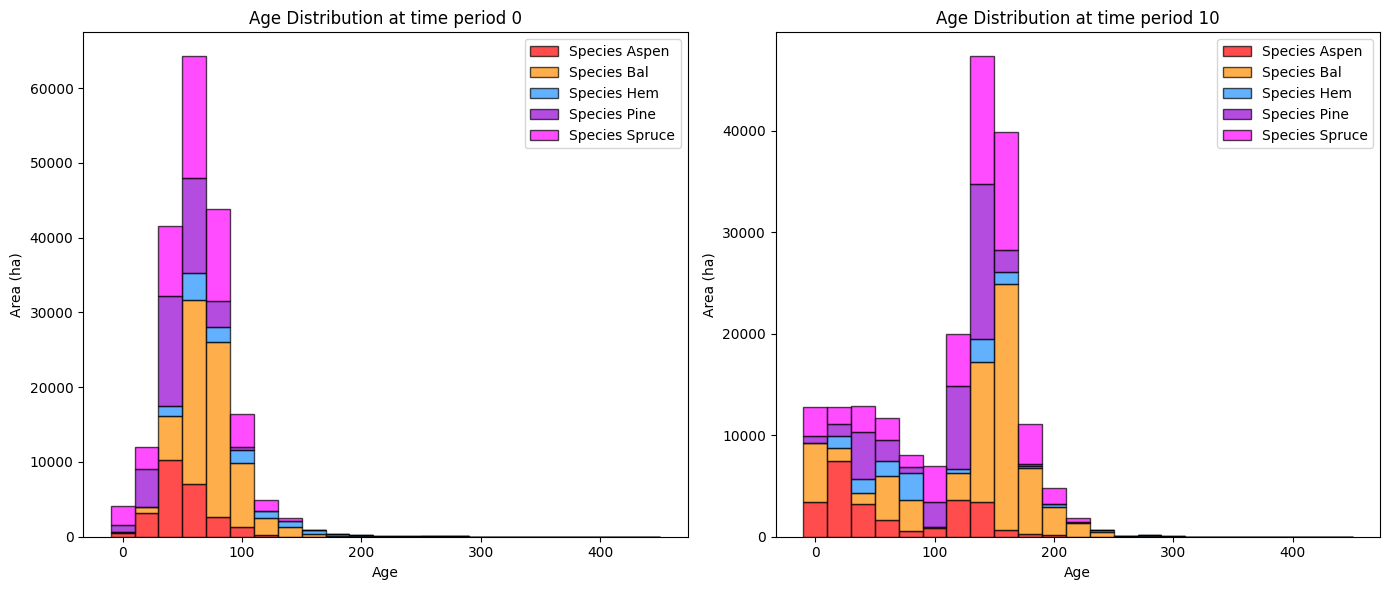

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0           10   Difference
Spruce    2.708533  4178.736448  4176.027915
Bal     278.565372  8822.787379  8544.222007
Aspen   273.490478  2555.924852  2282.434374
Pine      0.000000  3560.331018  3560.331018
Hem     419.699331   708.923341   289.224010

Old growth has **increased** by 18852.24 hectares from time period 0 to time period 10.


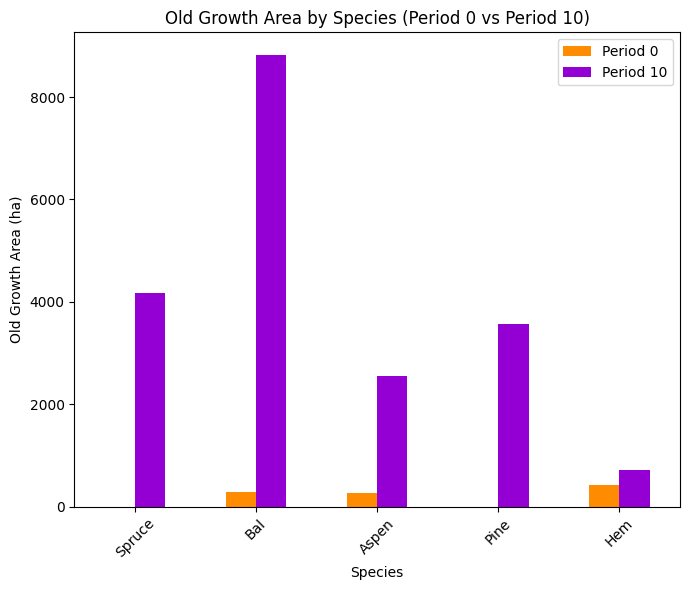

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8666

Diversity has **decreased** by 7.89% from time 0 to time 10.


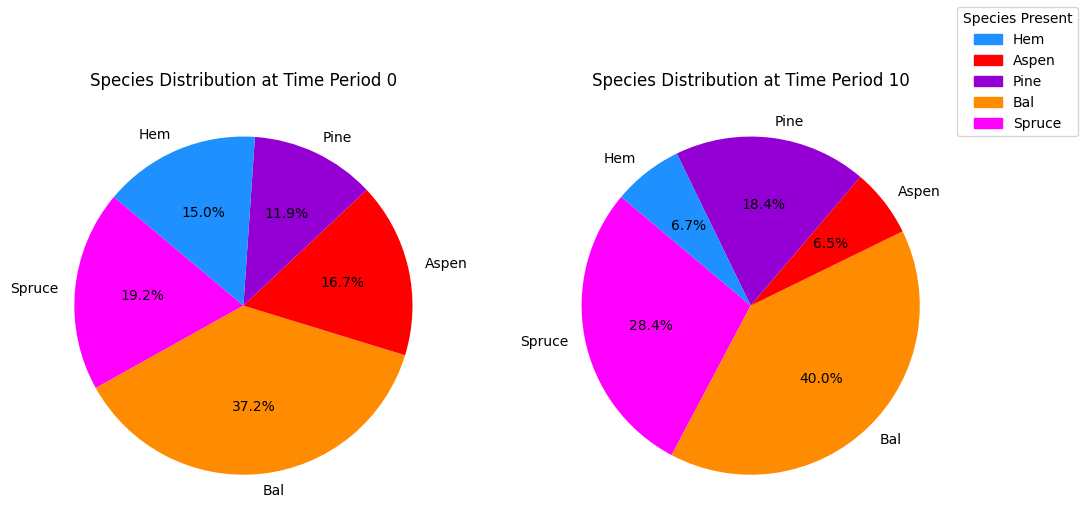

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_species_pie.pdf


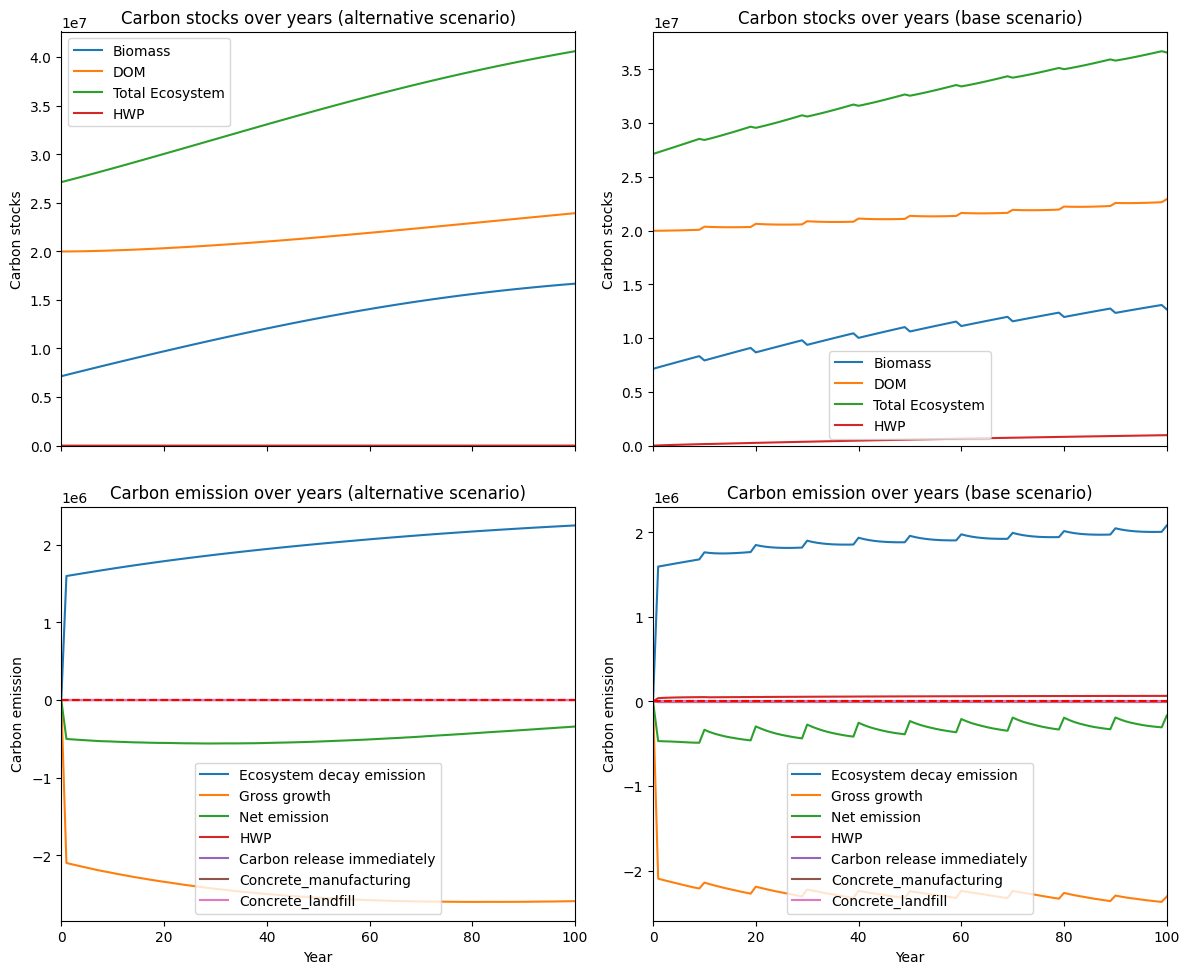

---------------------------------------------------------------------------------------
Net emission difference -16026542.70714933
Net emission base scenario -33380413.402354177
Net emission alternative scenario -49406956.10950351
dollar_per_ton is:  0.6239648926614141
Comparison of Old Growth Areas (Alternative - Base)
          0            10    Difference
Spruce  0.0   3861.527592   3861.527592
Bal     0.0   7140.220356   7140.220356
Aspen   0.0  10446.589569  10446.589569
Pine    0.0   4071.556182   4071.556182
Hem     0.0   3220.670198   3220.670198

Overall, the old growth area has **increased** by 28740.56 hectares in the alternative scenario compared to the base scenario.


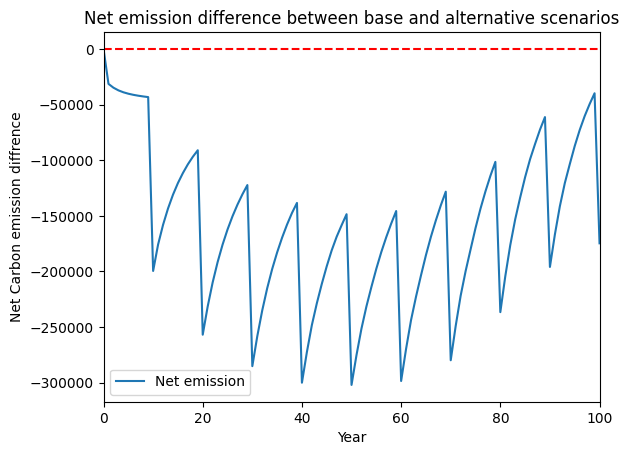

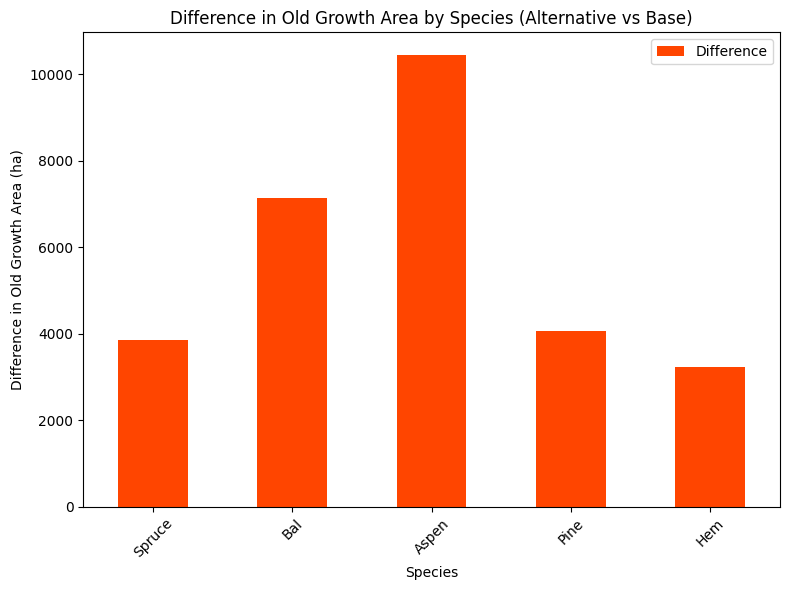

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_kpi_age_difference.pdf


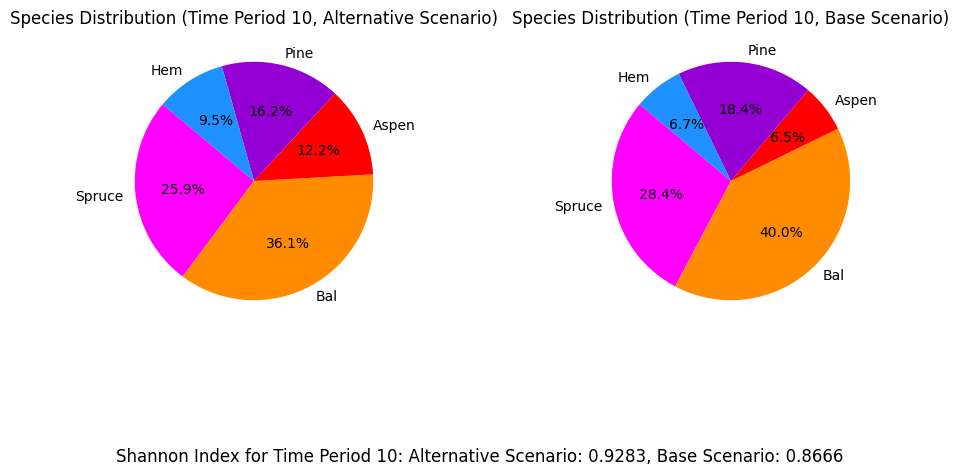

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_em_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_min_em_gldbr_AAC_90%...
running the scenario for the Golden Bear mining site (90%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xbcab9096
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.14s
Presolved: 1911 rows, 34100 

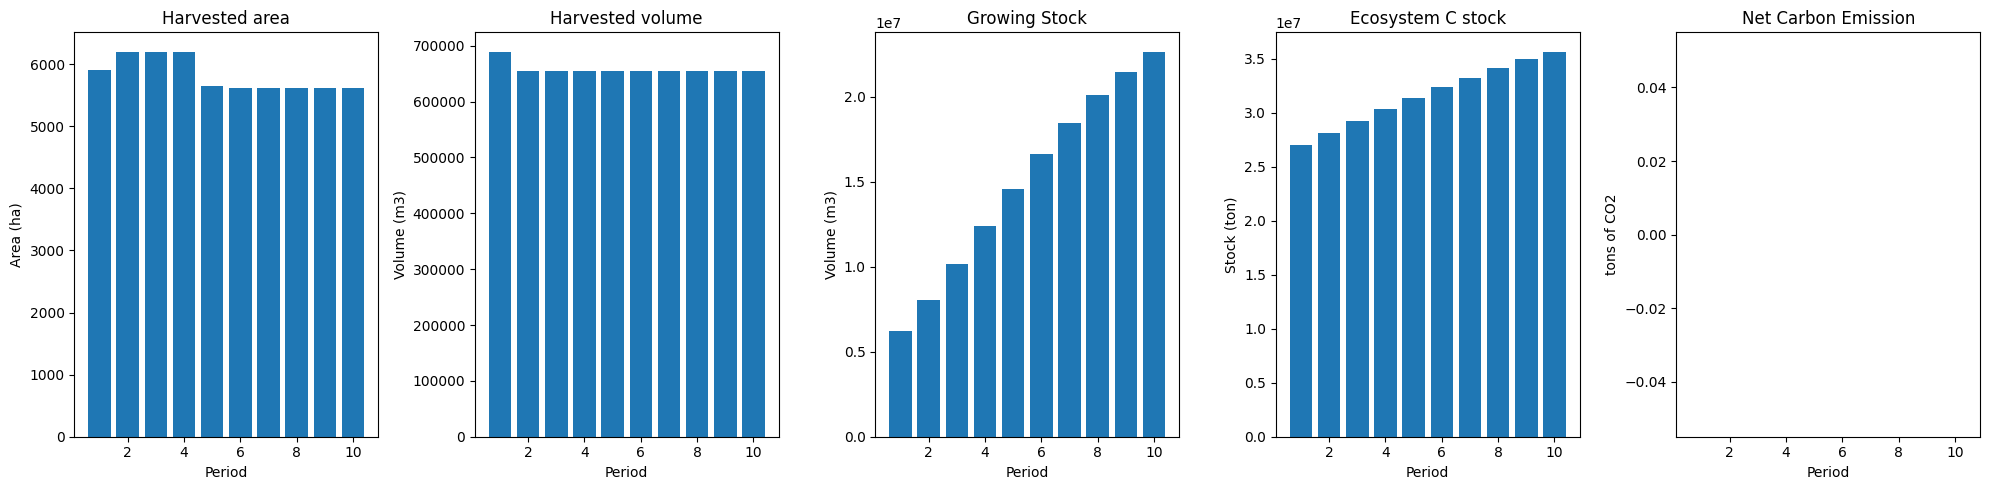

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_90%_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  6961
The economic indicator (the provincial government revenues) is:  237385
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


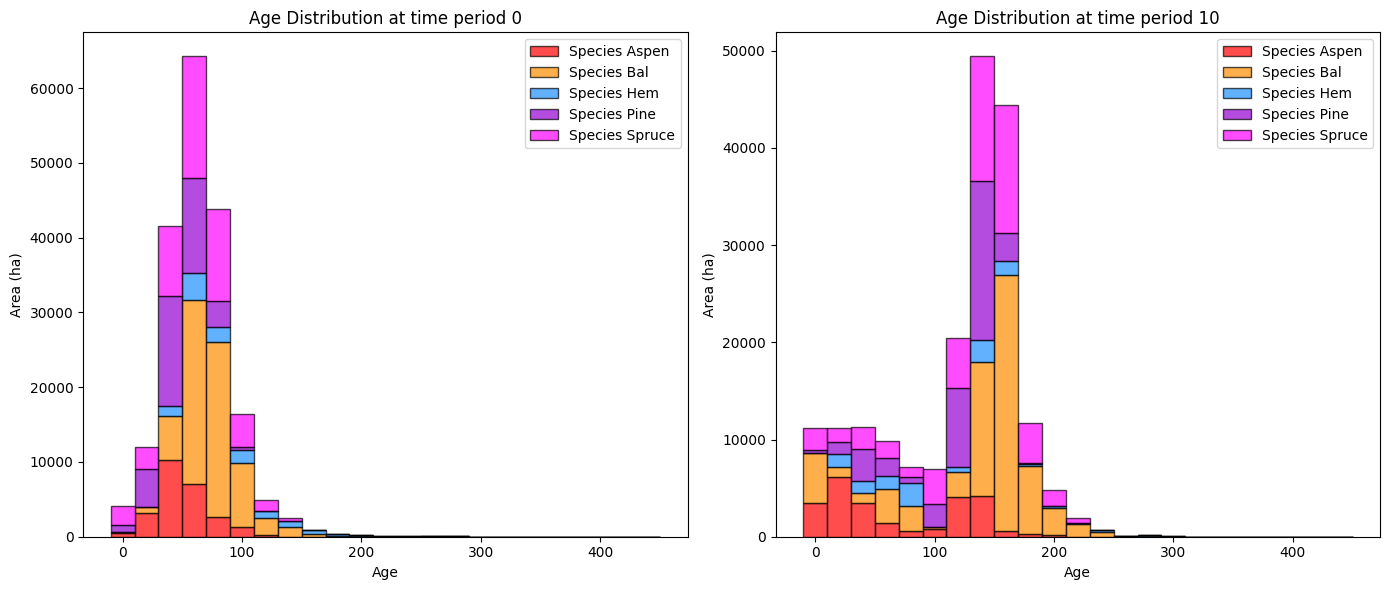

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_90%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0           10   Difference
Spruce    2.708533  4507.231154  4504.522621
Bal     278.565372  9273.746498  8995.181127
Aspen   273.490478  2994.828077  2721.337599
Pine      0.000000  4207.507512  4207.507512
Hem     419.699331   720.957486   301.258155

Old growth has **increased** by 20729.81 hectares from time period 0 to time period 10.


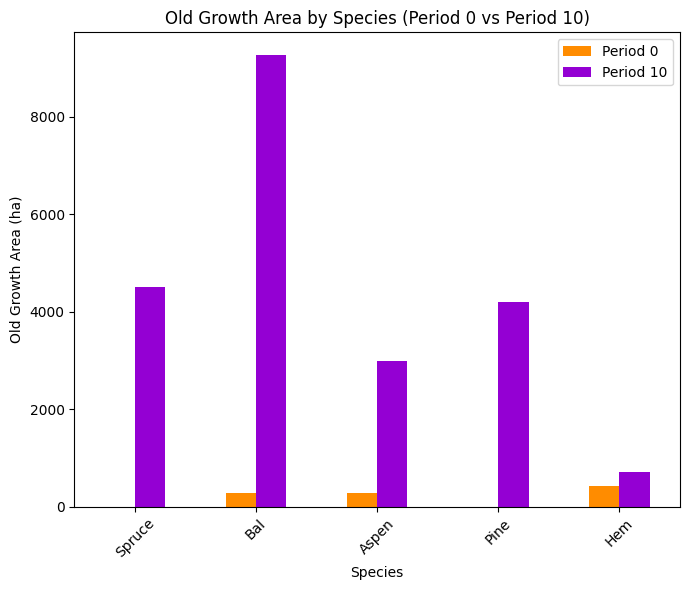

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_90%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8689

Diversity has **decreased** by 7.66% from time 0 to time 10.


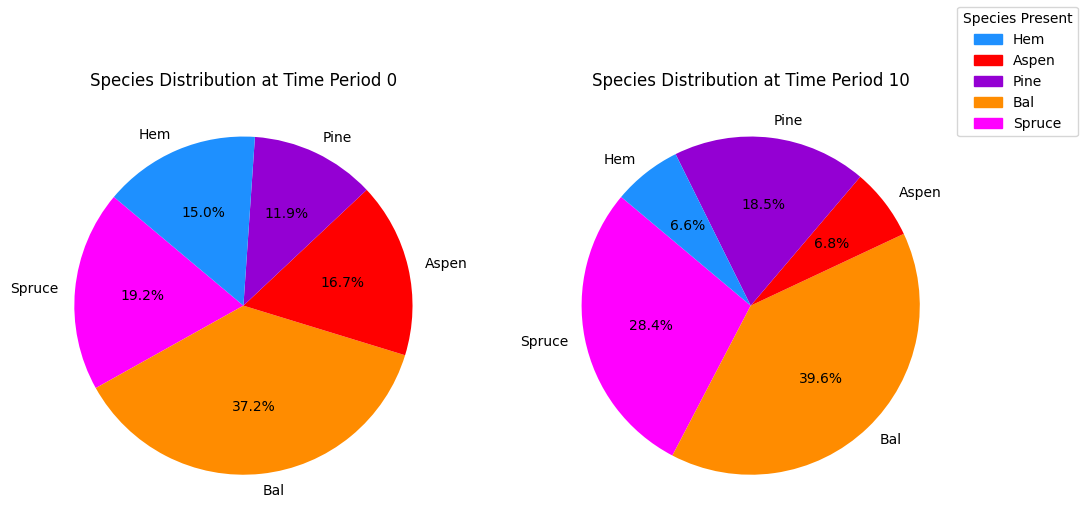

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_90%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x14bd878b
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.14s
Presolved: 1911 rows, 34099 columns, 409165 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time

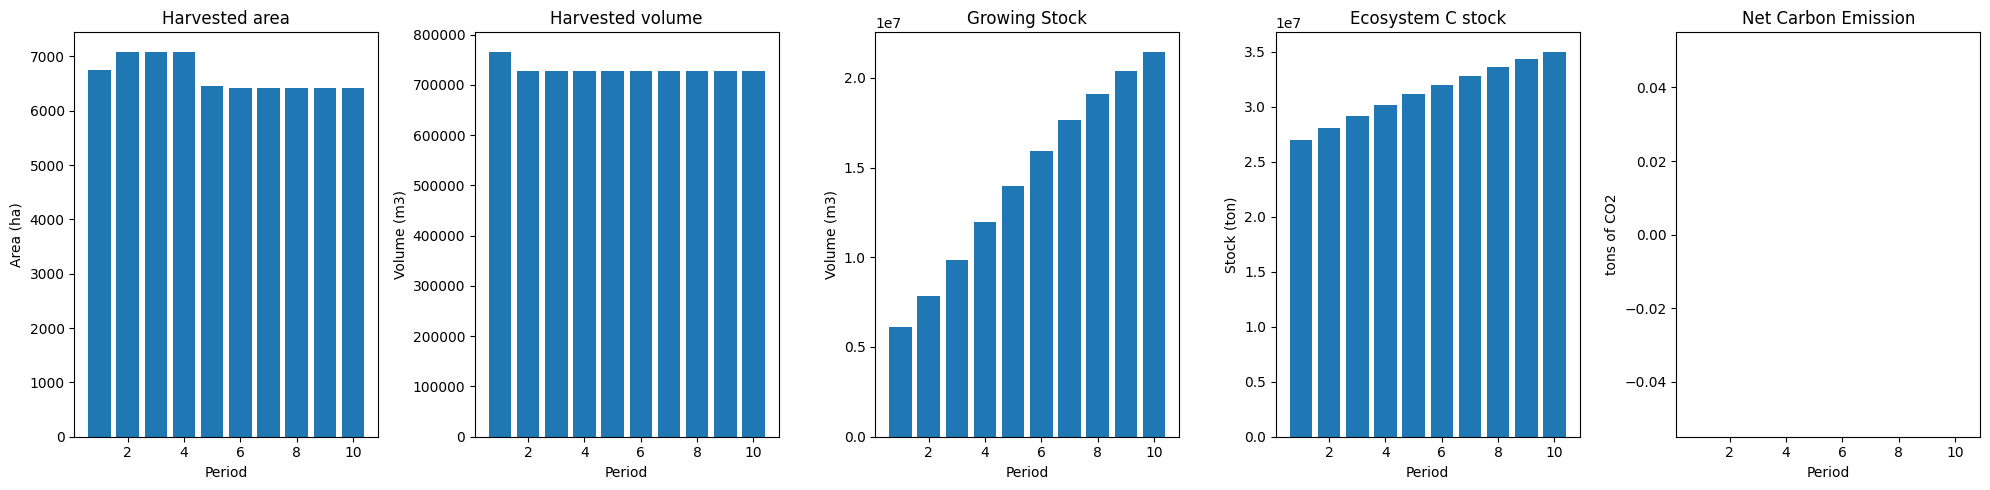

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7734
The economic indicator (the provincial government revenues) is:  263762
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


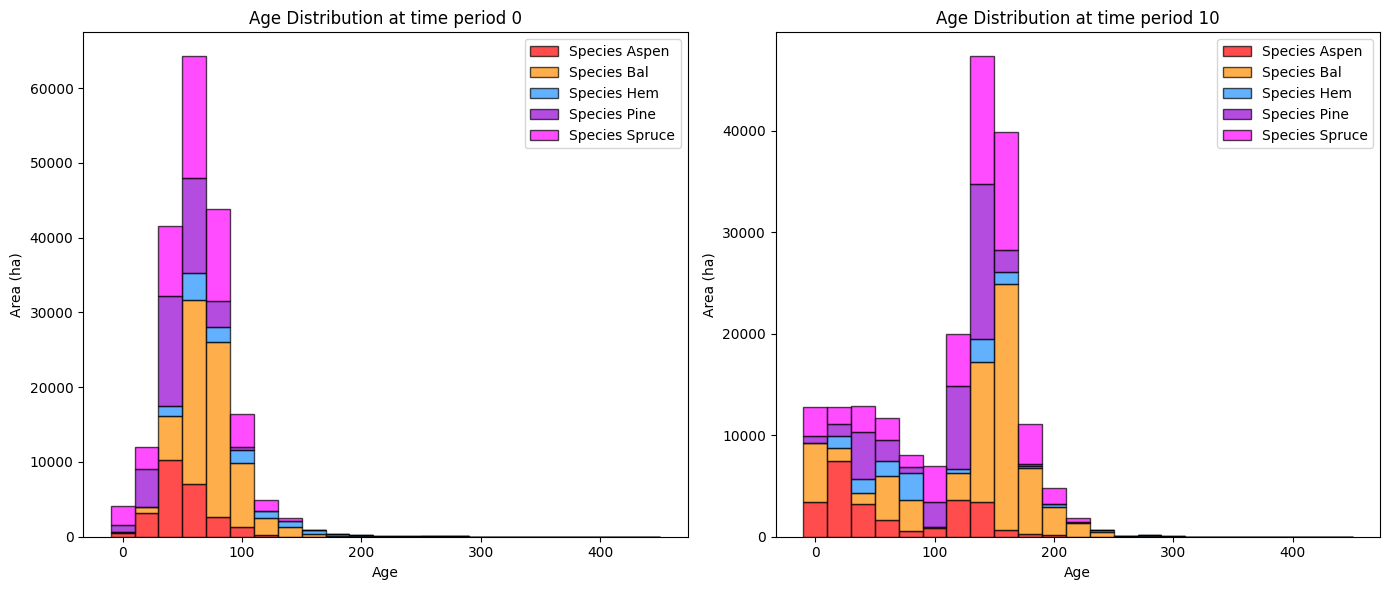

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0           10   Difference
Spruce    2.708533  4178.736448  4176.027915
Bal     278.565372  8822.787379  8544.222007
Aspen   273.490478  2555.924852  2282.434374
Pine      0.000000  3560.331018  3560.331018
Hem     419.699331   708.923341   289.224010

Old growth has **increased** by 18852.24 hectares from time period 0 to time period 10.


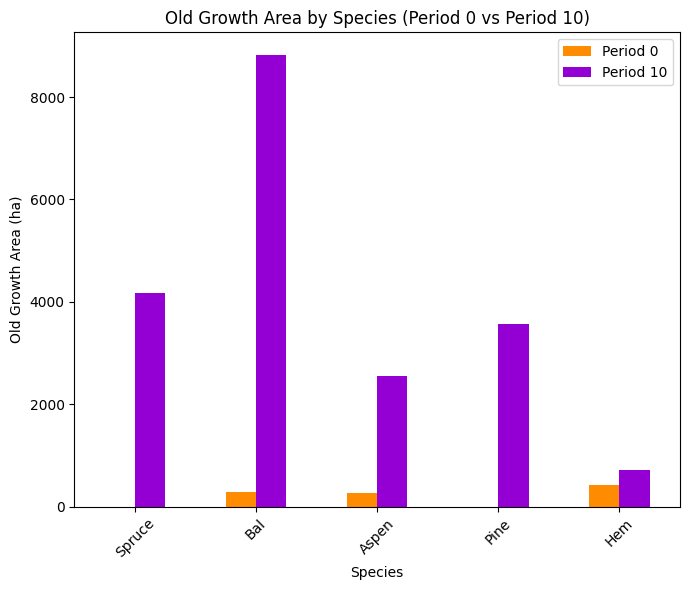

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8666

Diversity has **decreased** by 7.89% from time 0 to time 10.


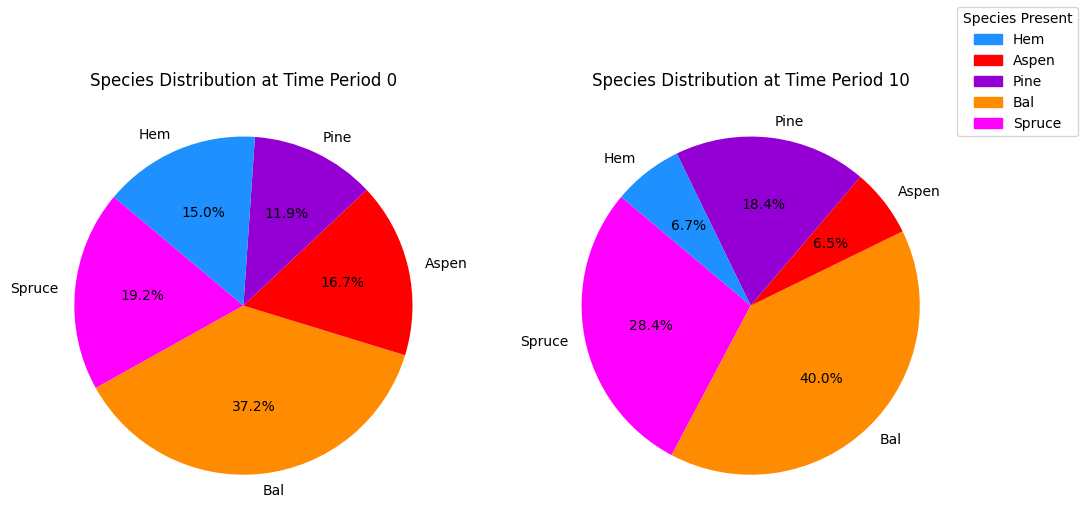

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_species_pie.pdf


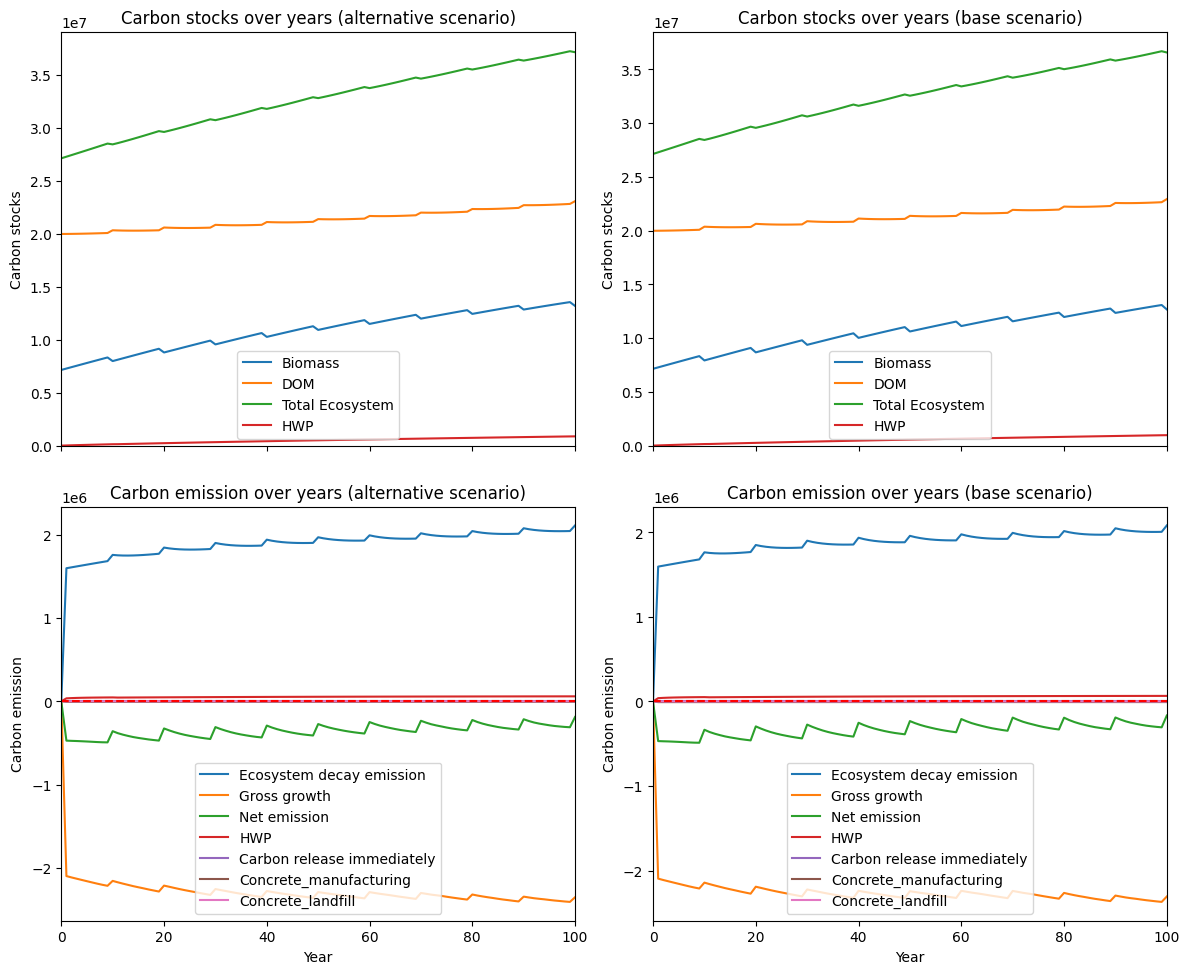

---------------------------------------------------------------------------------------
Net emission difference -2212482.2321349694
Net emission base scenario -33380413.402354177
Net emission alternative scenario -35592895.63448915
dollar_per_ton is:  4.519810308420124
Comparison of Old Growth Areas (Alternative - Base)
          0          10  Difference
Spruce  0.0  328.494706  328.494706
Bal     0.0  450.959119  450.959119
Aspen   0.0  438.903224  438.903224
Pine    0.0  647.176494  647.176494
Hem     0.0   12.034146   12.034146

Overall, the old growth area has **increased** by 1877.57 hectares in the alternative scenario compared to the base scenario.


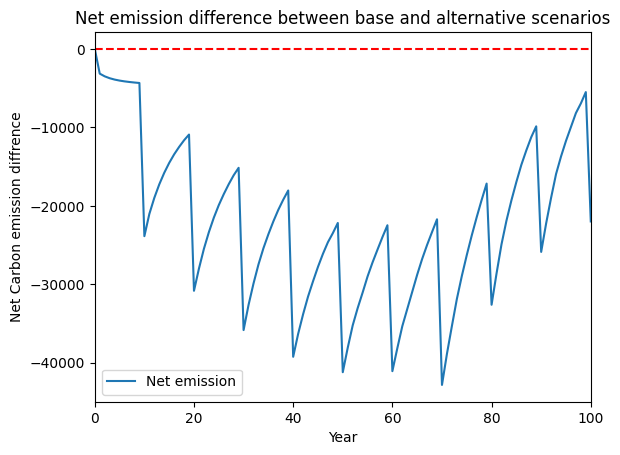

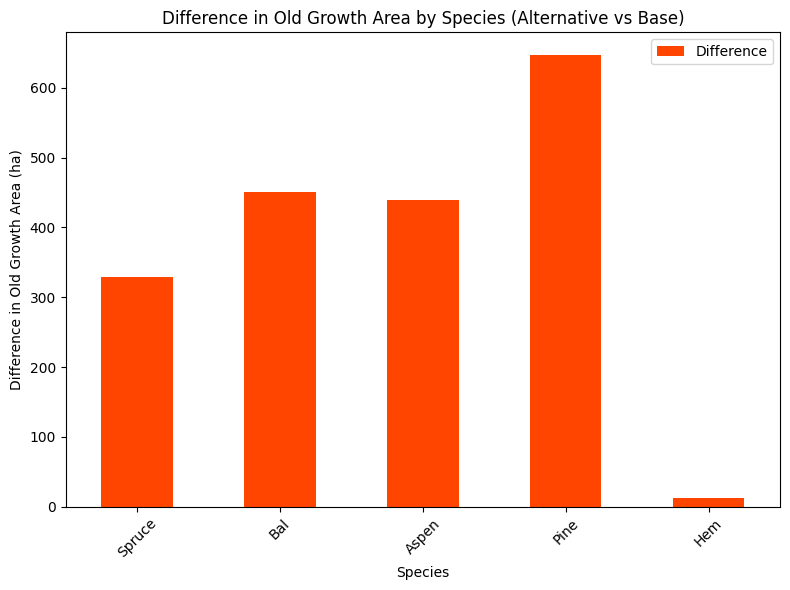

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_kpi_age_difference.pdf


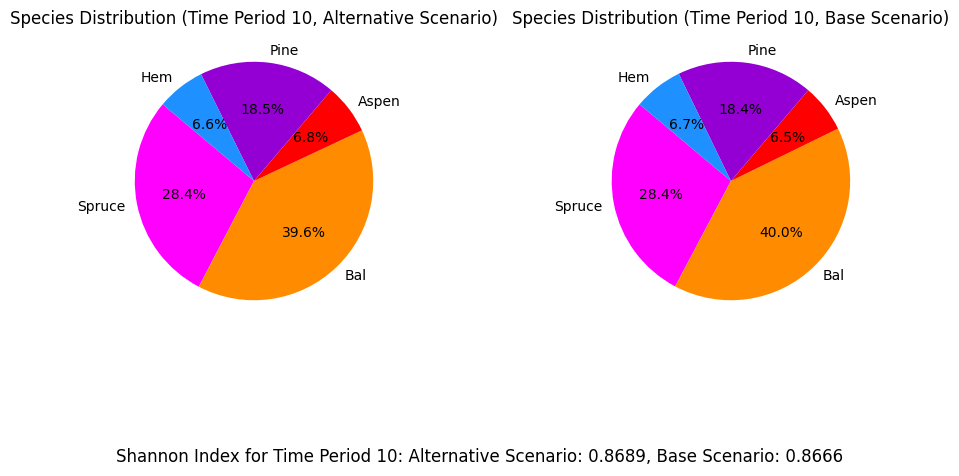

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_em_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_min_em_gldbr_AAC_80%...
running the scenario for the Golden Bear mining site (80%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xd7f2fe57
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.14s
Presolved: 1911 rows, 34100 

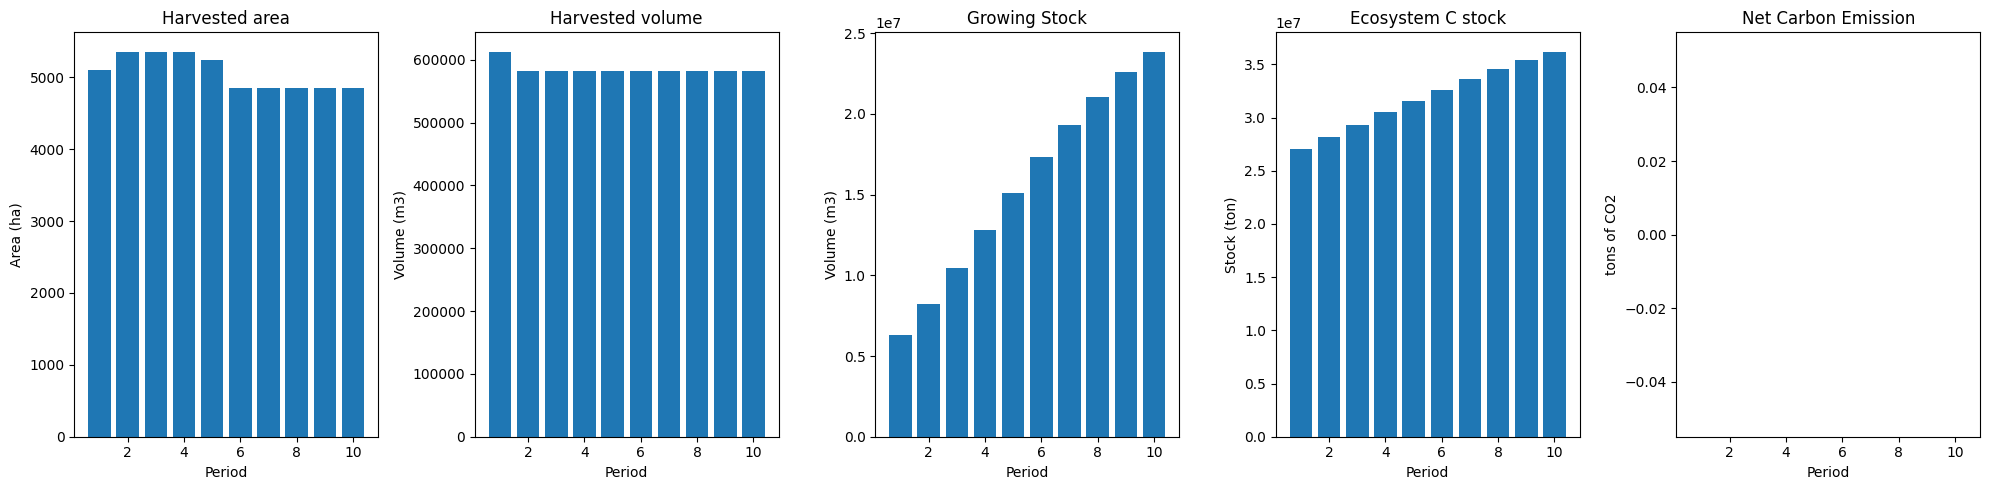

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_80%_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  6187
The economic indicator (the provincial government revenues) is:  211009
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


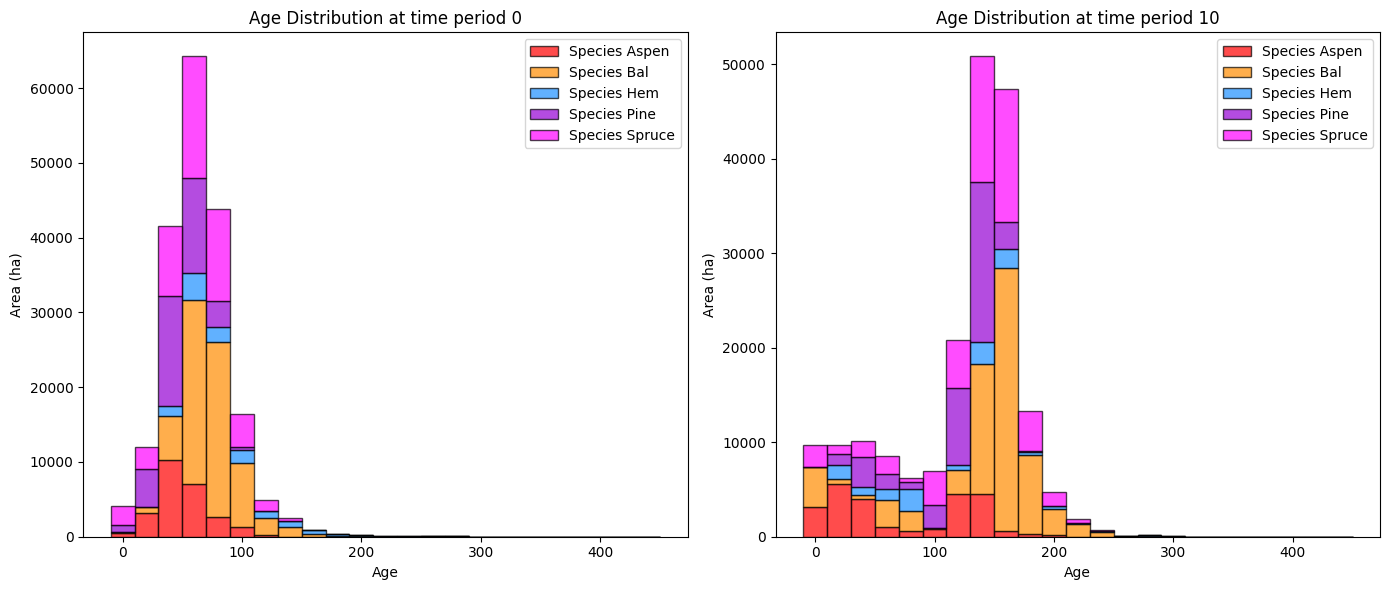

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_80%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10   Difference
Spruce    2.708533   4705.424067  4702.715534
Bal     278.565372  10098.010312  9819.444940
Aspen   273.490478   3146.046700  2872.556222
Pine      0.000000   4387.416975  4387.416975
Hem     419.699331    759.599111   339.899780

Old growth has **increased** by 22122.03 hectares from time period 0 to time period 10.


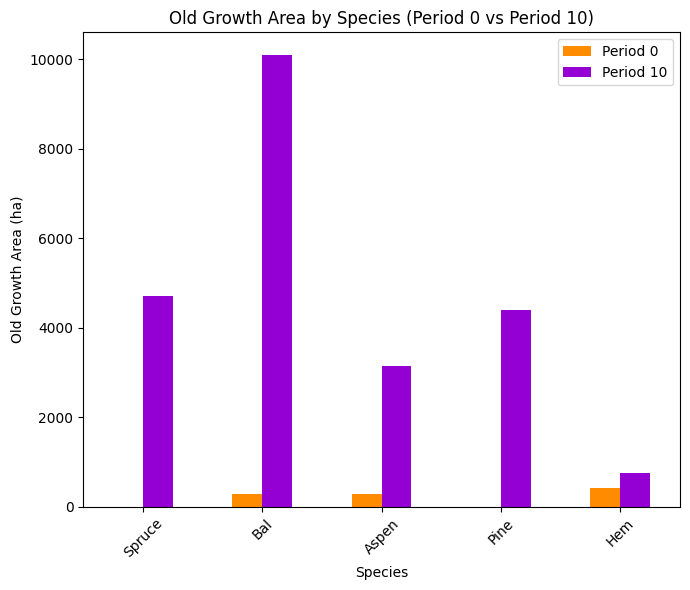

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_80%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8718

Diversity has **decreased** by 7.37% from time 0 to time 10.


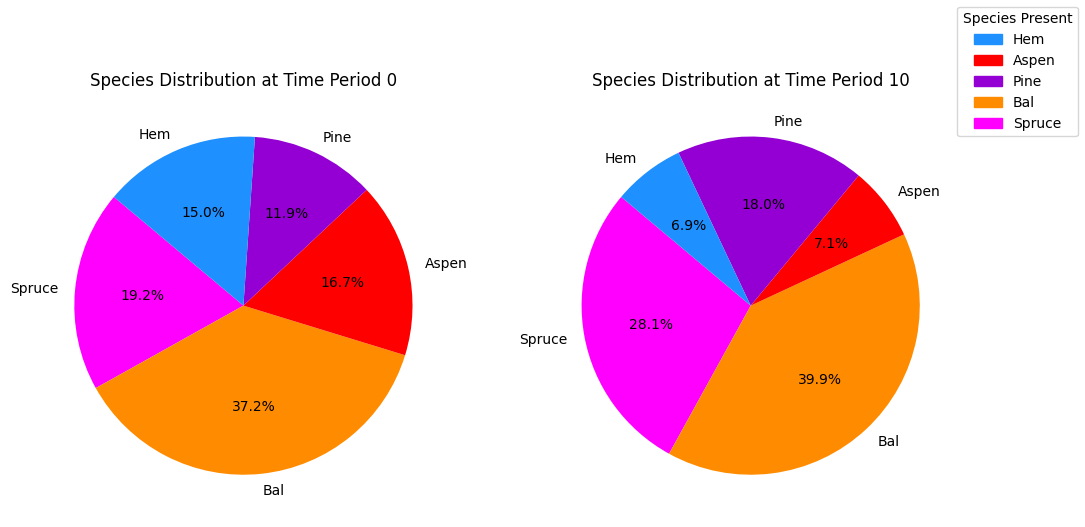

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_80%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x14bd878b
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.13s
Presolved: 1911 rows, 34099 columns, 409165 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time

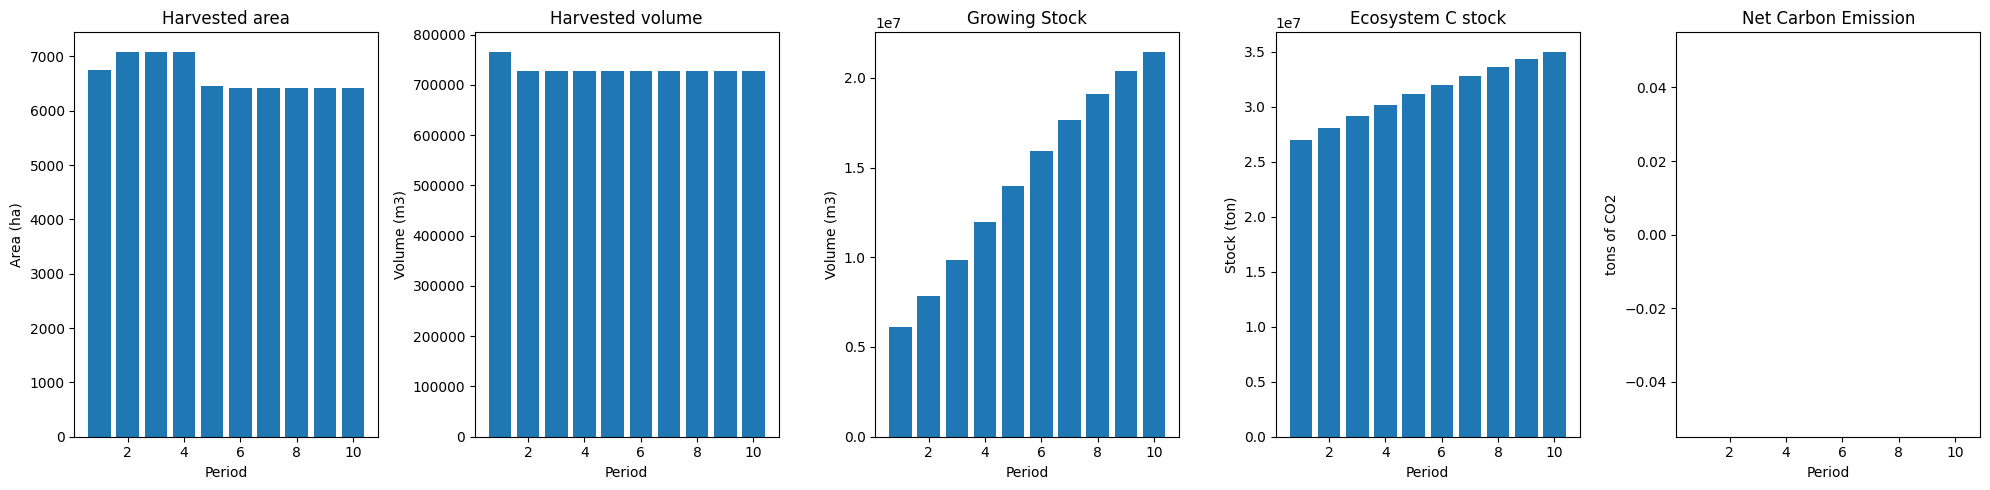

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7734
The economic indicator (the provincial government revenues) is:  263762
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


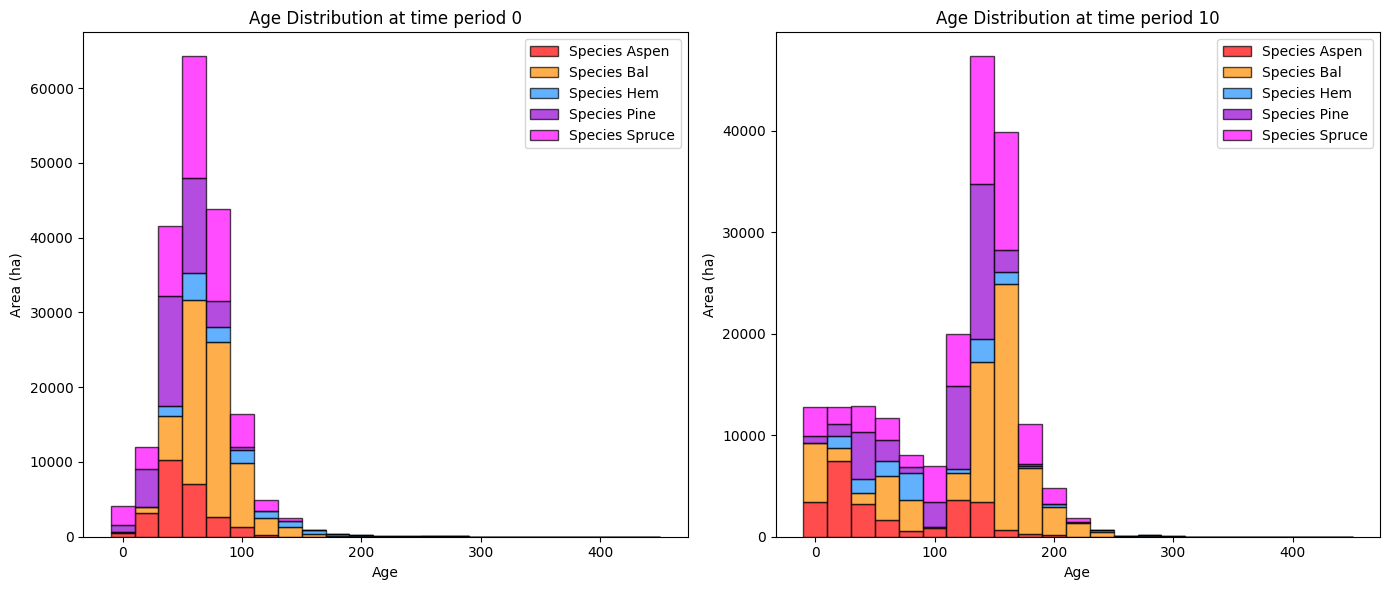

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0           10   Difference
Spruce    2.708533  4178.736448  4176.027915
Bal     278.565372  8822.787379  8544.222007
Aspen   273.490478  2555.924852  2282.434374
Pine      0.000000  3560.331018  3560.331018
Hem     419.699331   708.923341   289.224010

Old growth has **increased** by 18852.24 hectares from time period 0 to time period 10.


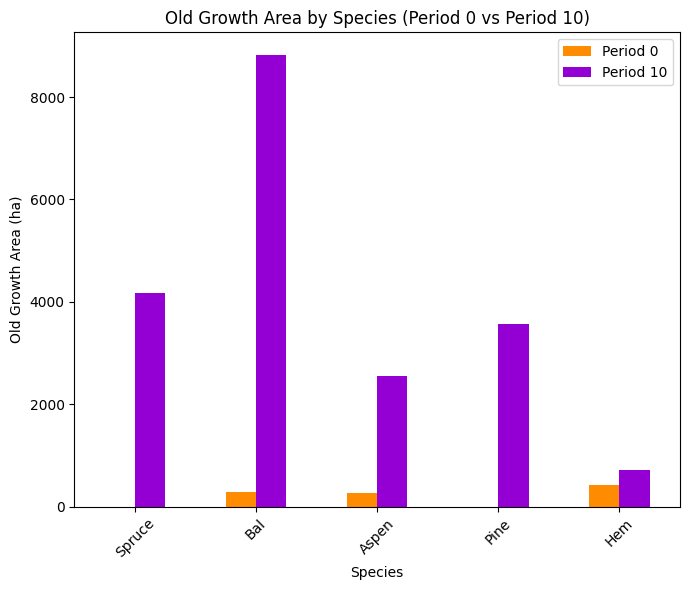

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8666

Diversity has **decreased** by 7.89% from time 0 to time 10.


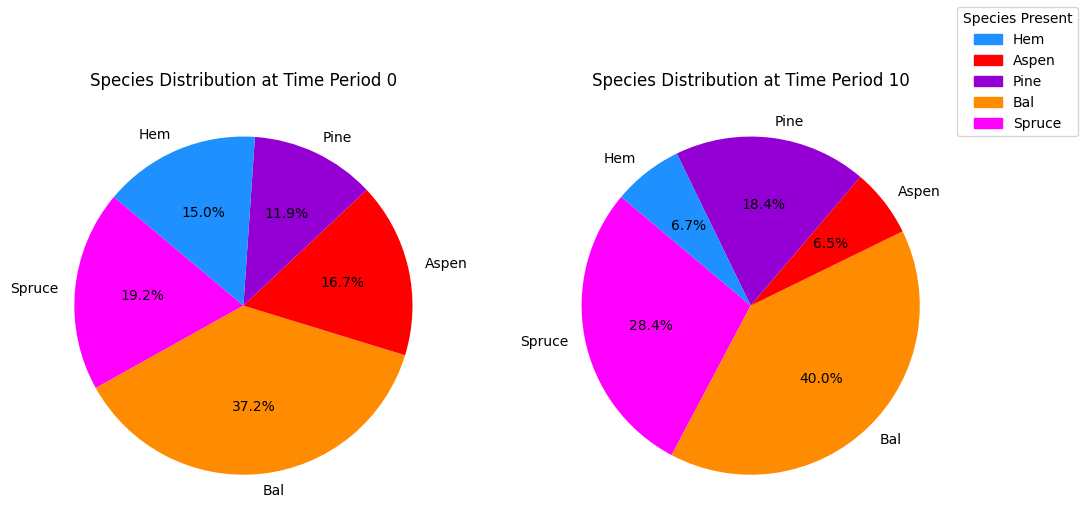

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_species_pie.pdf


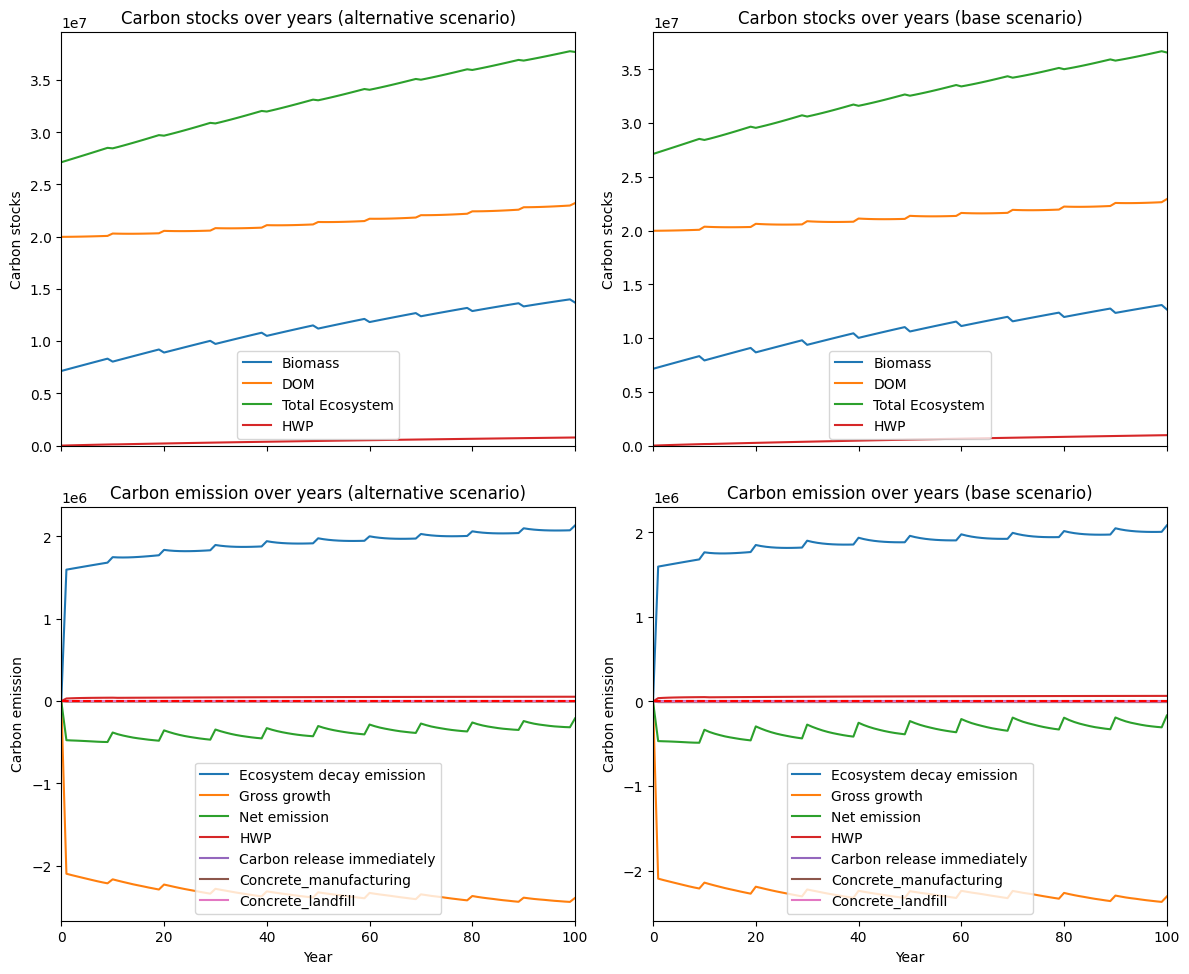

---------------------------------------------------------------------------------------
Net emission difference -4295723.964641539
Net emission base scenario -33380413.402354177
Net emission alternative scenario -37676137.366995715
dollar_per_ton is:  2.327896317899109
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0   526.687619   526.687619
Bal     0.0  1275.222933  1275.222933
Aspen   0.0   590.121848   590.121848
Pine    0.0   827.085957   827.085957
Hem     0.0    50.675770    50.675770

Overall, the old growth area has **increased** by 3269.79 hectares in the alternative scenario compared to the base scenario.


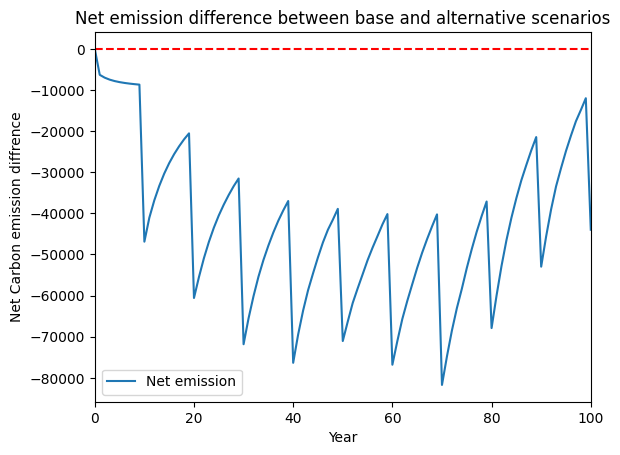

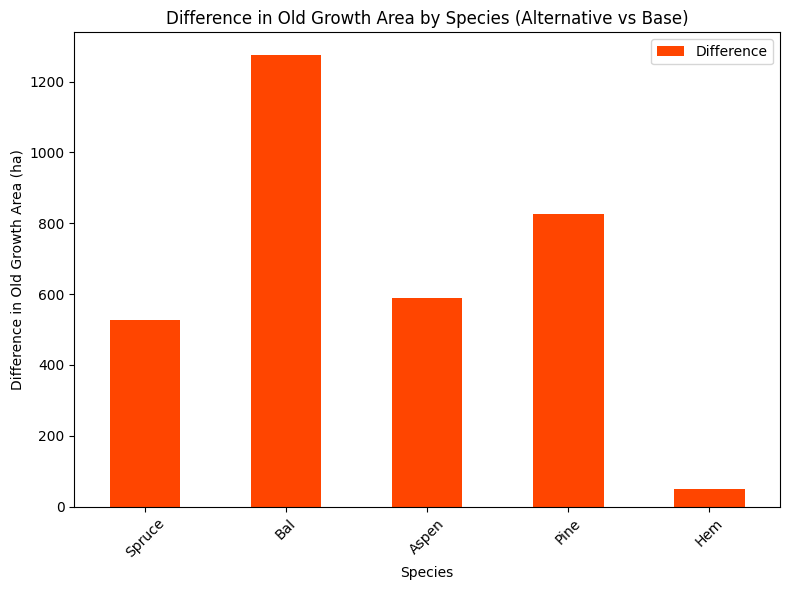

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_kpi_age_difference.pdf


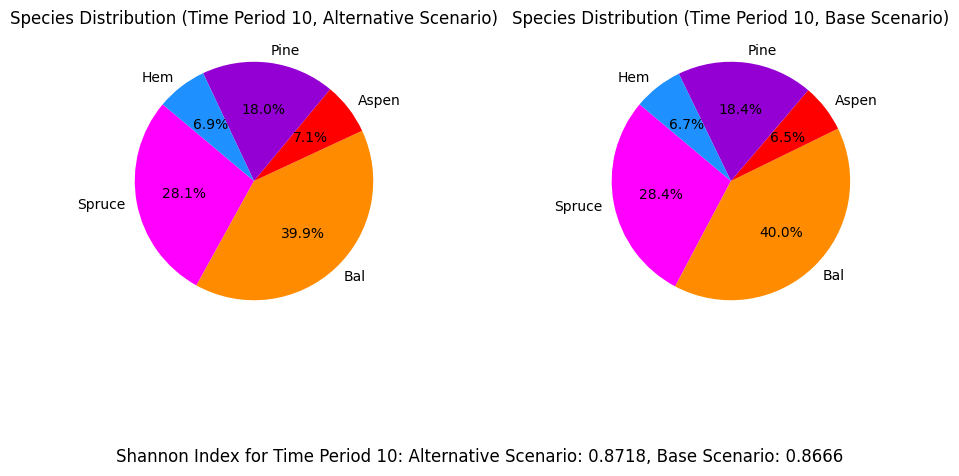

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_em_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_min_em_gldbr_AAC_70%...
running the scenario for the Golden Bear mining site (70%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xc4c5c9d6
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.13s
Presolved: 1911 rows, 34100 

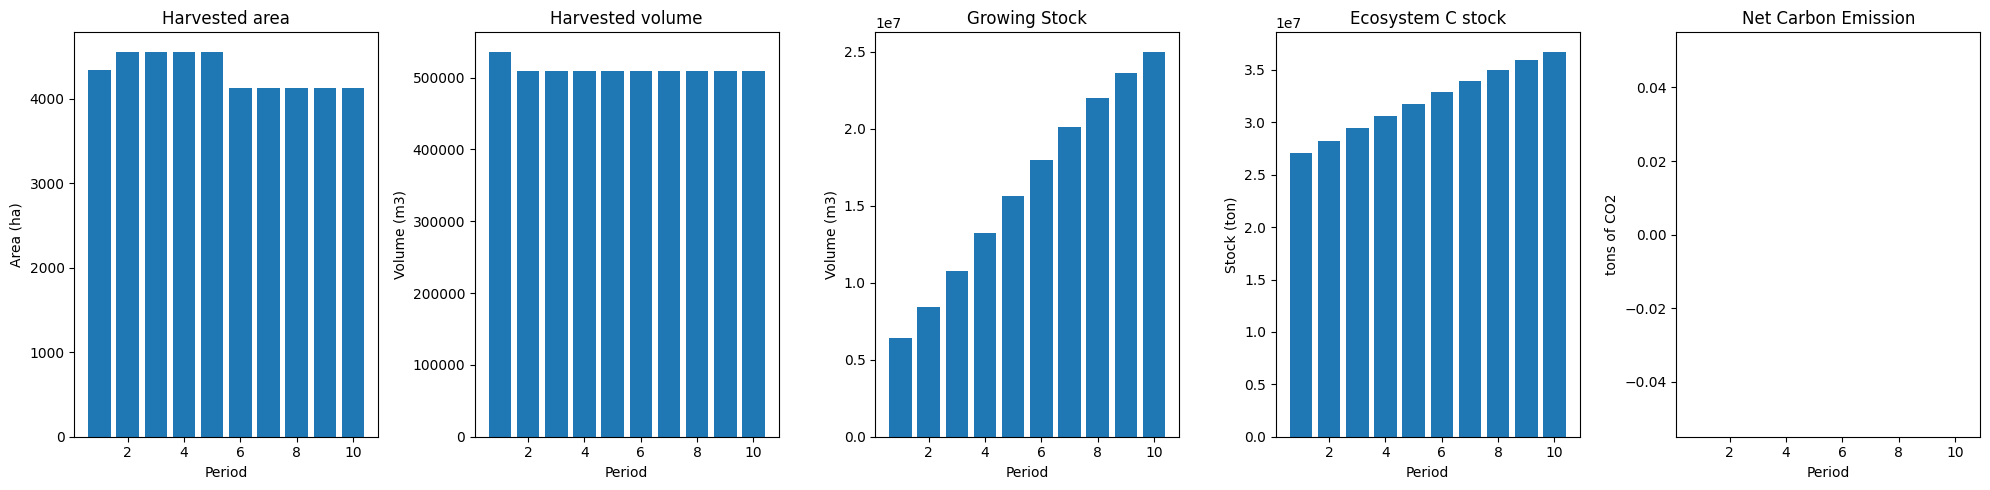

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_70%_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  5414
The economic indicator (the provincial government revenues) is:  184633
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


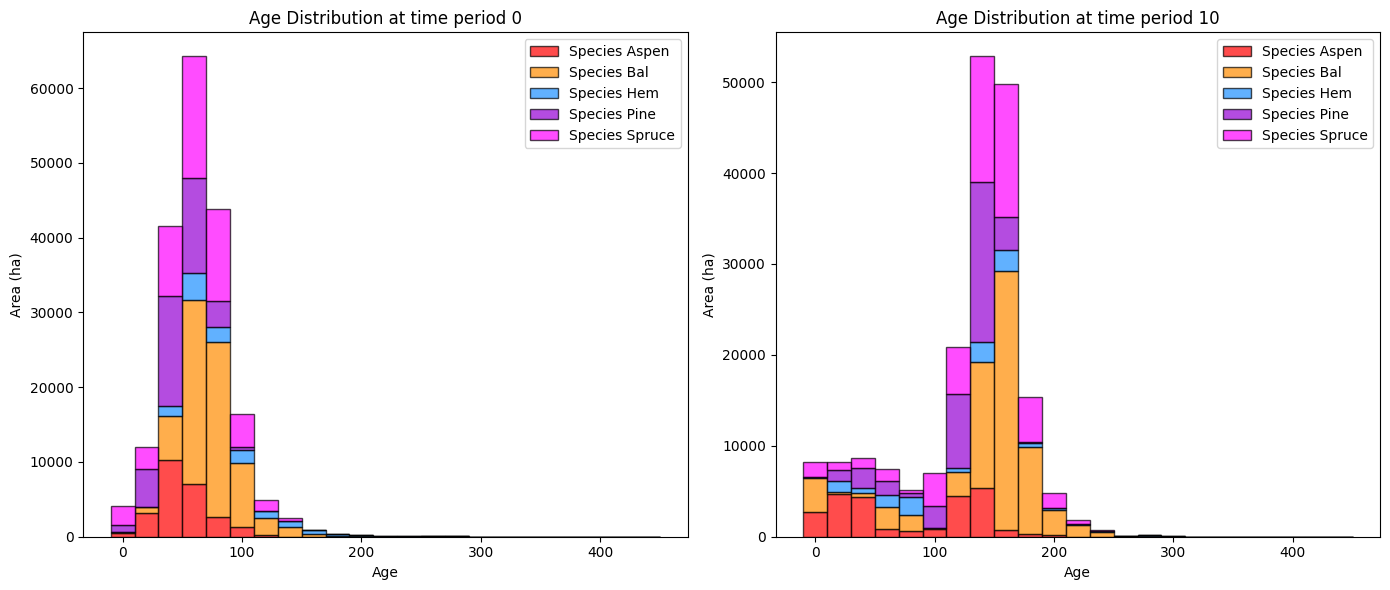

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_70%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   5212.974079   5210.265545
Bal     278.565372  10755.582364  10477.016992
Aspen   273.490478   3510.841719   3237.351241
Pine      0.000000   4837.771226   4837.771226
Hem     419.699331    827.303608    407.604277

Old growth has **increased** by 24170.01 hectares from time period 0 to time period 10.


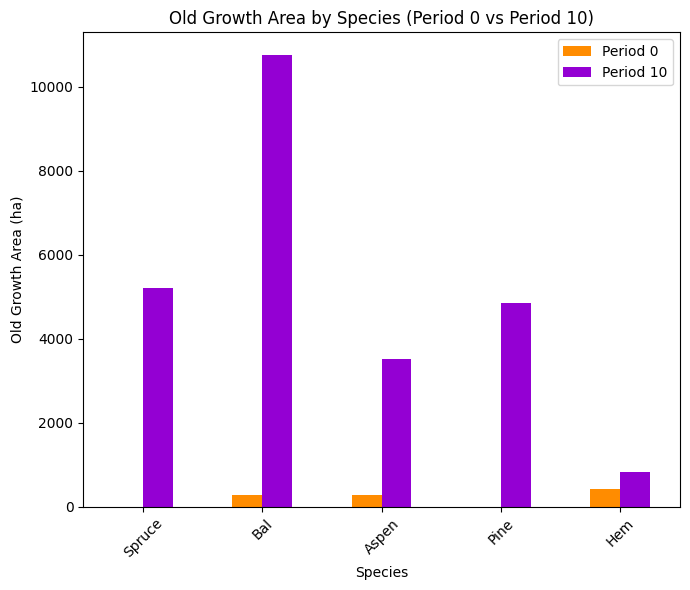

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_70%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8769

Diversity has **decreased** by 6.86% from time 0 to time 10.


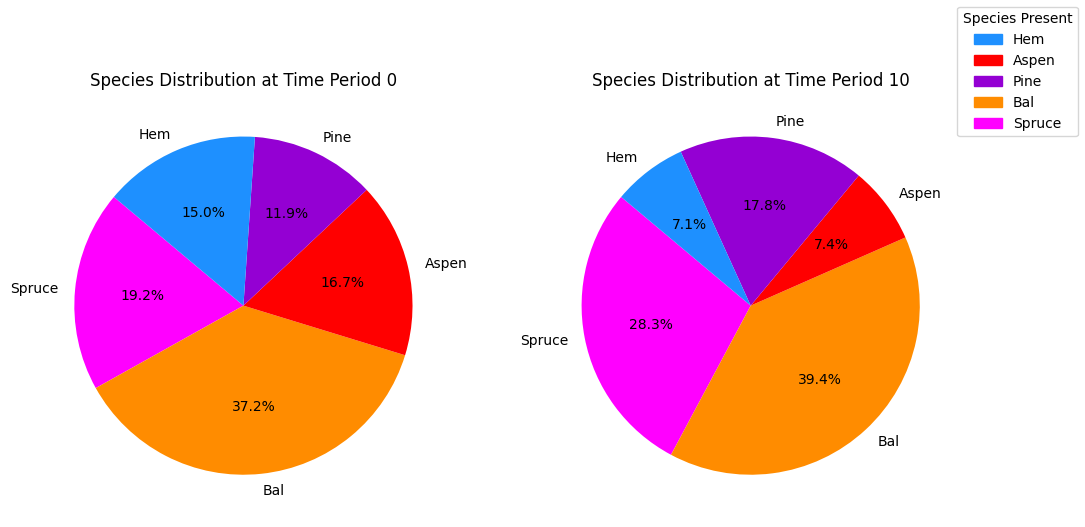

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_70%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x14bd878b
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.18s
Presolved: 1911 rows, 34099 columns, 409165 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time

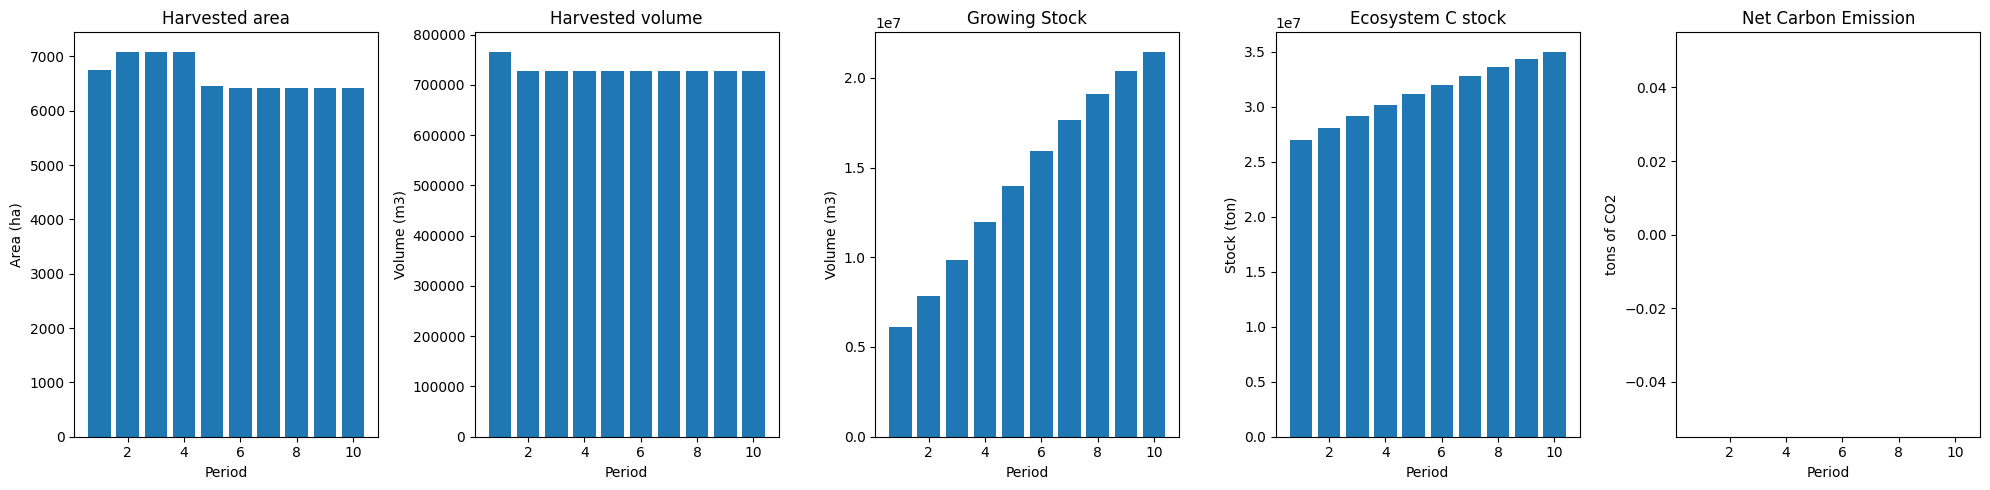

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7734
The economic indicator (the provincial government revenues) is:  263762
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


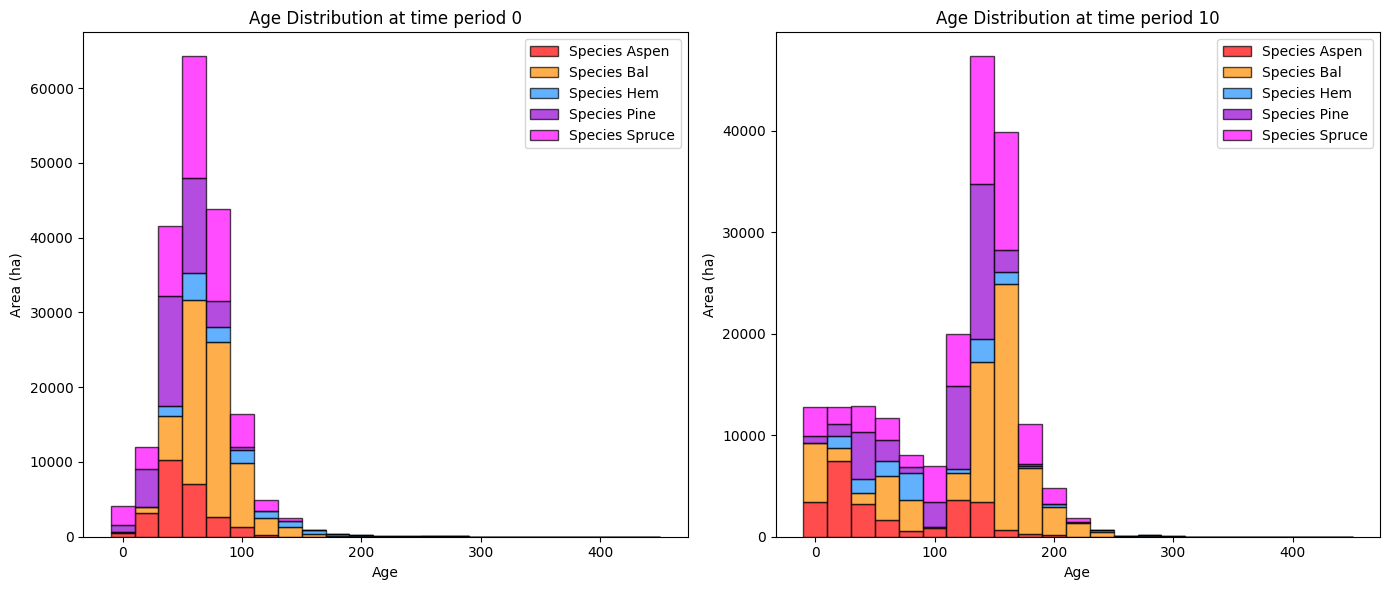

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0           10   Difference
Spruce    2.708533  4178.736448  4176.027915
Bal     278.565372  8822.787379  8544.222007
Aspen   273.490478  2555.924852  2282.434374
Pine      0.000000  3560.331018  3560.331018
Hem     419.699331   708.923341   289.224010

Old growth has **increased** by 18852.24 hectares from time period 0 to time period 10.


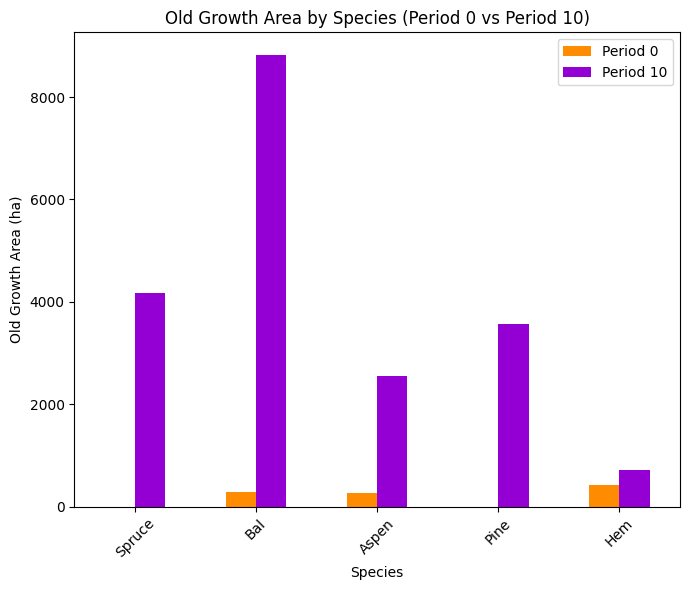

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8666

Diversity has **decreased** by 7.89% from time 0 to time 10.


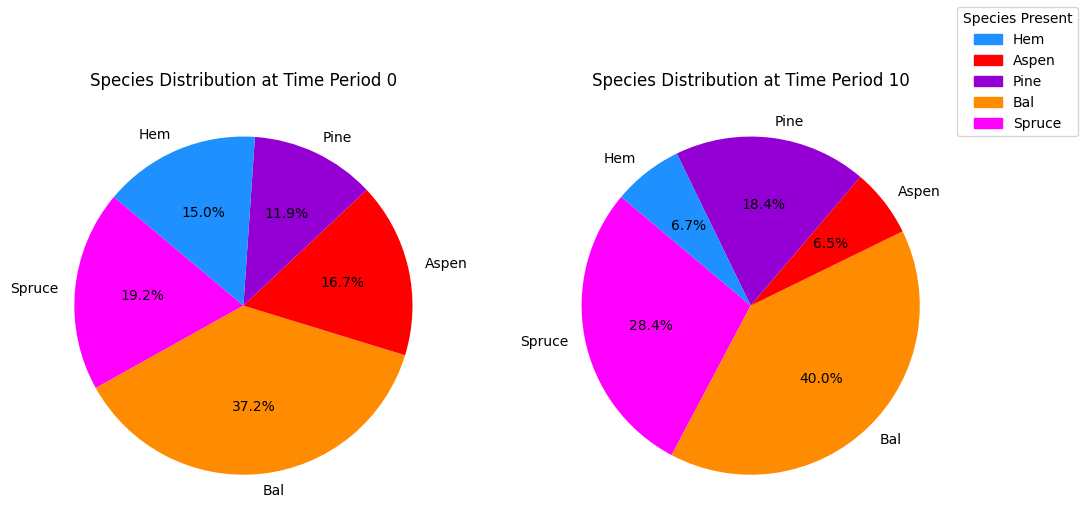

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_species_pie.pdf


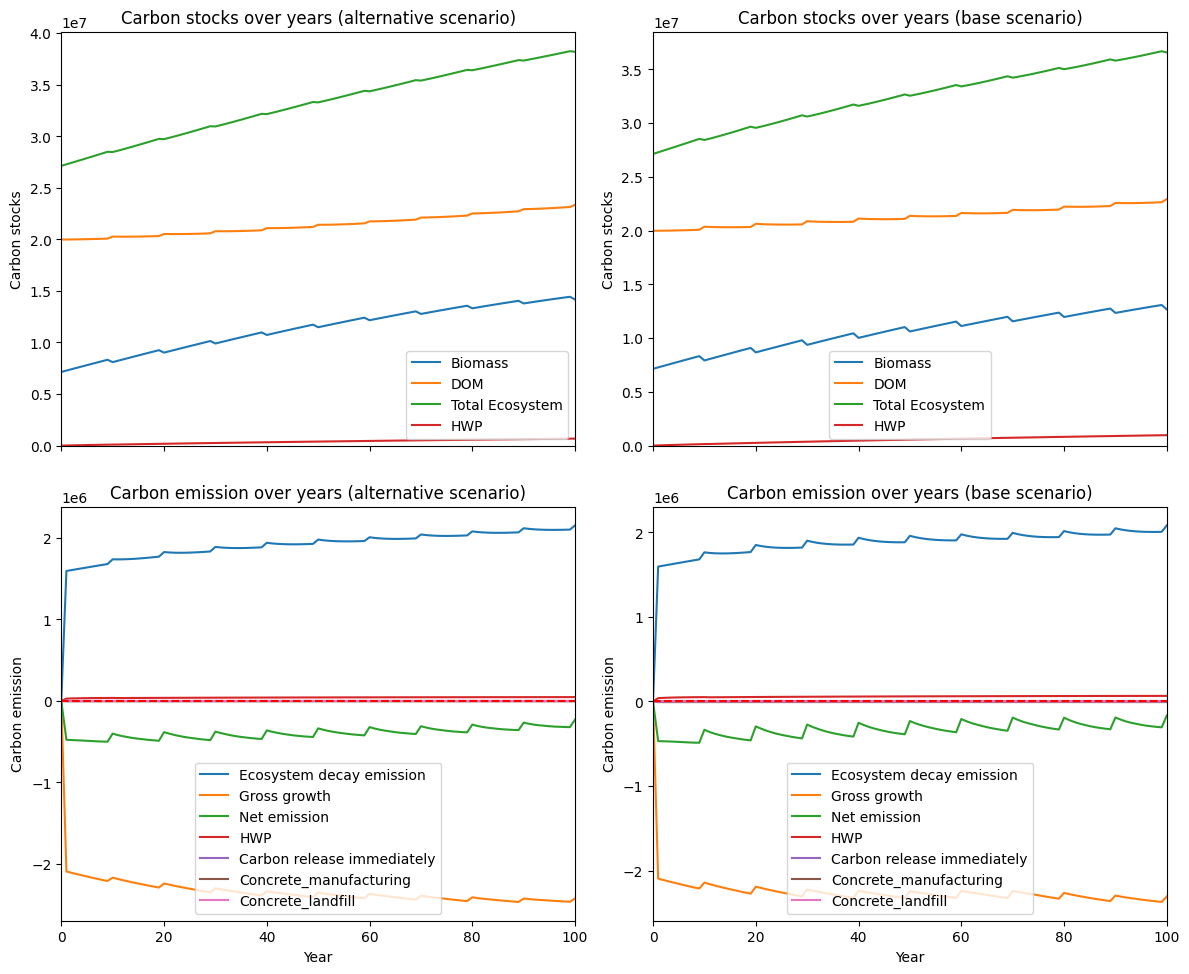

---------------------------------------------------------------------------------------
Net emission difference -6290476.911699222
Net emission base scenario -33380413.402354177
Net emission alternative scenario -39670890.3140534
dollar_per_ton is:  1.5897045868496382
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  1034.237631  1034.237631
Bal     0.0  1932.794985  1932.794985
Aspen   0.0   954.916867   954.916867
Pine    0.0  1277.440208  1277.440208
Hem     0.0   118.380267   118.380267

Overall, the old growth area has **increased** by 5317.77 hectares in the alternative scenario compared to the base scenario.


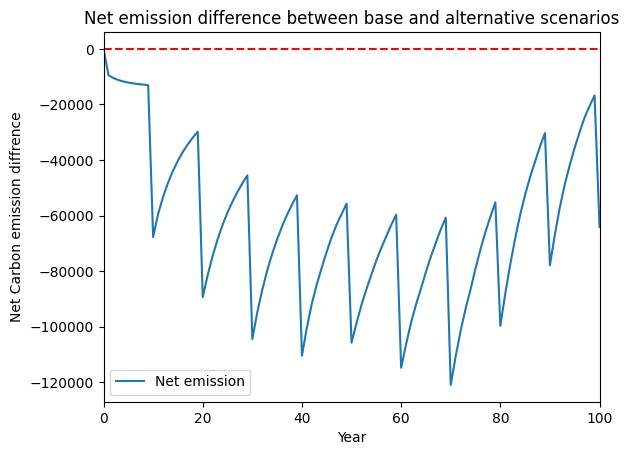

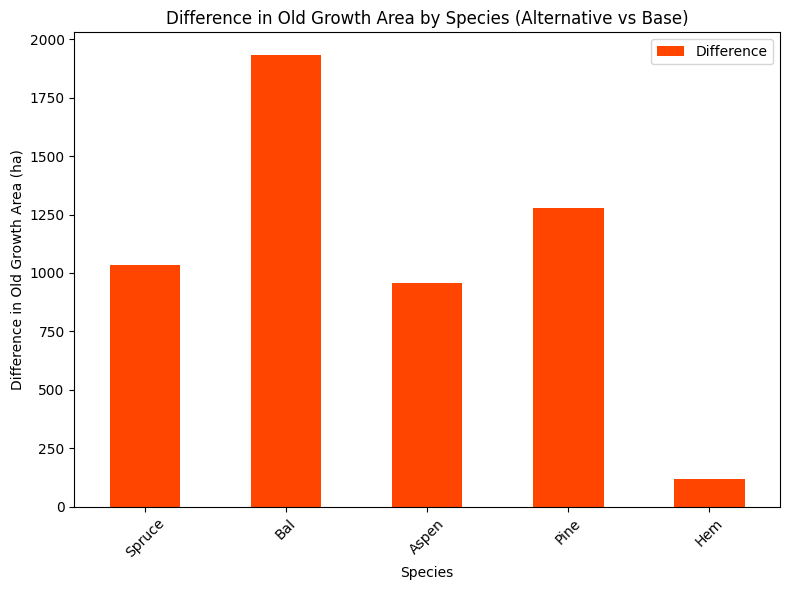

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_kpi_age_difference.pdf


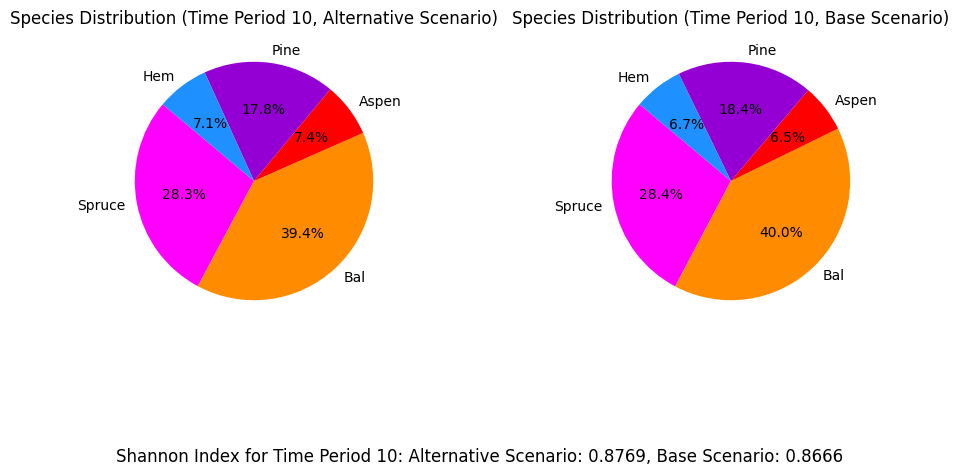

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_em_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_min_em_gldbr_AAC_60%...
running the scenario for the Golden Bear mining site (60%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xe4e51a21
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.14s
Presolved: 1911 rows, 34100 

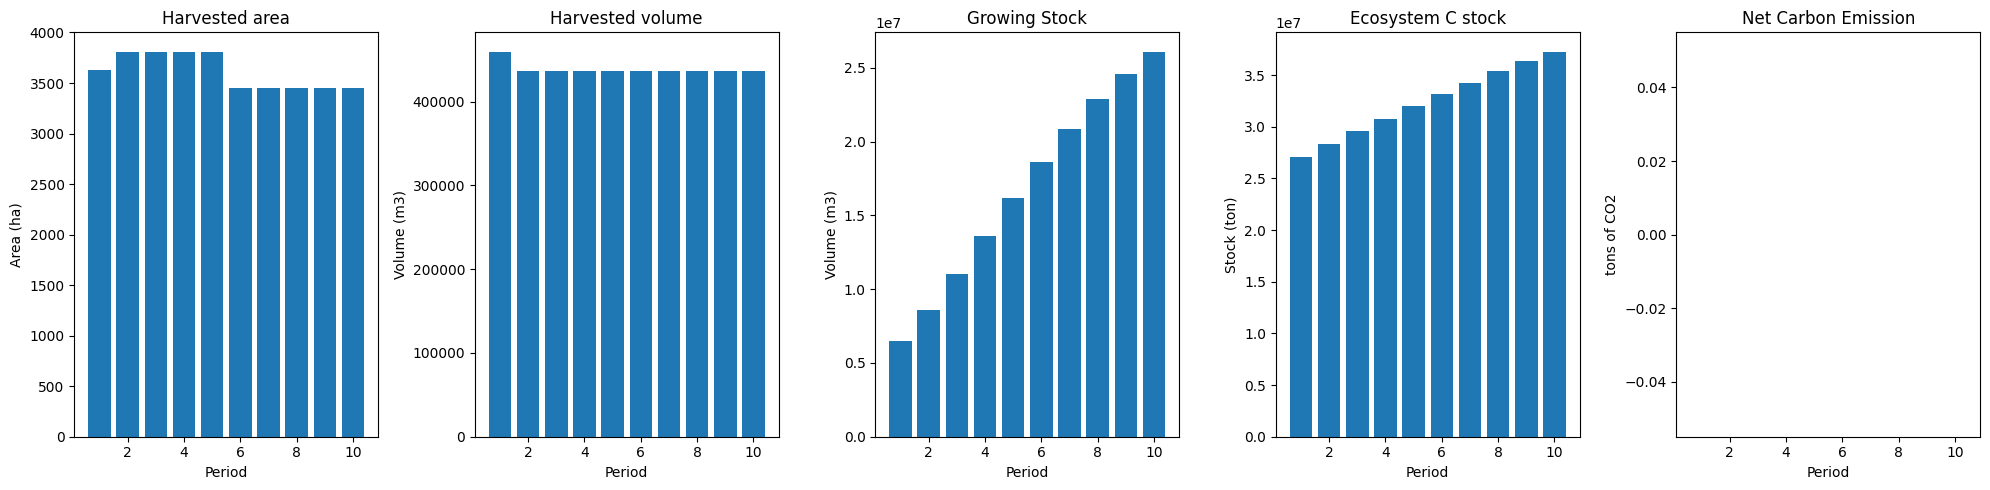

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_60%_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  4640
The economic indicator (the provincial government revenues) is:  158257
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


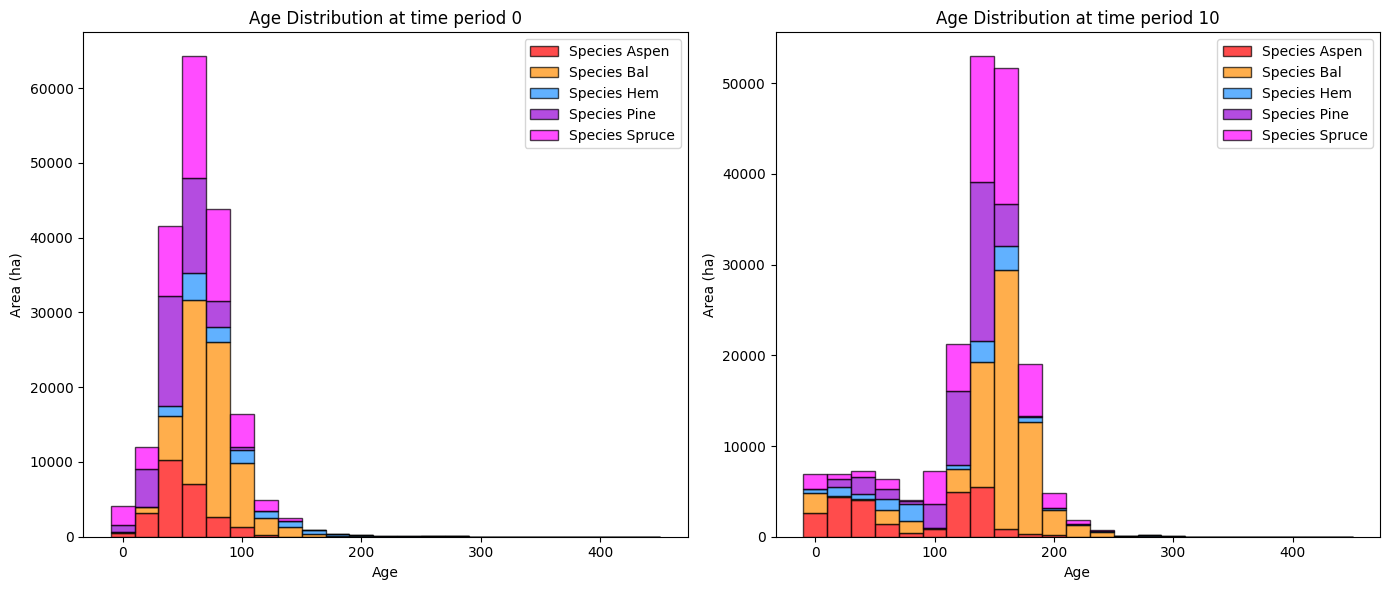

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_60%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   5563.848028   5561.139495
Bal     278.565372  11980.409578  11701.844206
Aspen   273.490478   3720.441118   3446.950640
Pine      0.000000   5269.287550   5269.287550
Hem     419.699331    871.464462    451.765131

Old growth has **increased** by 26430.99 hectares from time period 0 to time period 10.


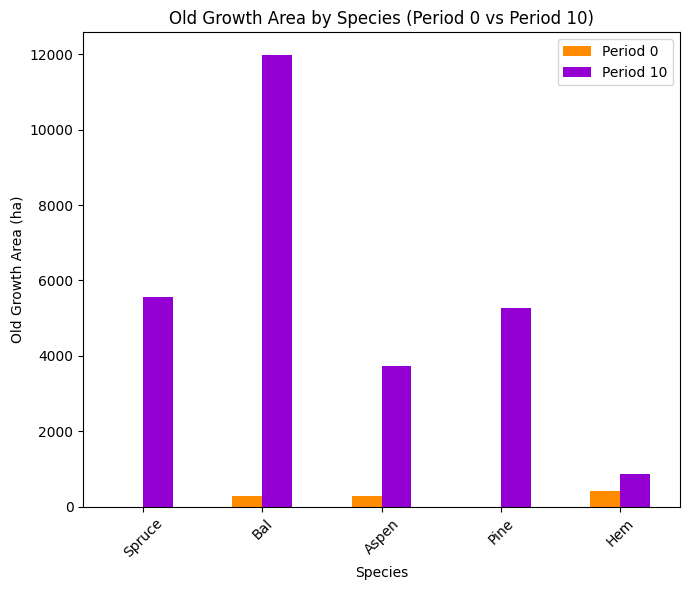

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_60%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8766

Diversity has **decreased** by 6.90% from time 0 to time 10.


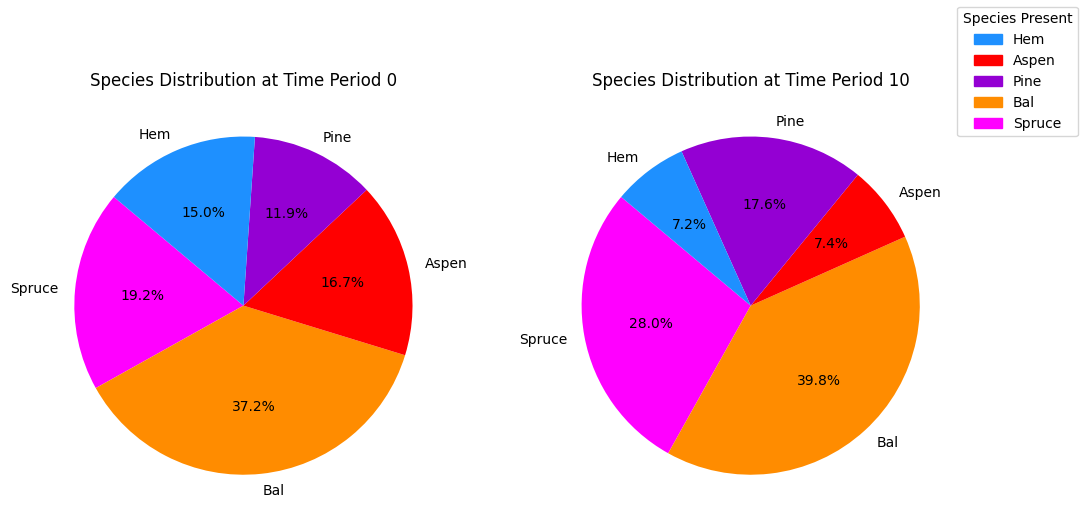

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_60%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x14bd878b
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.15s
Presolved: 1911 rows, 34099 columns, 409165 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time

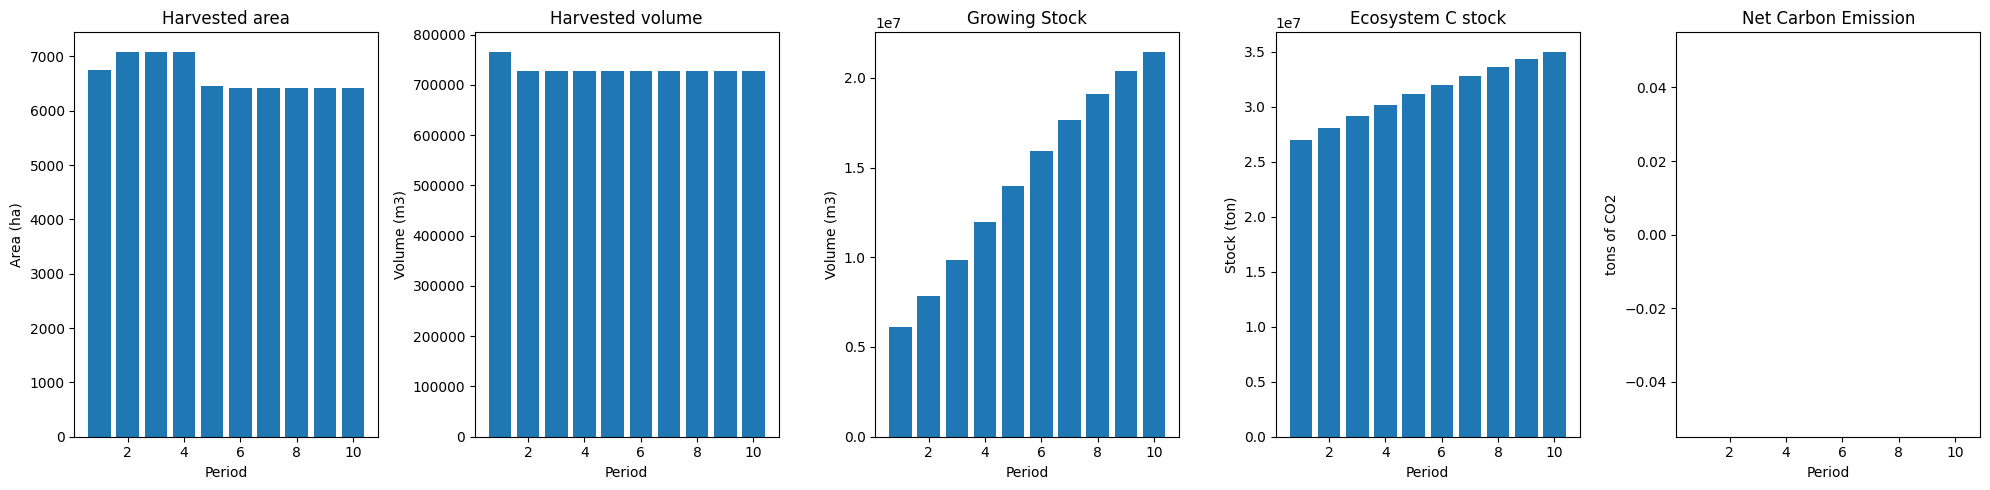

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7734
The economic indicator (the provincial government revenues) is:  263762
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


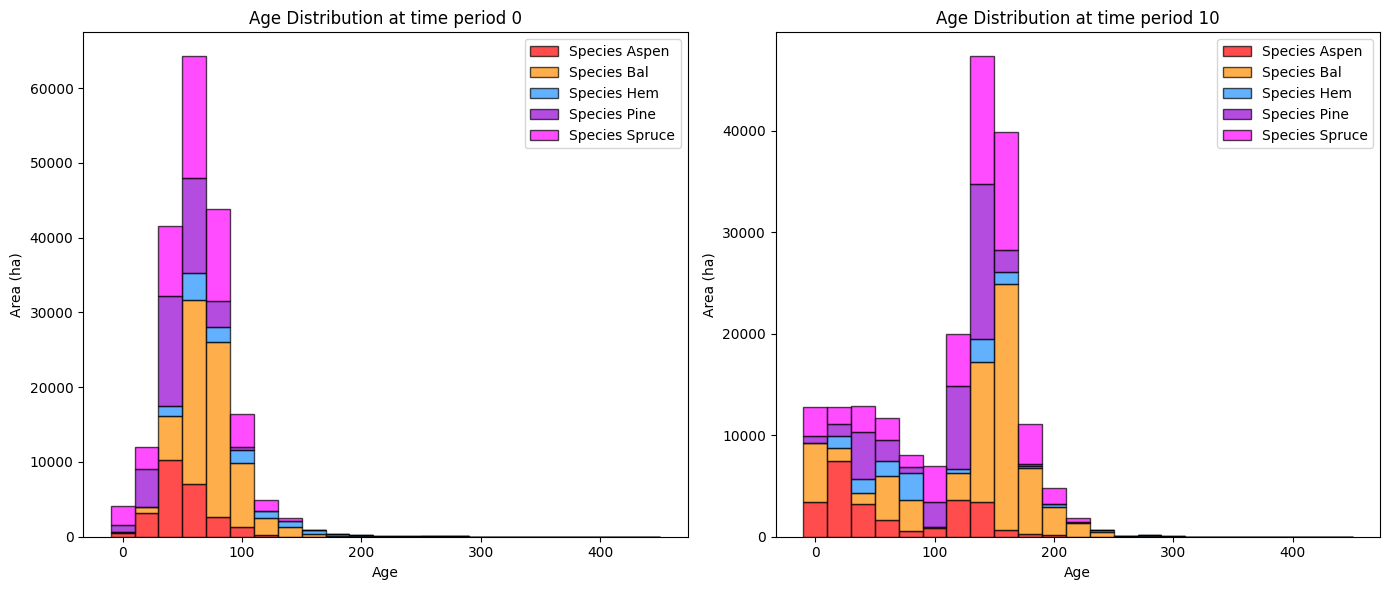

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0           10   Difference
Spruce    2.708533  4178.736448  4176.027915
Bal     278.565372  8822.787379  8544.222007
Aspen   273.490478  2555.924852  2282.434374
Pine      0.000000  3560.331018  3560.331018
Hem     419.699331   708.923341   289.224010

Old growth has **increased** by 18852.24 hectares from time period 0 to time period 10.


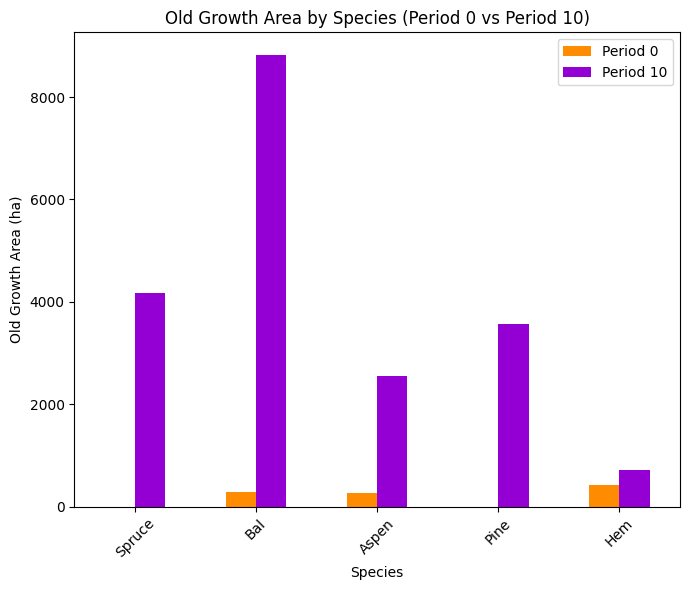

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8666

Diversity has **decreased** by 7.89% from time 0 to time 10.


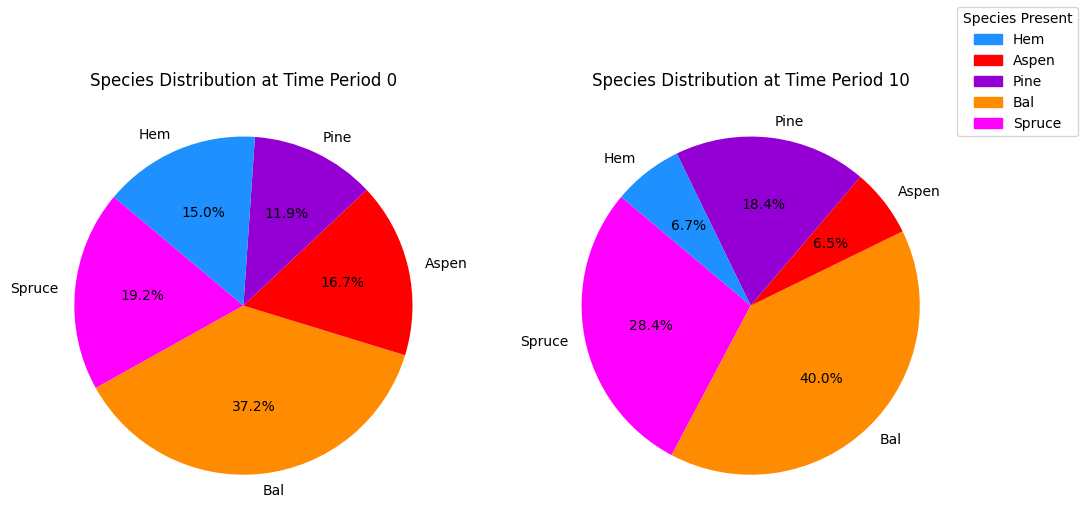

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_species_pie.pdf


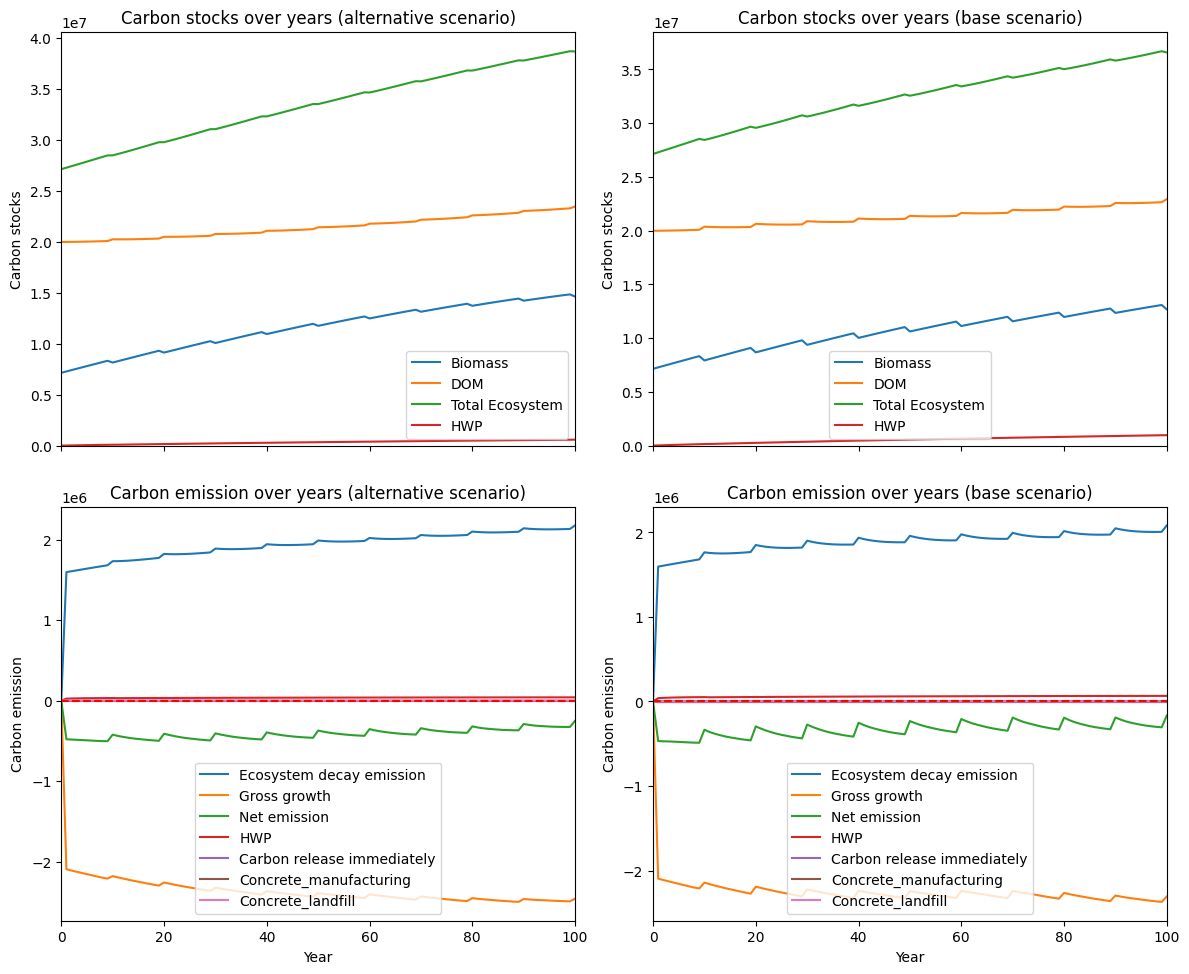

---------------------------------------------------------------------------------------
Net emission difference -8172012.959813077
Net emission base scenario -33380413.402354177
Net emission alternative scenario -41552426.36216725
dollar_per_ton is:  1.2236887103797172
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  1385.111580  1385.111580
Bal     0.0  3157.622199  3157.622199
Aspen   0.0  1164.516266  1164.516266
Pine    0.0  1708.956532  1708.956532
Hem     0.0   162.541121   162.541121

Overall, the old growth area has **increased** by 7578.75 hectares in the alternative scenario compared to the base scenario.


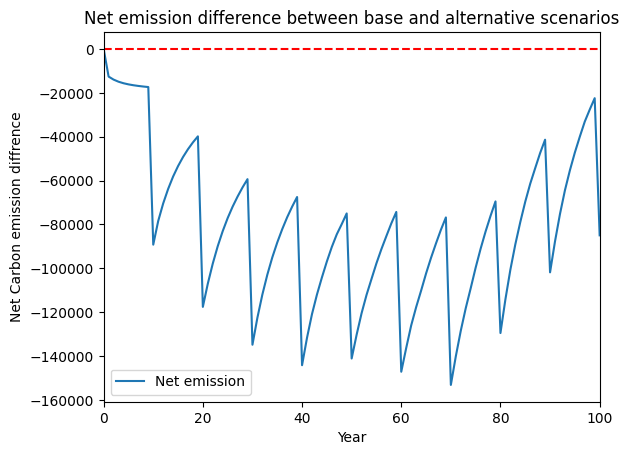

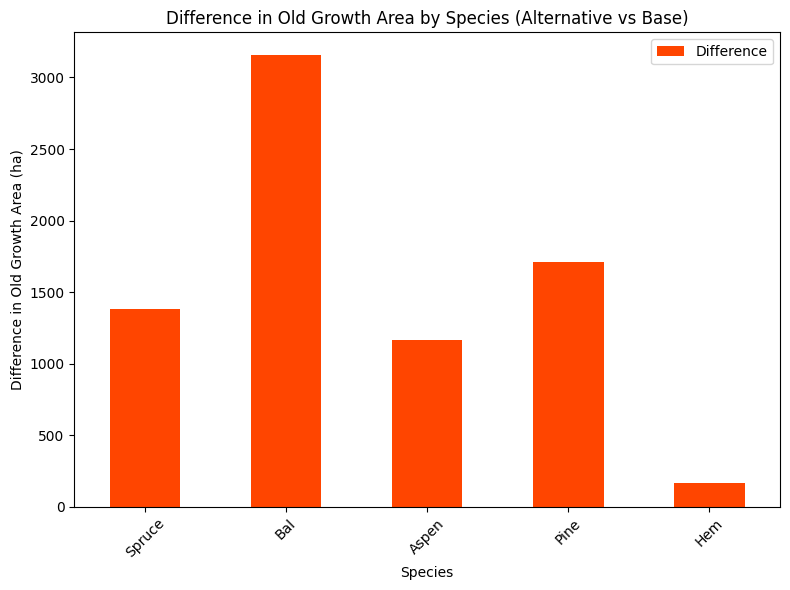

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_kpi_age_difference.pdf


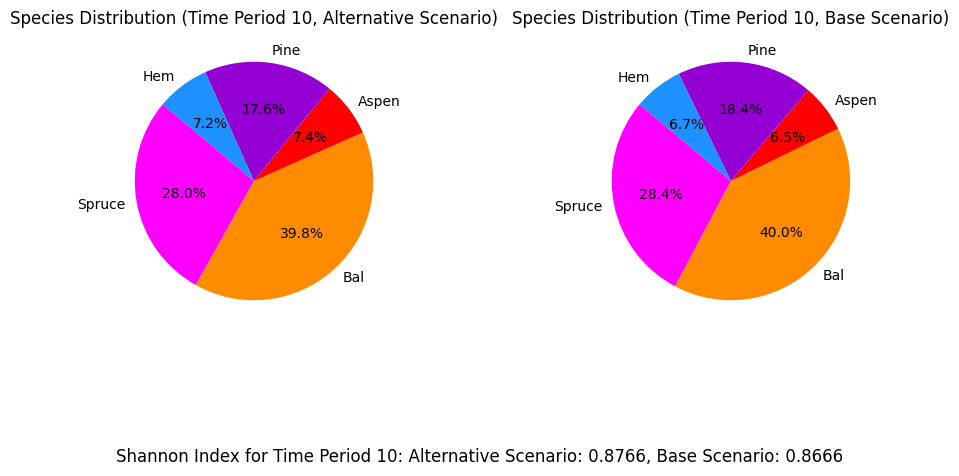

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_em_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_min_em_gldbr_AAC_50%...
running the scenario for the Golden Bear mining site (50%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xb287521c
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.13s
Presolved: 1911 rows, 34100 

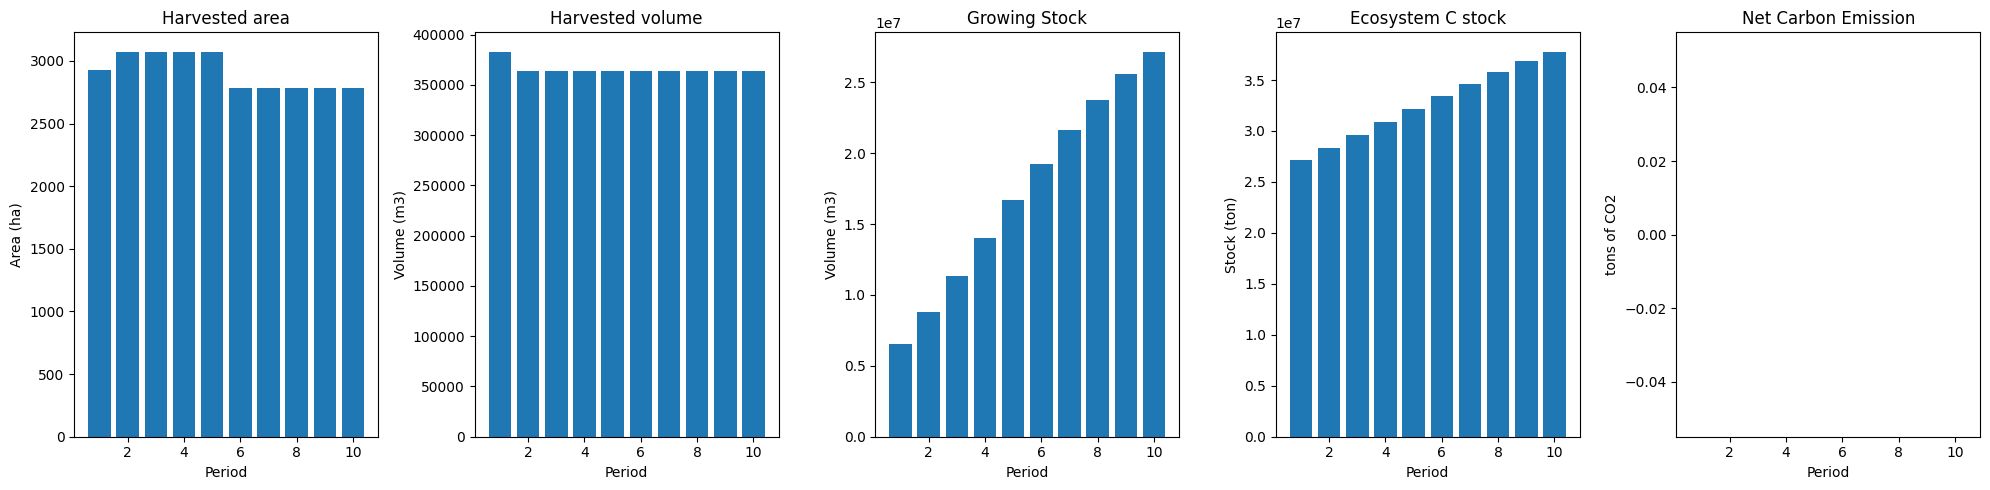

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_50%_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  3867
The economic indicator (the provincial government revenues) is:  131881
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


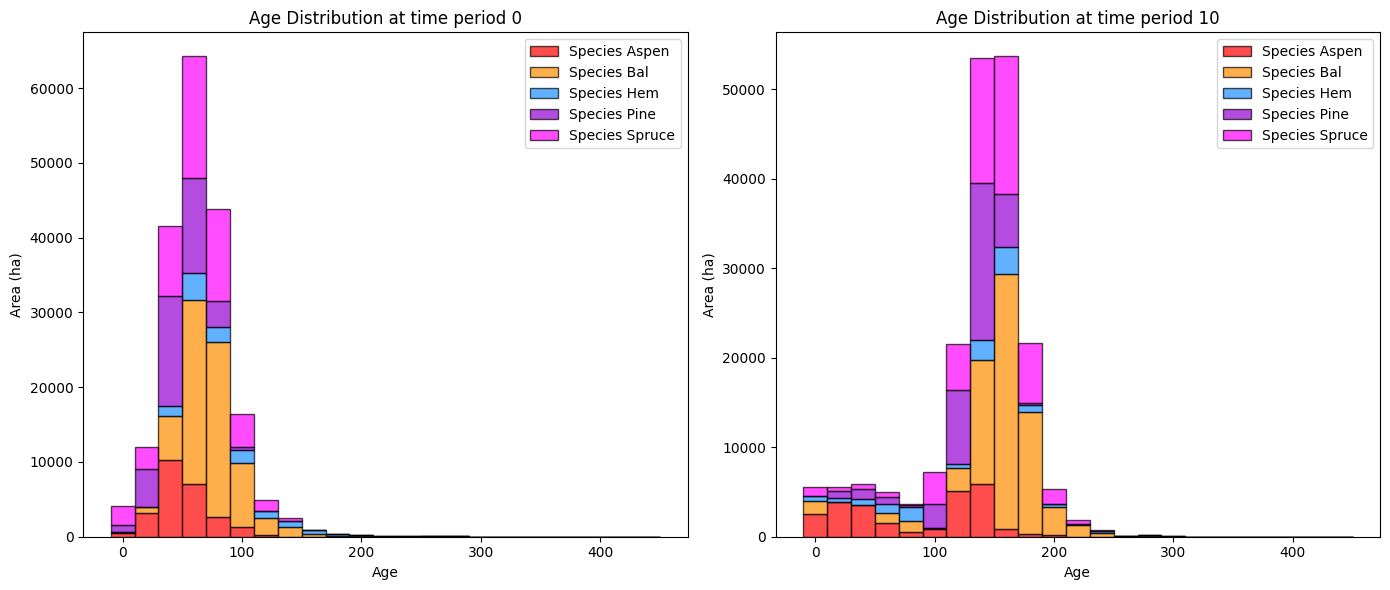

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_50%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   6245.342484   6242.633951
Bal     278.565372  12805.809393  12527.244021
Aspen   273.490478   4035.340643   3761.850165
Pine      0.000000   6070.015594   6070.015594
Hem     419.699331   1022.669871    602.970540

Old growth has **increased** by 29204.71 hectares from time period 0 to time period 10.


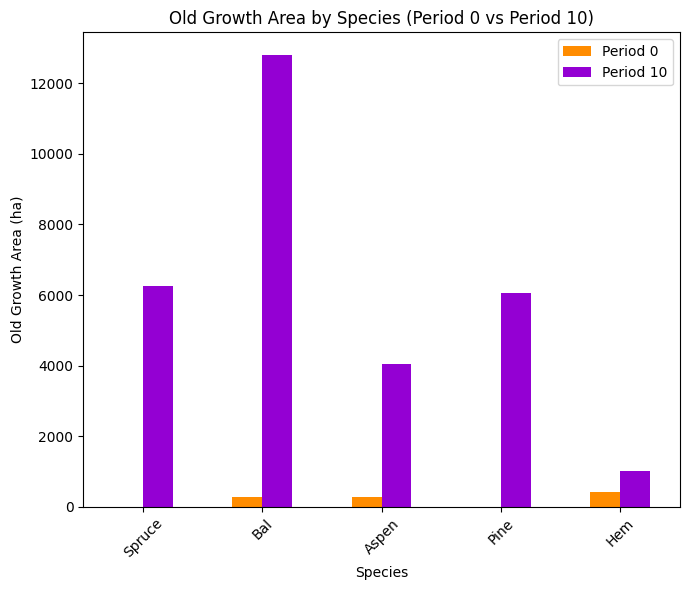

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_50%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8811

Diversity has **decreased** by 6.44% from time 0 to time 10.


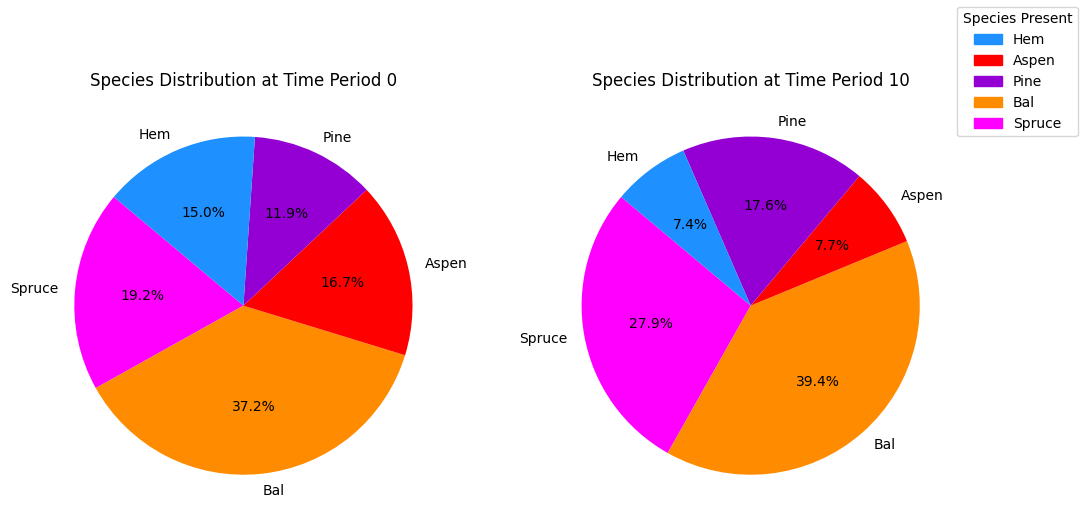

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_50%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x14bd878b
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.14s
Presolved: 1911 rows, 34099 columns, 409165 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time

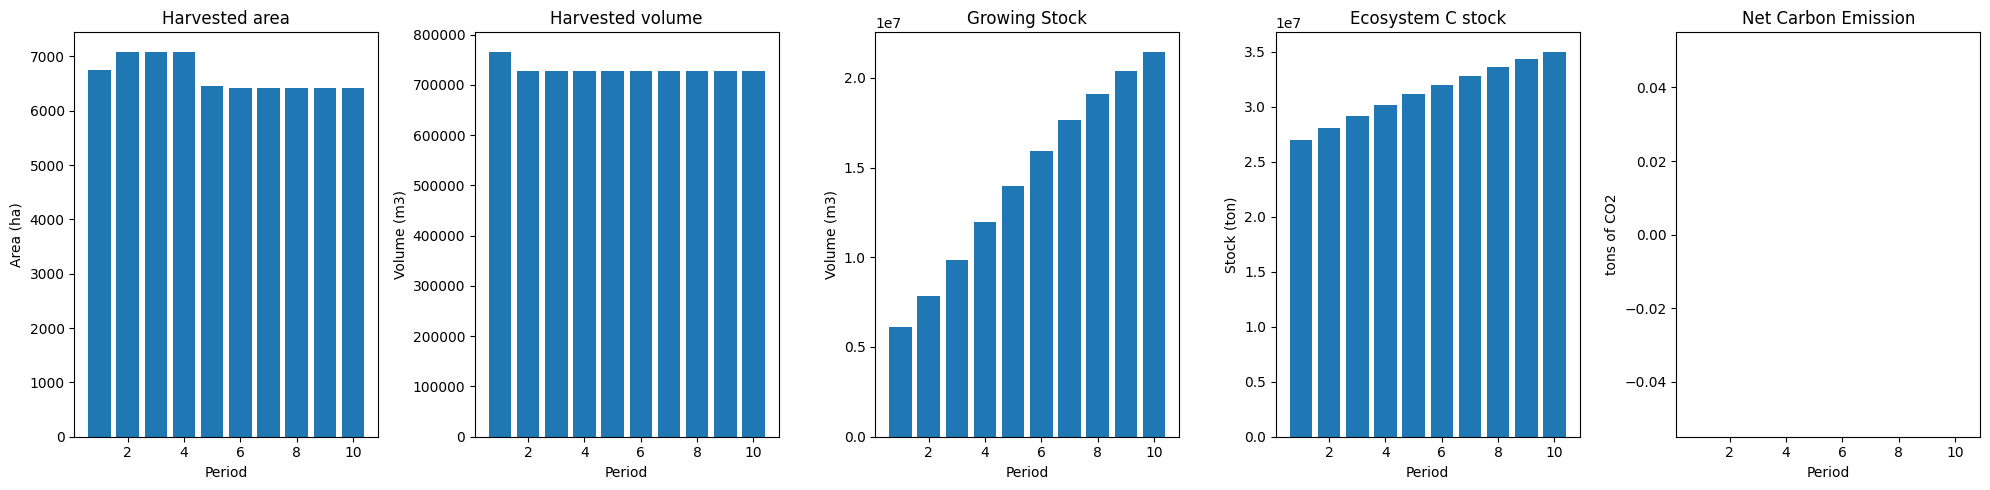

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7734
The economic indicator (the provincial government revenues) is:  263762
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


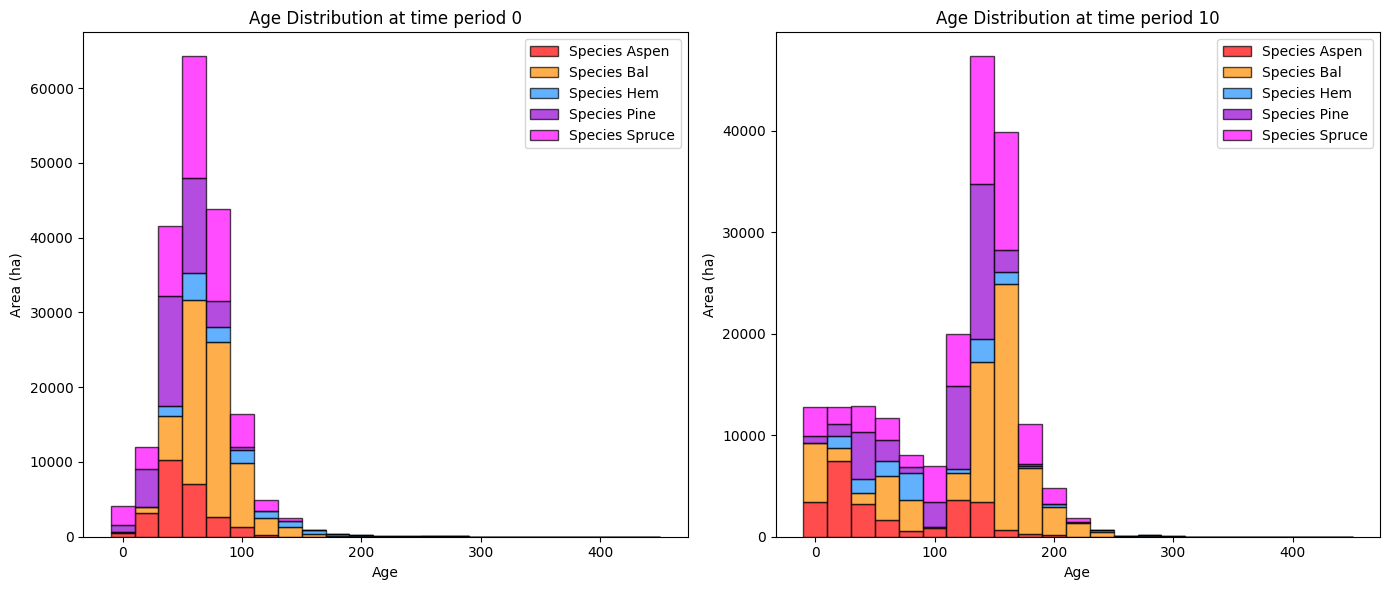

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0           10   Difference
Spruce    2.708533  4178.736448  4176.027915
Bal     278.565372  8822.787379  8544.222007
Aspen   273.490478  2555.924852  2282.434374
Pine      0.000000  3560.331018  3560.331018
Hem     419.699331   708.923341   289.224010

Old growth has **increased** by 18852.24 hectares from time period 0 to time period 10.


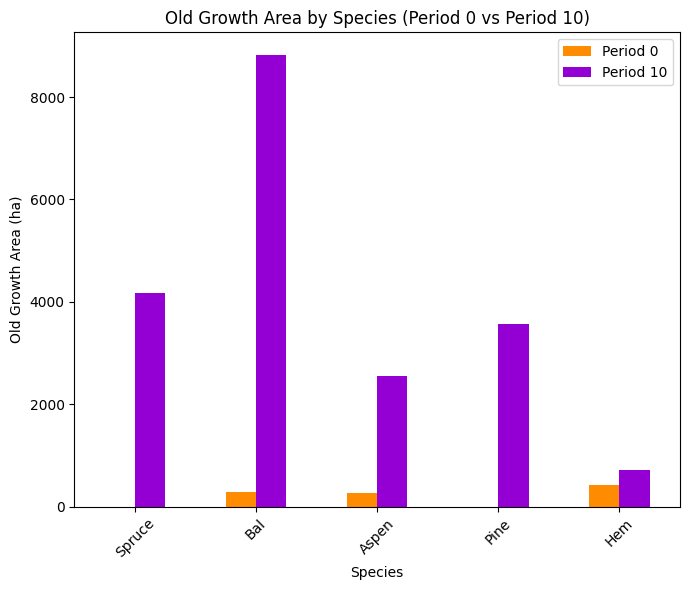

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8666

Diversity has **decreased** by 7.89% from time 0 to time 10.


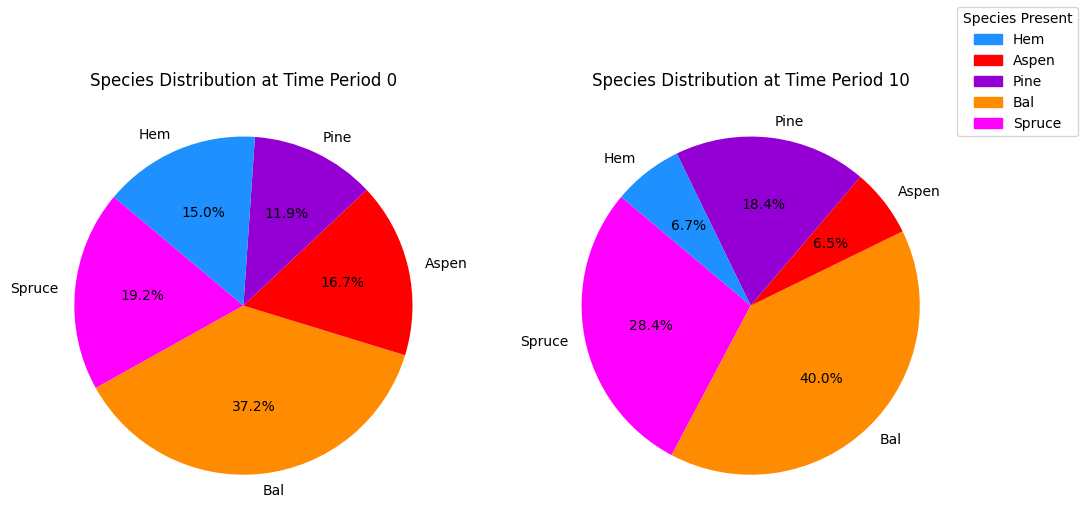

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_species_pie.pdf


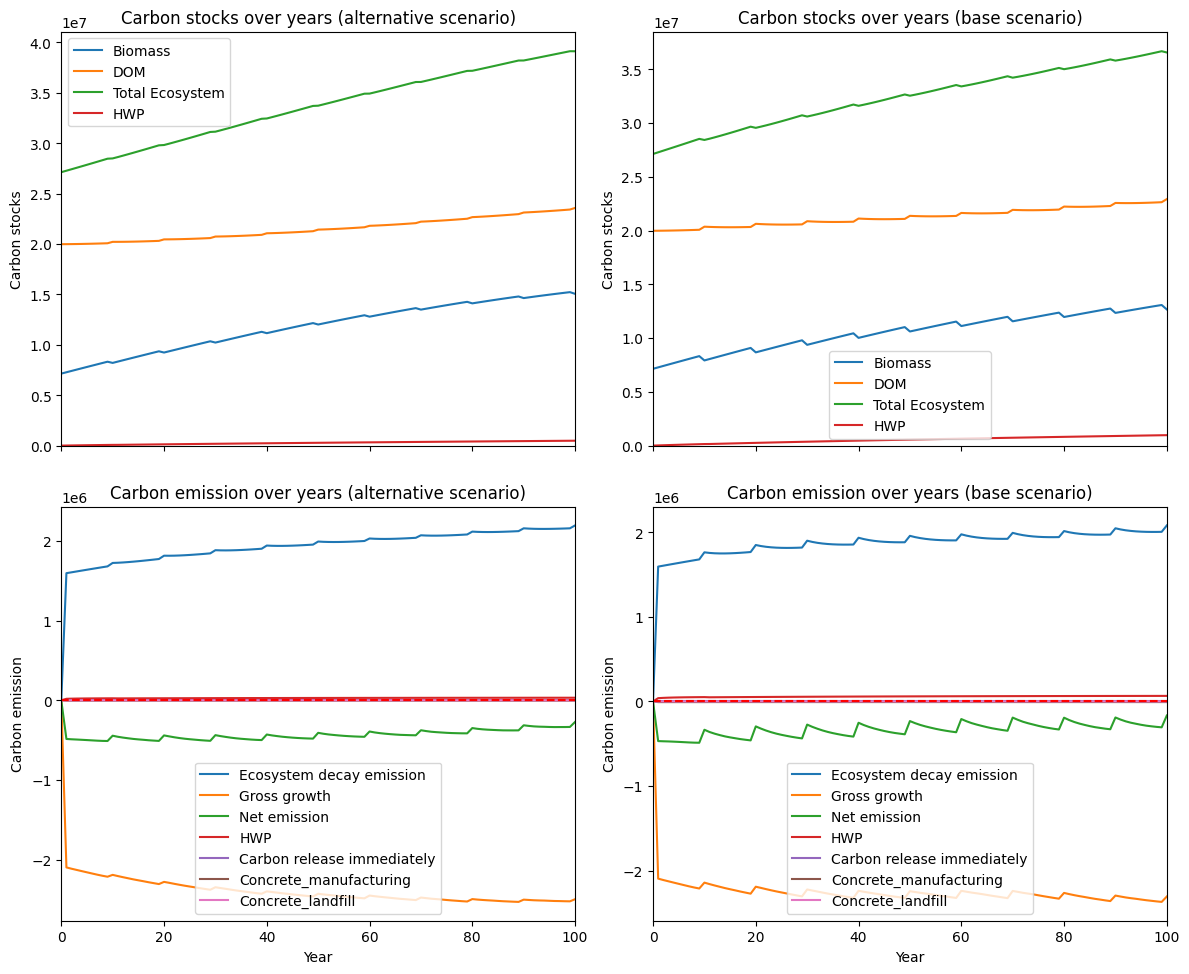

---------------------------------------------------------------------------------------
Net emission difference -9950936.006069409
Net emission base scenario -33380413.402354177
Net emission alternative scenario -43331349.40842358
dollar_per_ton is:  1.0049305908409687
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  2066.606036  2066.606036
Bal     0.0  3983.022014  3983.022014
Aspen   0.0  1479.415791  1479.415791
Pine    0.0  2509.684576  2509.684576
Hem     0.0   313.746530   313.746530

Overall, the old growth area has **increased** by 10352.47 hectares in the alternative scenario compared to the base scenario.


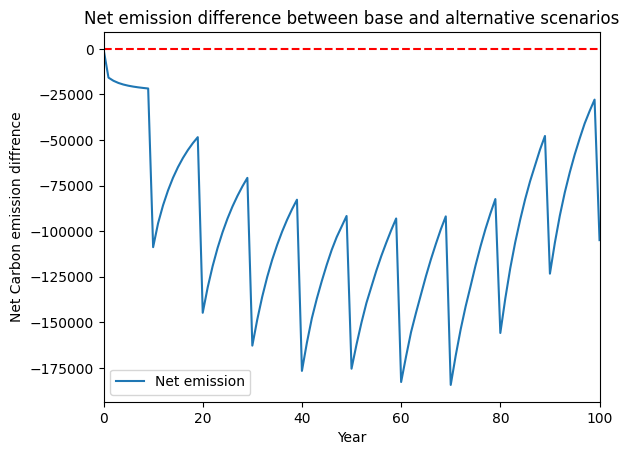

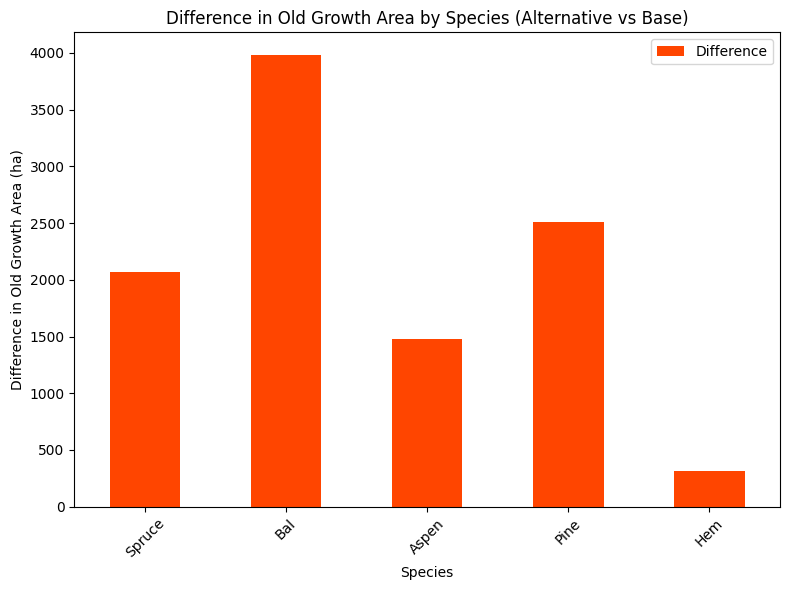

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_kpi_age_difference.pdf


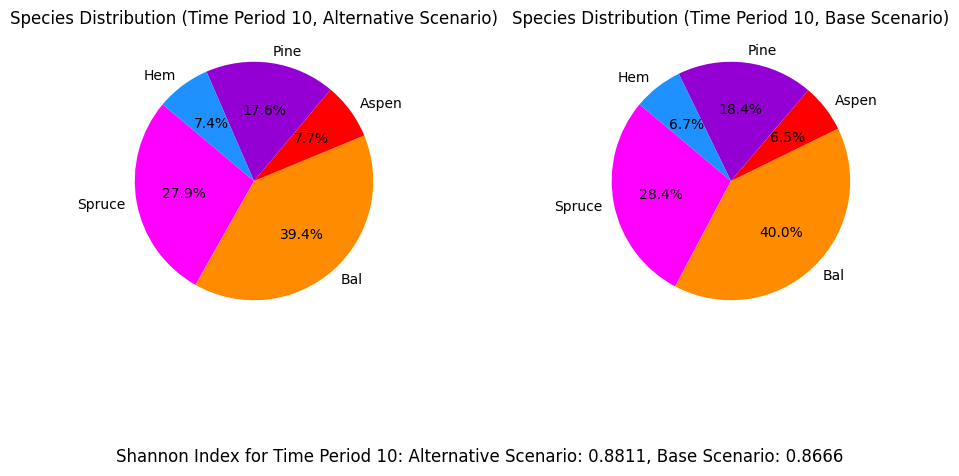

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_em_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_min_em_gldbr_AAC_40%...
running the scenario for the Golden Bear mining site (40%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xce0bbcab
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.13s
Presolved: 1911 rows, 34100 

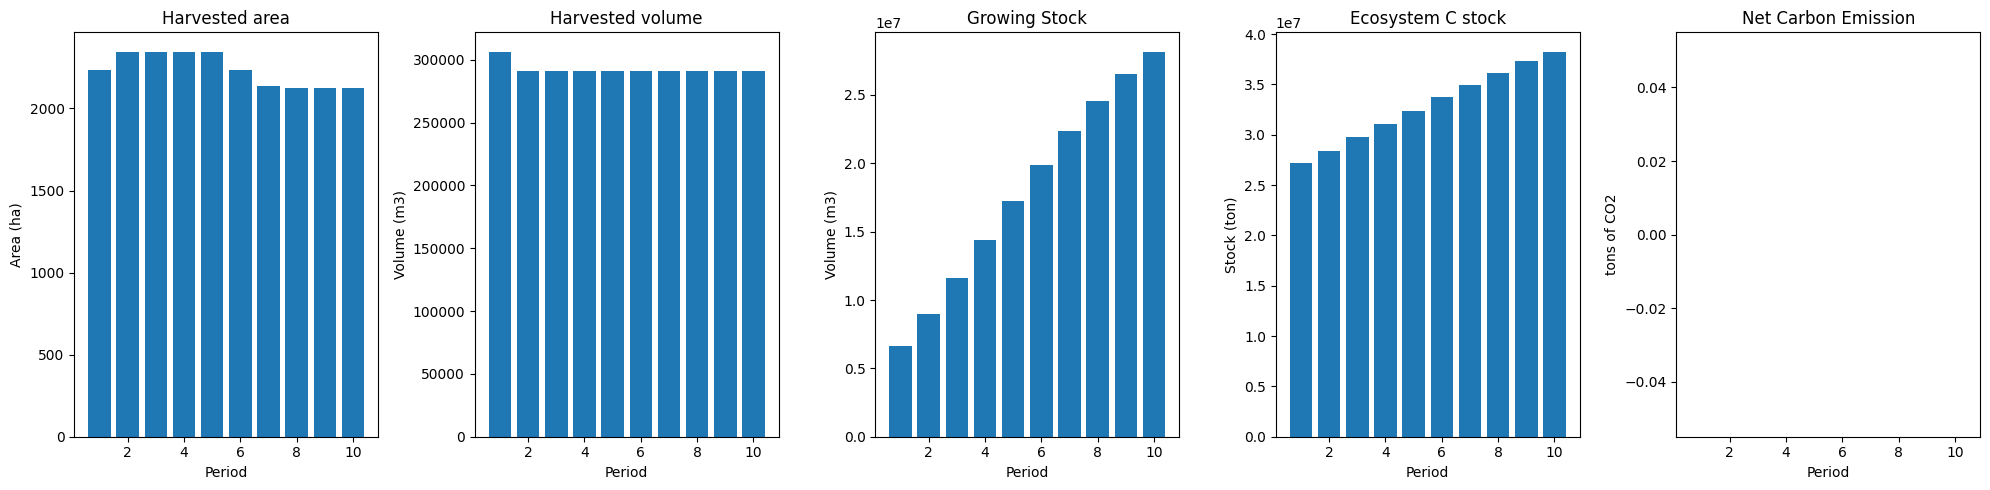

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_40%_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  3093
The economic indicator (the provincial government revenues) is:  105504
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


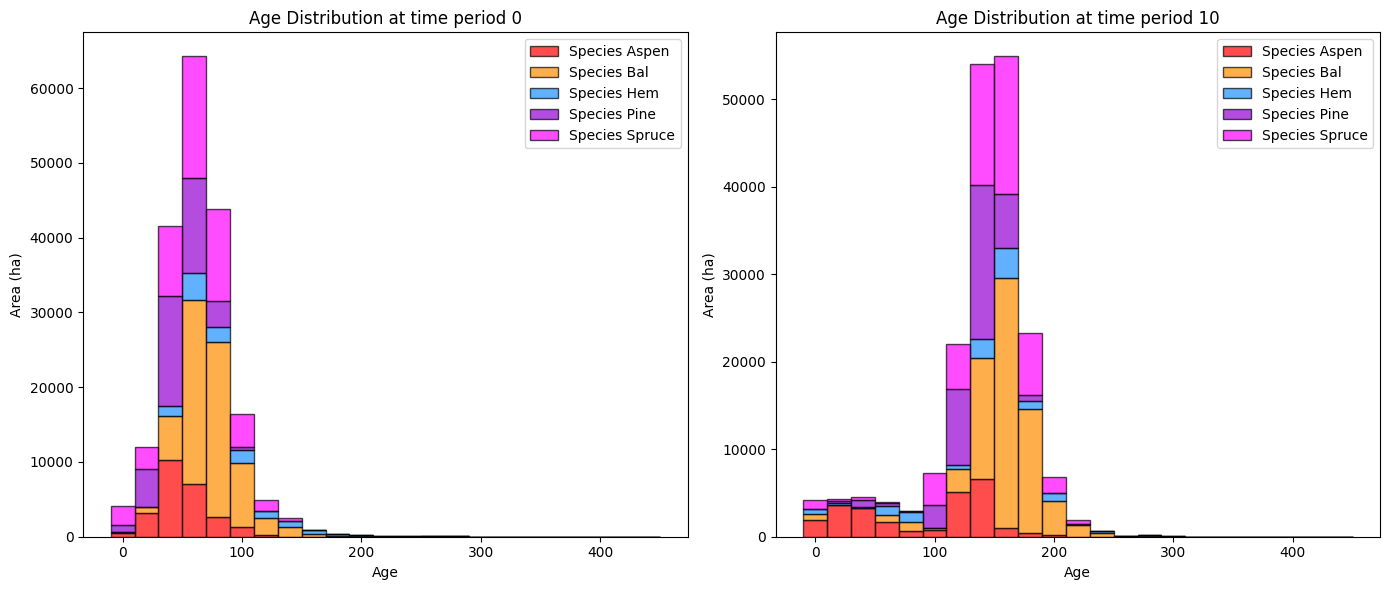

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_40%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   6798.023079   6795.314546
Bal     278.565372  13706.358196  13427.792825
Aspen   273.490478   4537.800197   4264.309719
Pine      0.000000   6709.010128   6709.010128
Hem     419.699331   1443.695286   1023.995955

Old growth has **increased** by 32220.42 hectares from time period 0 to time period 10.


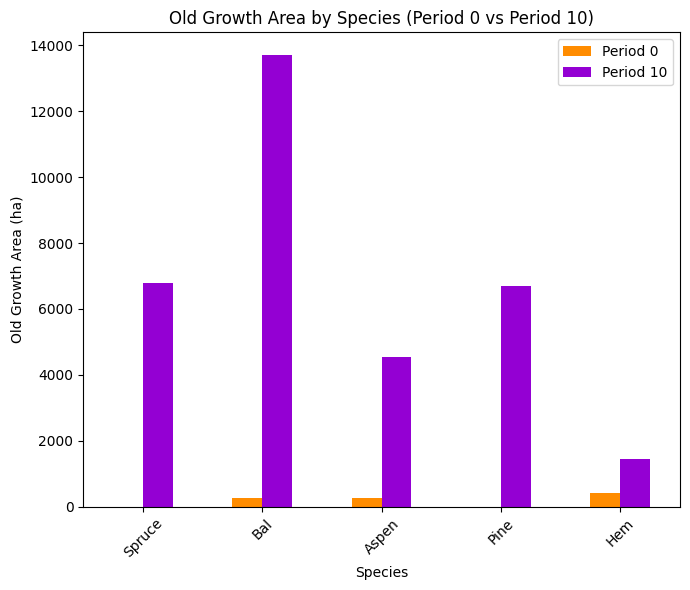

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_40%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8900

Diversity has **decreased** by 5.56% from time 0 to time 10.


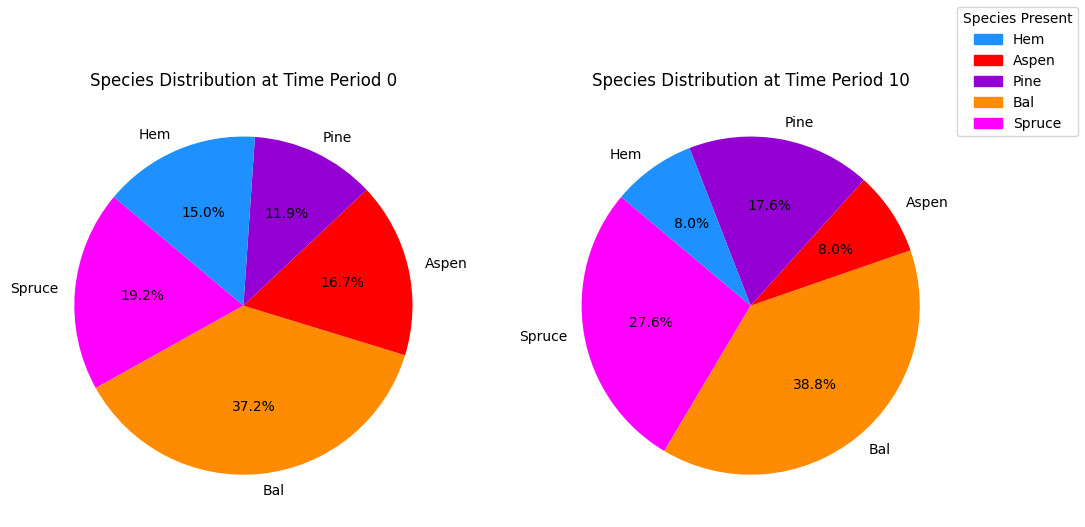

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_40%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x14bd878b
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.18s
Presolved: 1911 rows, 34099 columns, 409165 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time

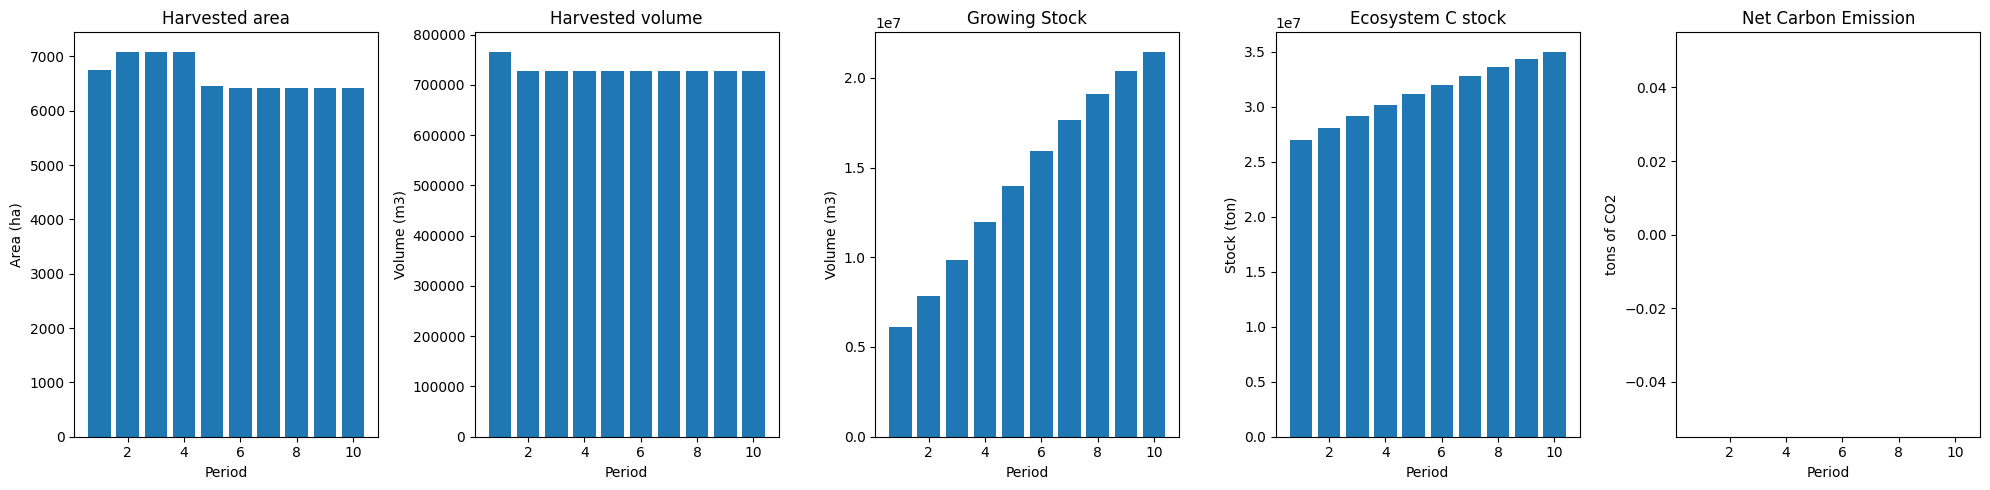

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7734
The economic indicator (the provincial government revenues) is:  263762
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


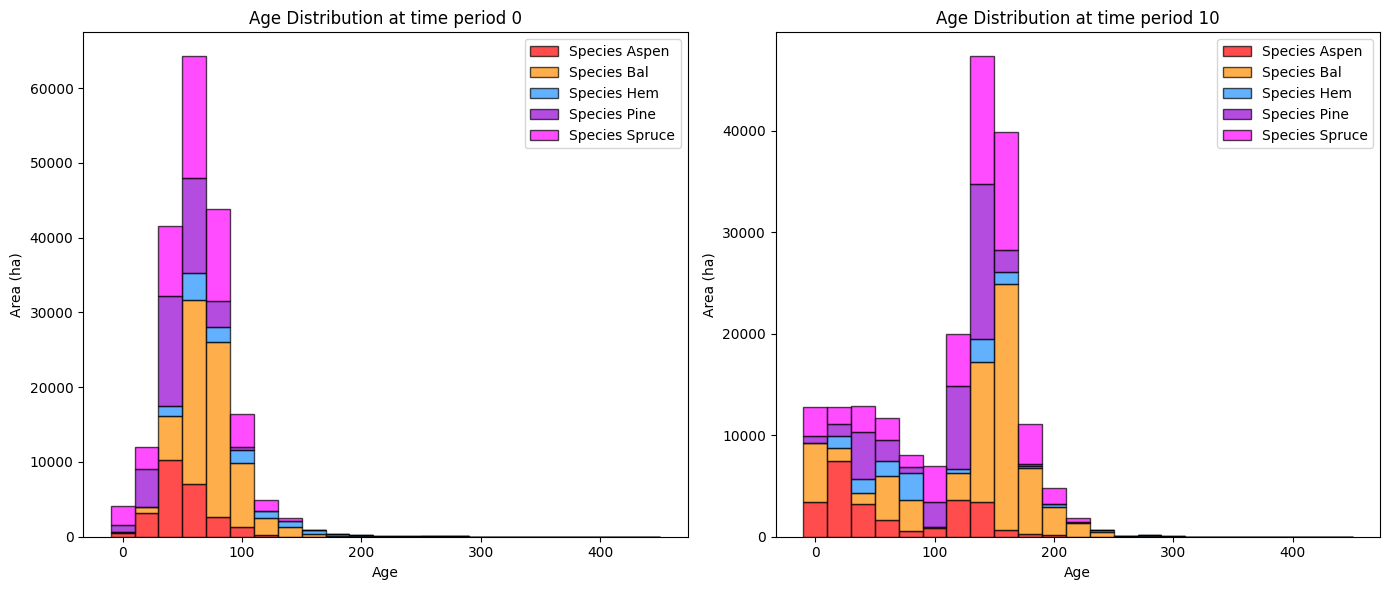

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0           10   Difference
Spruce    2.708533  4178.736448  4176.027915
Bal     278.565372  8822.787379  8544.222007
Aspen   273.490478  2555.924852  2282.434374
Pine      0.000000  3560.331018  3560.331018
Hem     419.699331   708.923341   289.224010

Old growth has **increased** by 18852.24 hectares from time period 0 to time period 10.


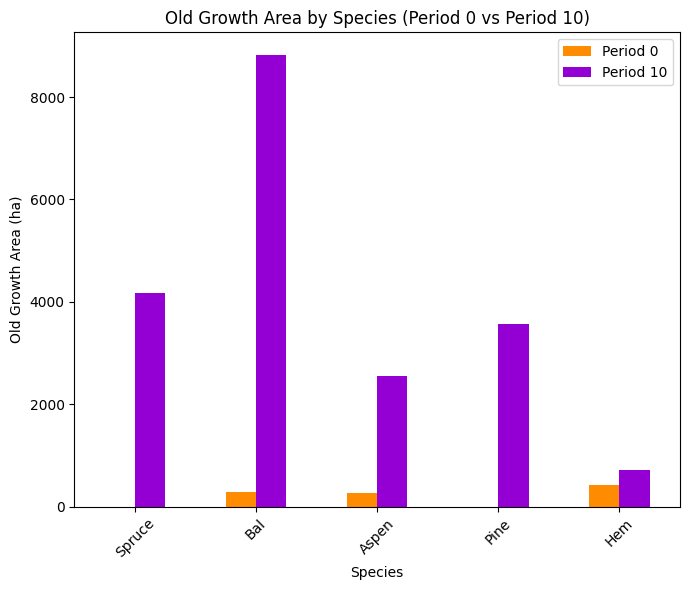

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8666

Diversity has **decreased** by 7.89% from time 0 to time 10.


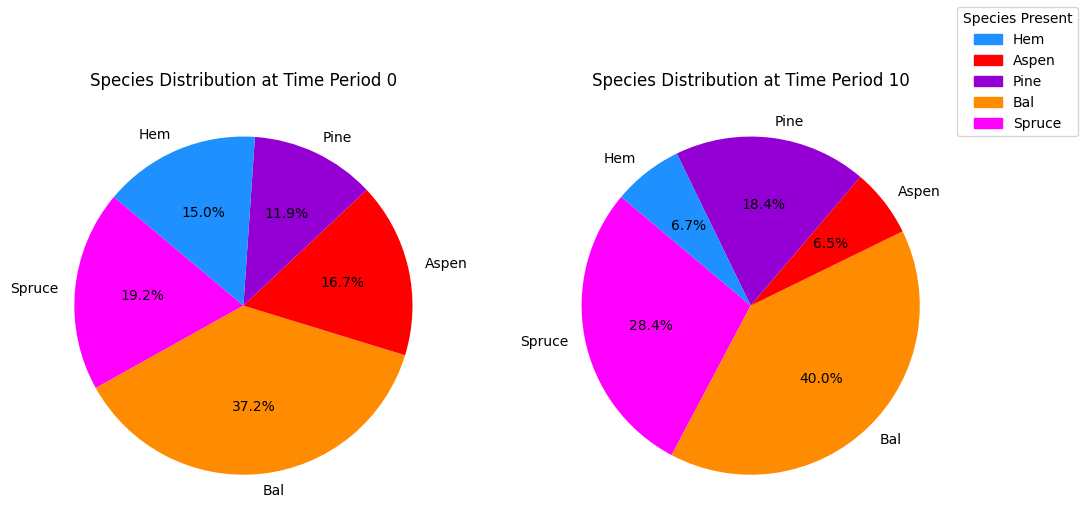

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_species_pie.pdf


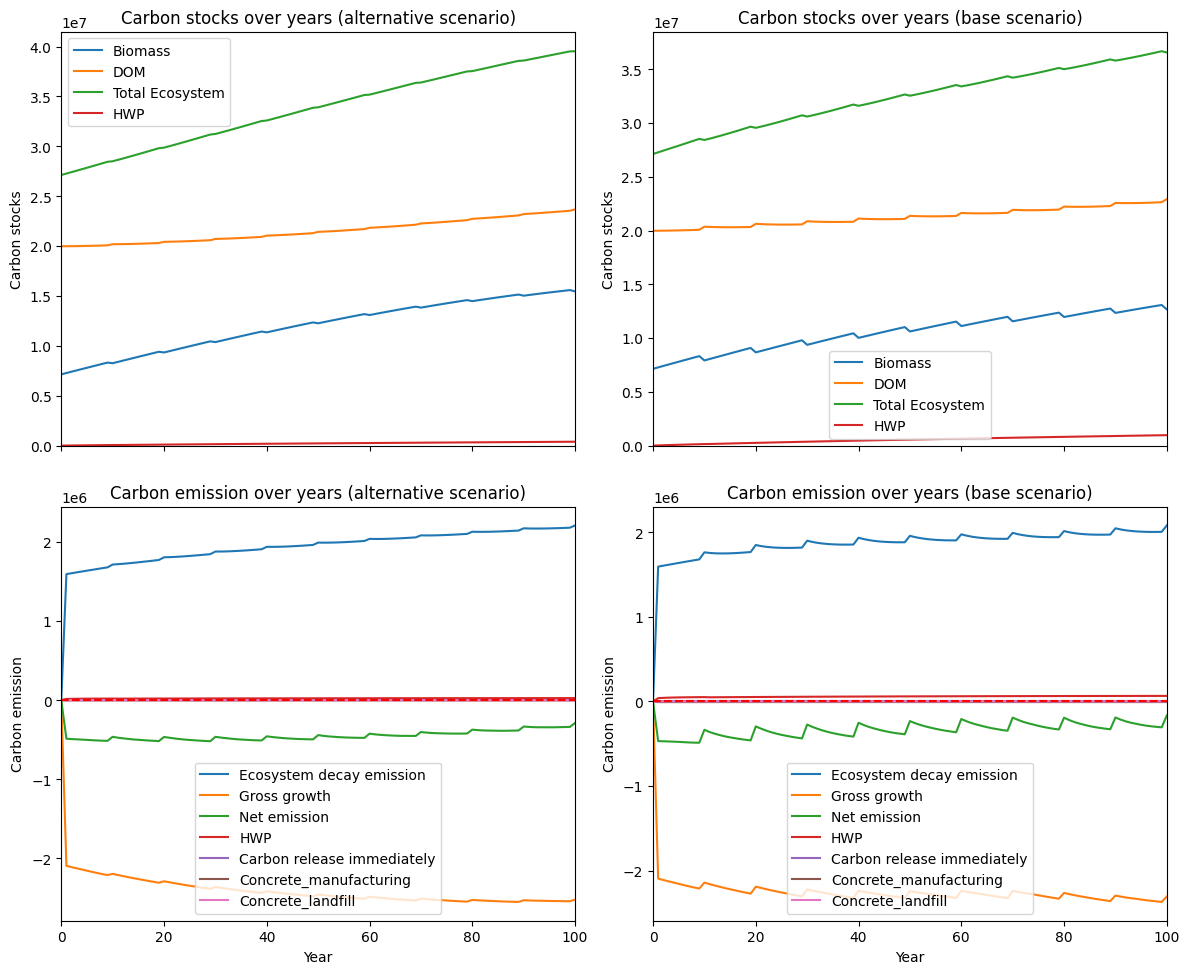

---------------------------------------------------------------------------------------
Net emission difference -11595526.3358133
Net emission base scenario -33380413.402354177
Net emission alternative scenario -44975939.73816747
dollar_per_ton is:  0.8624015599114767
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  2619.286631  2619.286631
Bal     0.0  4883.570817  4883.570817
Aspen   0.0  1981.875345  1981.875345
Pine    0.0  3148.679110  3148.679110
Hem     0.0   734.771946   734.771946

Overall, the old growth area has **increased** by 13368.18 hectares in the alternative scenario compared to the base scenario.


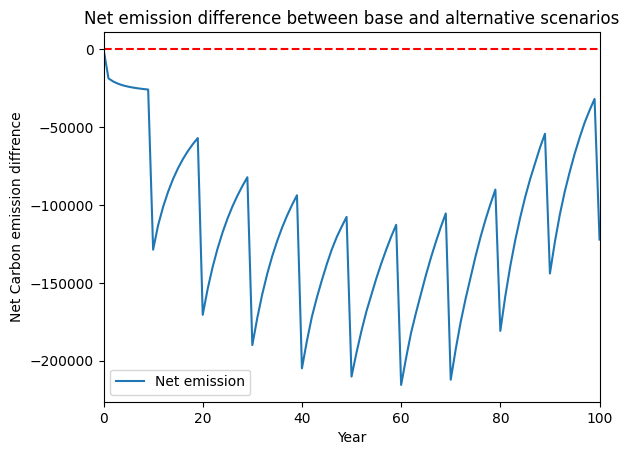

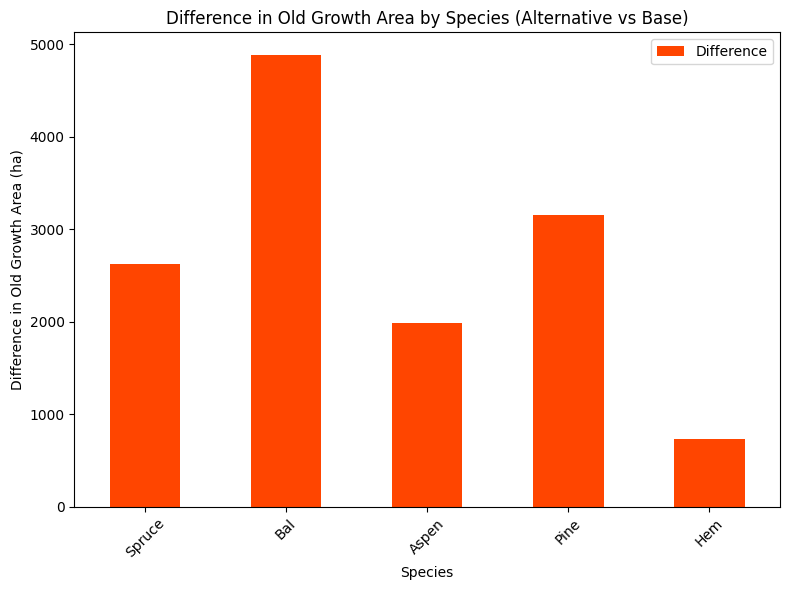

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_kpi_age_difference.pdf


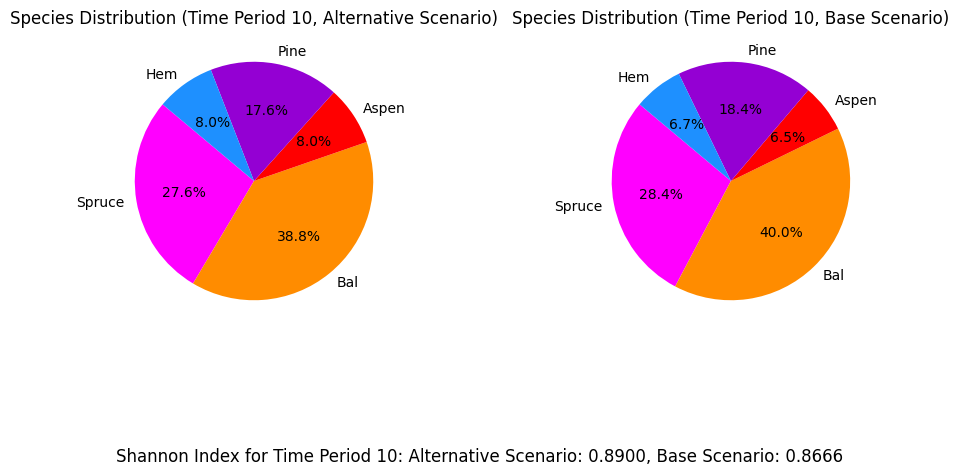

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_em_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_min_em_gldbr_AAC_30%...
running the scenario for the Golden Bear mining site (30%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x961e8bd5
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.14s
Presolved: 1911 rows, 34100 

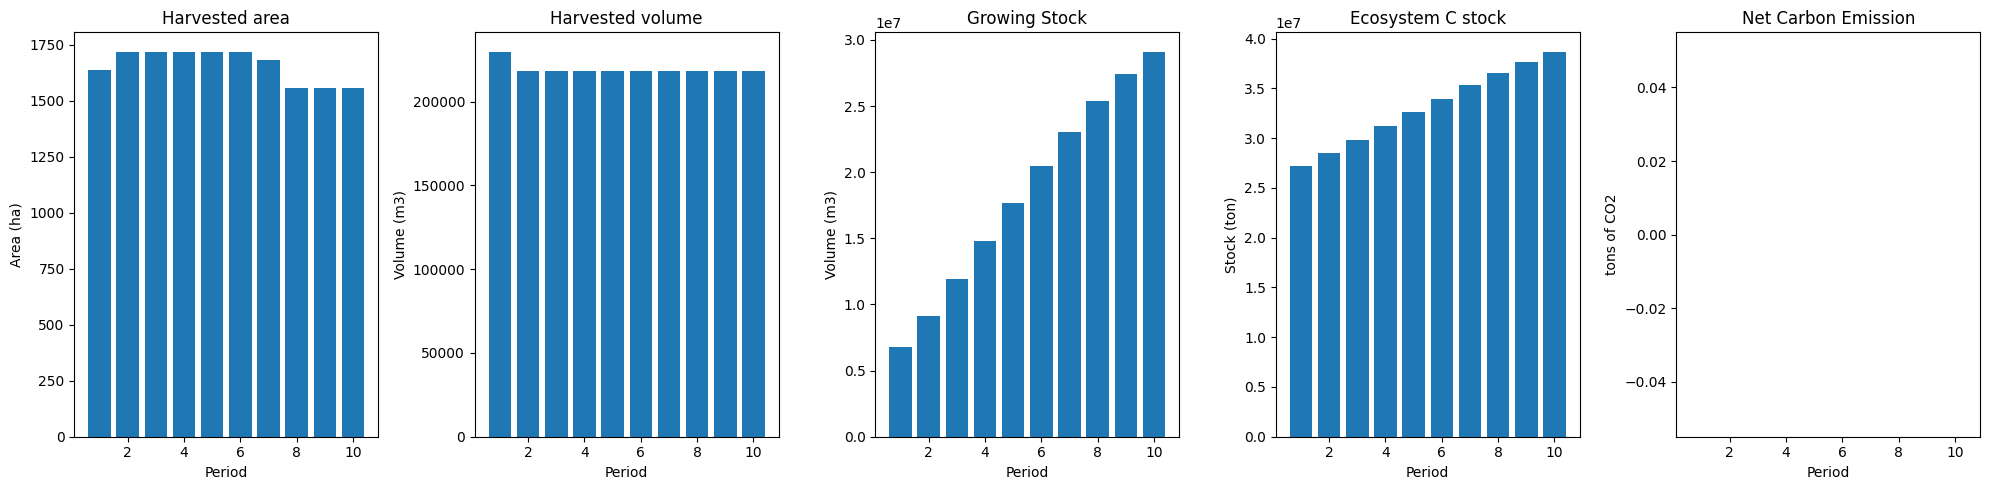

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_30%_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  2320
The economic indicator (the provincial government revenues) is:  79128
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


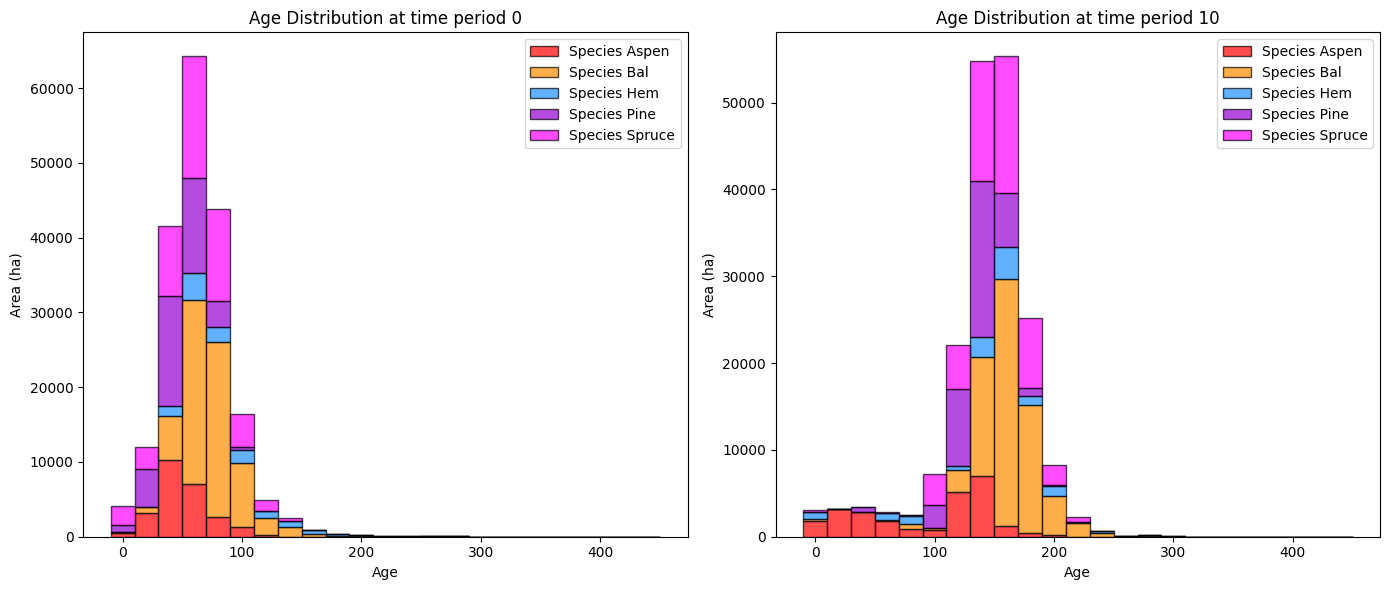

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_30%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   7789.256440   7786.547906
Bal     278.565372  14976.613419  14698.048047
Aspen   273.490478   4948.310129   4674.819651
Pine      0.000000   7134.398603   7134.398603
Hem     419.699331   1757.645556   1337.946225

Old growth has **increased** by 35631.76 hectares from time period 0 to time period 10.


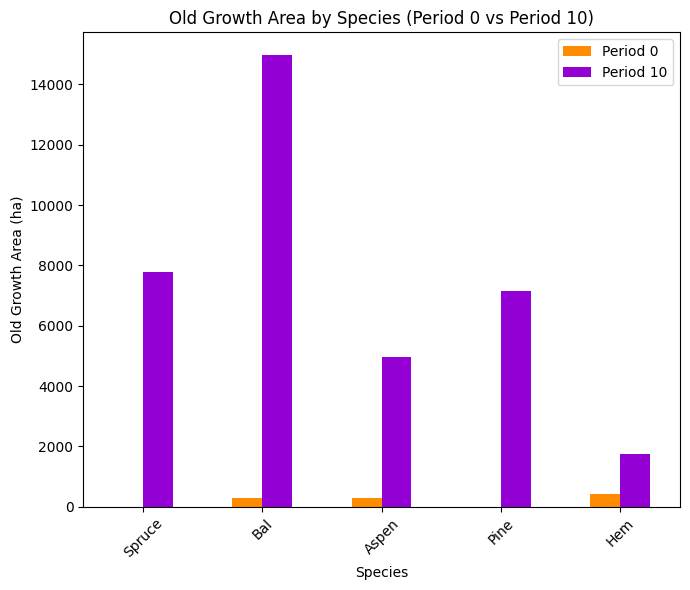

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_30%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8943

Diversity has **decreased** by 5.13% from time 0 to time 10.


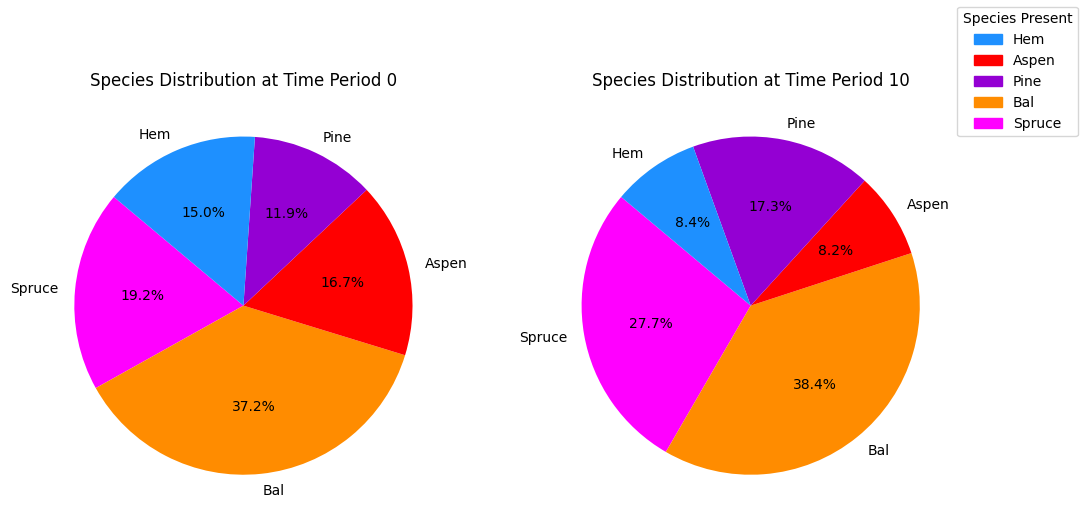

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_30%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site


In [ ]:
Start = time.time()
scenario_names = scenario_options.get(case_study, [])
for scenario_name in scenario_names:
    print(f"Running for {case_study}_{obj_mode}_{scenario_name}...")
    results_scenarios(fm, 
                      clt_percentage, 
                      credibility, 
                      budget_input, 
                      n_steps, 
                      max_harvest, 
                      scenario_name, 
                      displacement_effect, 
                      hwp_pool_effect_value, 
                      release_immediately_value, 
                      case_study, 
                      obj_mode,                   
                      pickle_output_base=False, 
                      pickle_output_alter=False)
print('It took', round((time.time() - Start) / 60, 1), "minutes to run all scenarios.")

Running for goldenbear_min_em_gldbr_AAC_10%...
running the scenario for the Golden Bear mining site (10%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xe7dba2ce
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.16s
Presolved: 1911 rows, 34100 columns, 409166 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.685e+04
 Factor NZ  : 9.050e

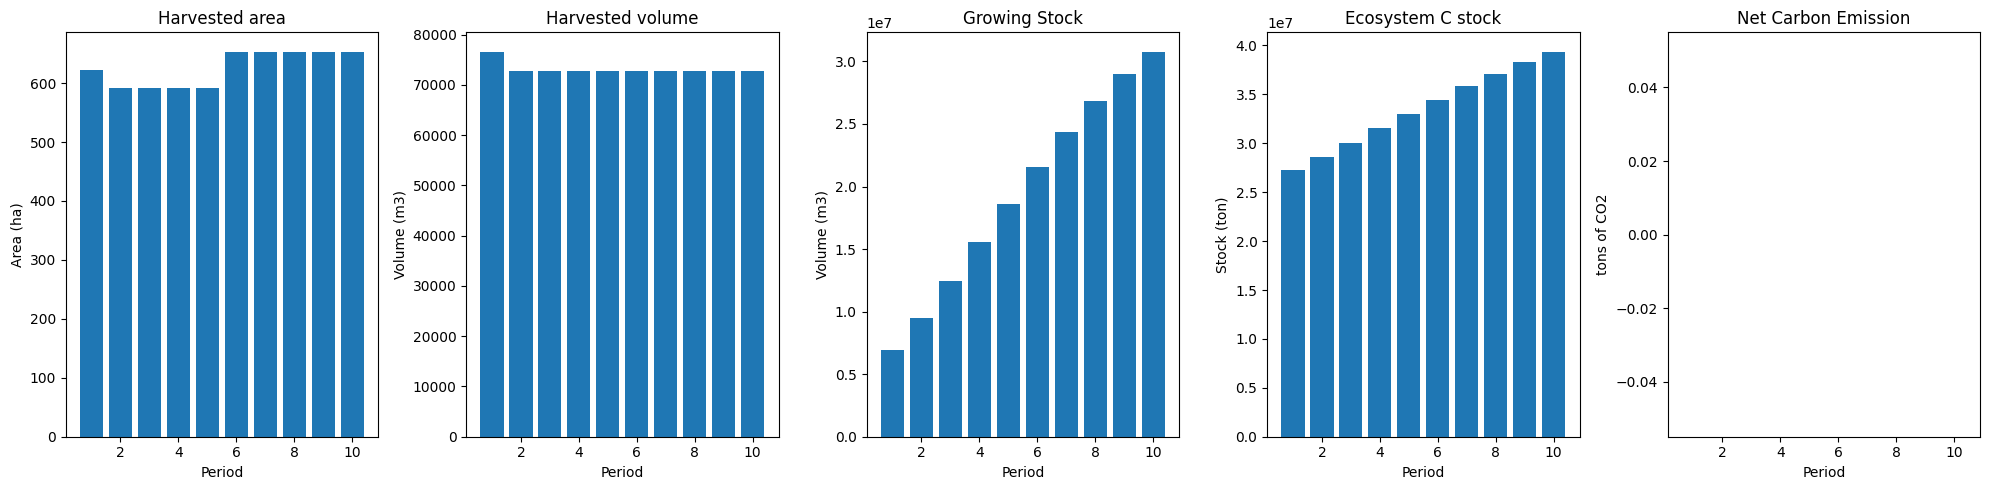

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_10%_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  773
The economic indicator (the provincial government revenues) is:  26376
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


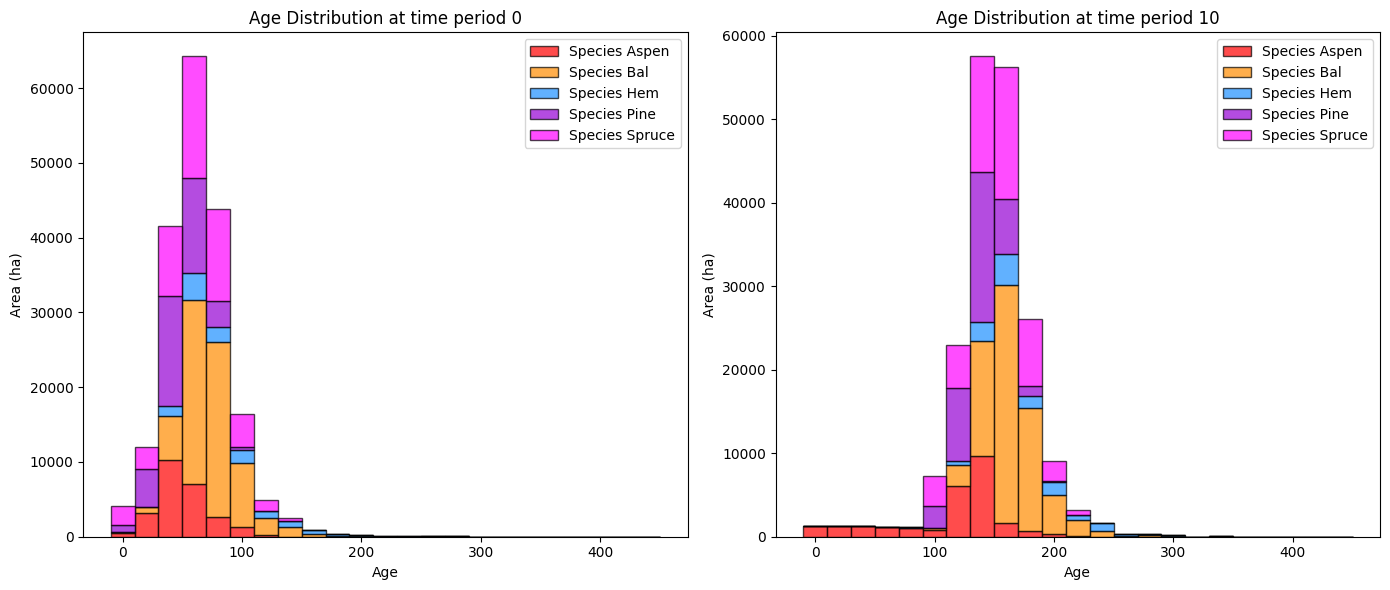

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_10%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   8040.264040   8037.555506
Bal     278.565372  15931.422276  15652.856905
Aspen   273.490478   8204.718630   7931.228152
Pine      0.000000   7631.887200   7631.887200
Hem     419.699331   3776.773615   3357.074285

Old growth has **increased** by 42610.60 hectares from time period 0 to time period 10.


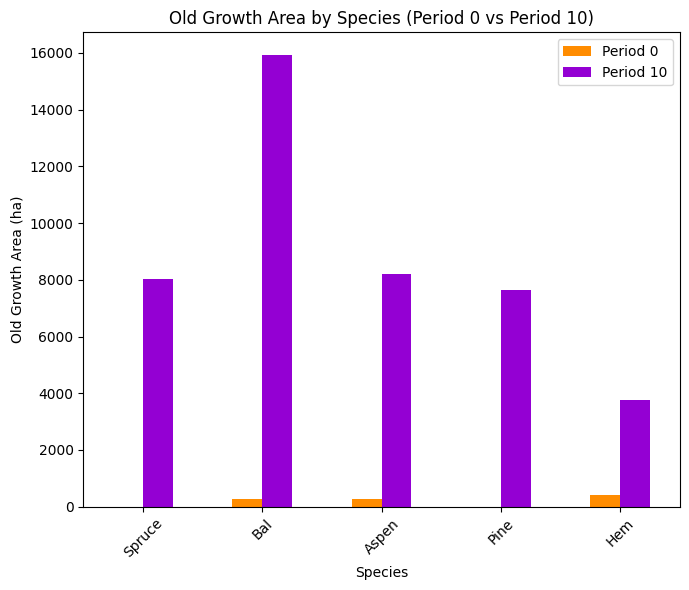

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_10%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.9191

Diversity has **decreased** by 2.64% from time 0 to time 10.


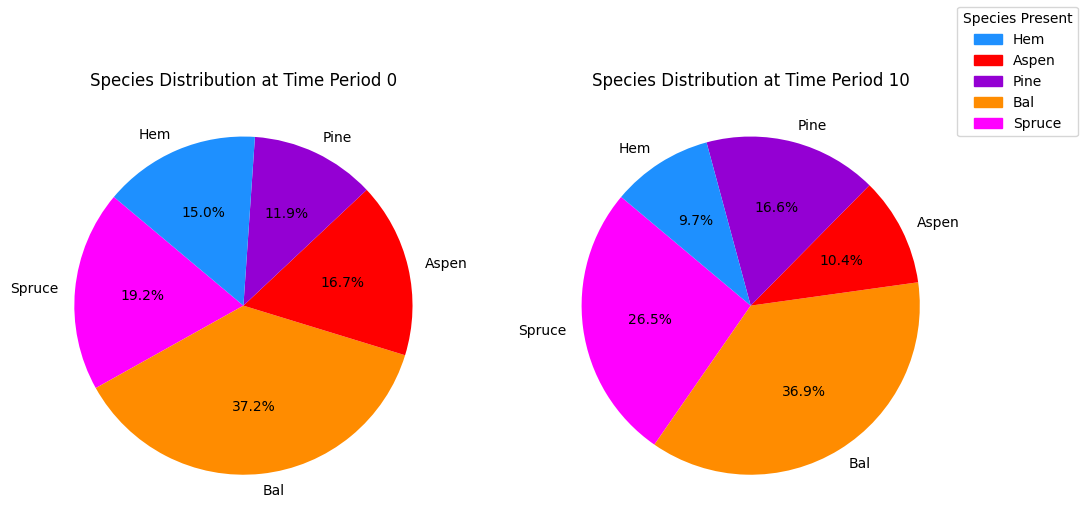

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_em_gldbr_AAC_10%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x14bd878b
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.13s
Presolved: 1911 rows, 34099 columns, 409165 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time

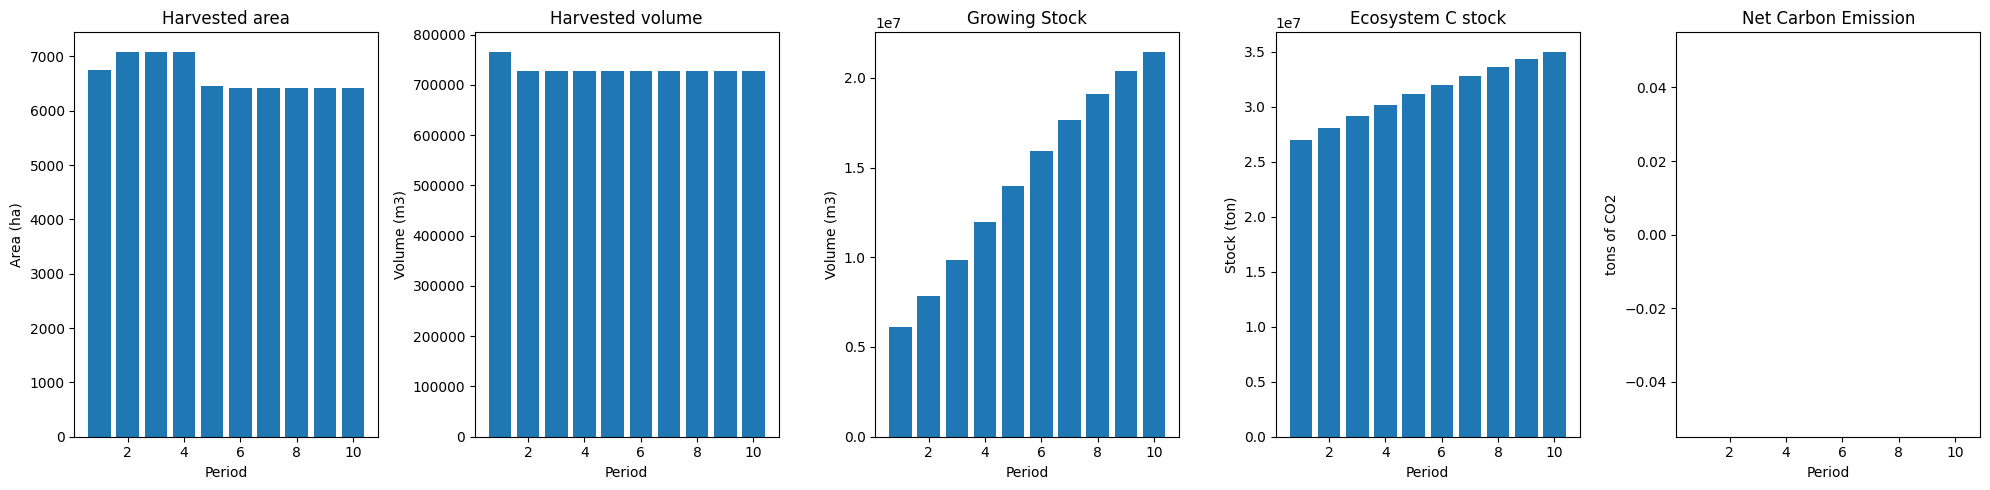

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7734
The economic indicator (the provincial government revenues) is:  263762
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


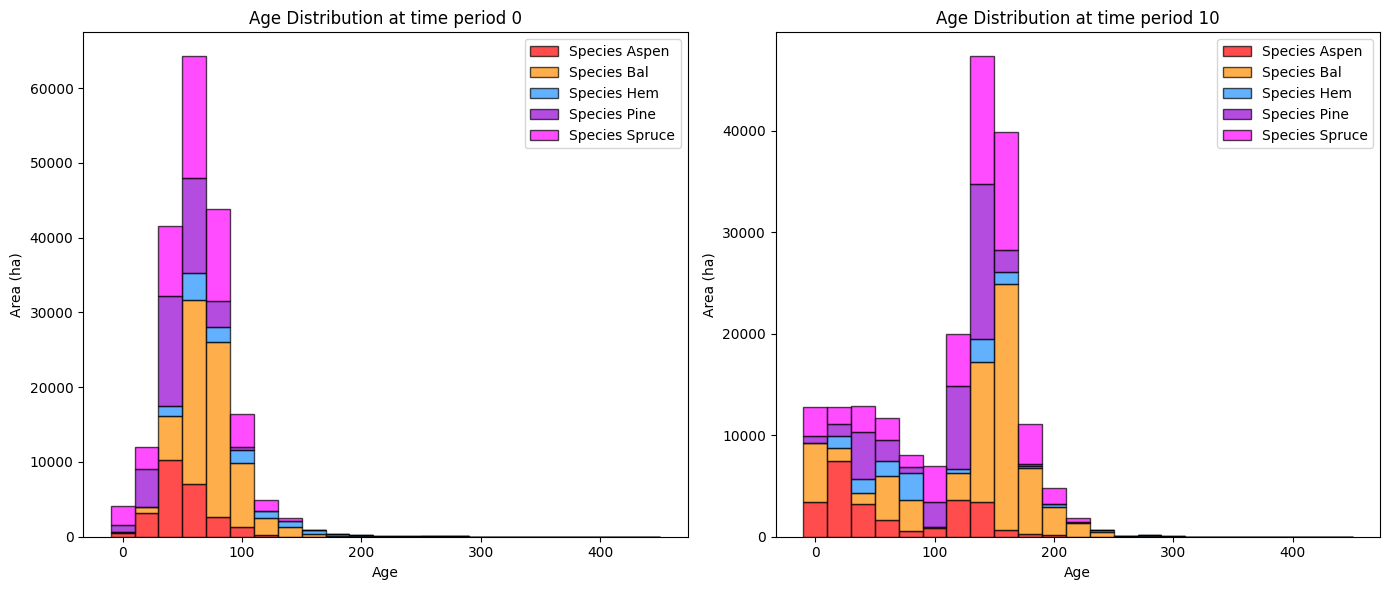

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0           10   Difference
Spruce    2.708533  4178.736448  4176.027915
Bal     278.565372  8822.787379  8544.222007
Aspen   273.490478  2555.924852  2282.434374
Pine      0.000000  3560.331018  3560.331018
Hem     419.699331   708.923341   289.224010

Old growth has **increased** by 18852.24 hectares from time period 0 to time period 10.


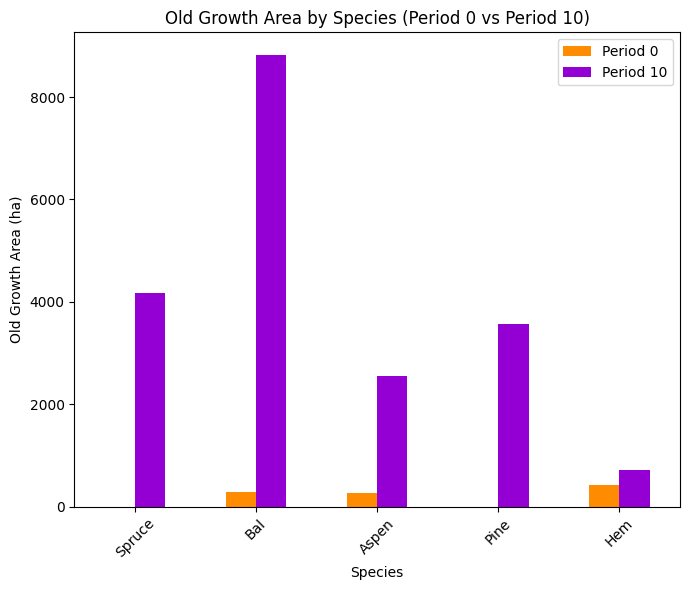

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8666

Diversity has **decreased** by 7.89% from time 0 to time 10.


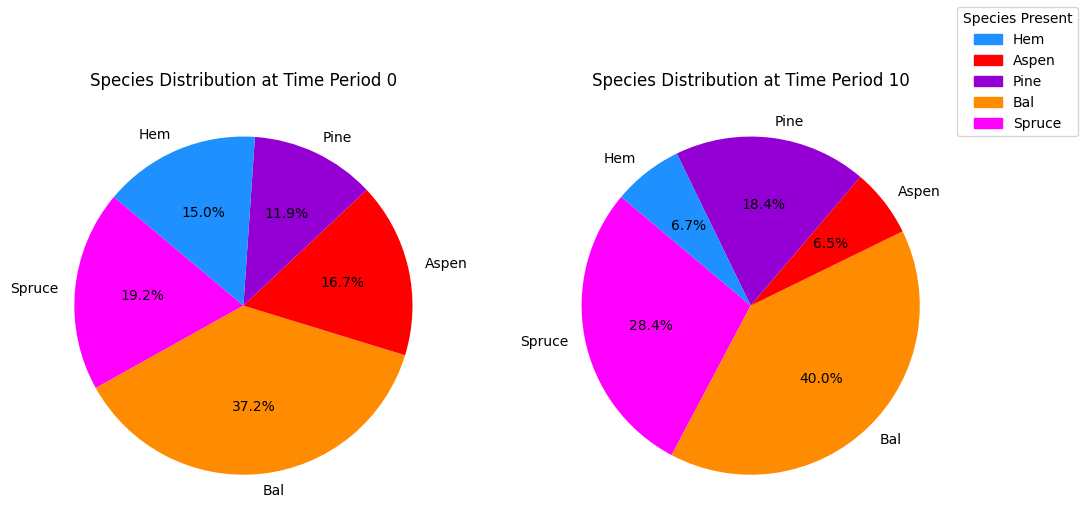

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_em_bau_gldbr_species_pie.pdf


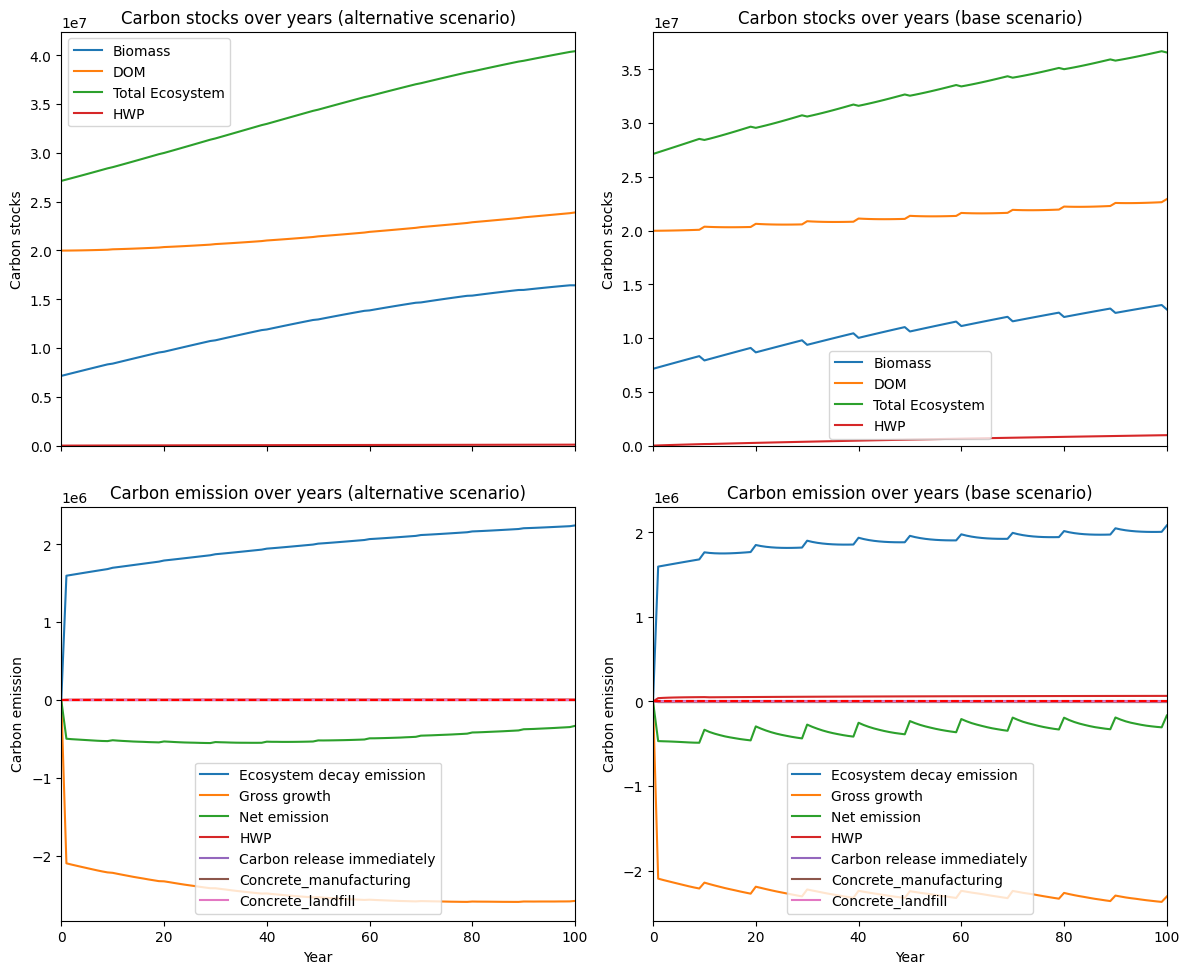

---------------------------------------------------------------------------------------
Net emission difference -15269511.338563954
Net emission base scenario -33380413.402354177
Net emission alternative scenario -48649924.74091814
dollar_per_ton is:  0.6548998051263418
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  3861.527592  3861.527592
Bal     0.0  7108.634898  7108.634898
Aspen   0.0  5648.793777  5648.793777
Pine    0.0  4071.556182  4071.556182
Hem     0.0  3067.850275  3067.850275

Overall, the old growth area has **increased** by 23758.36 hectares in the alternative scenario compared to the base scenario.


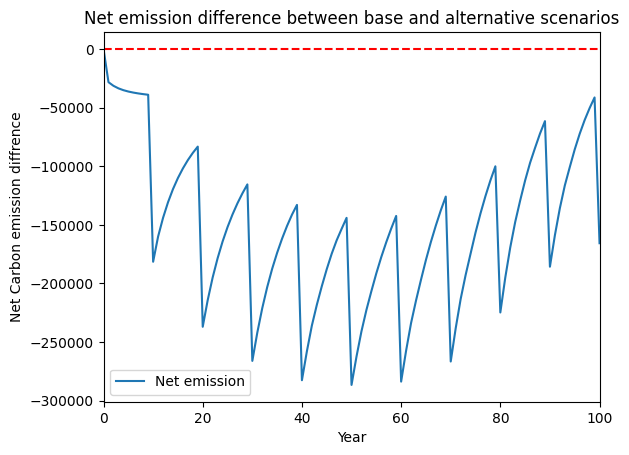

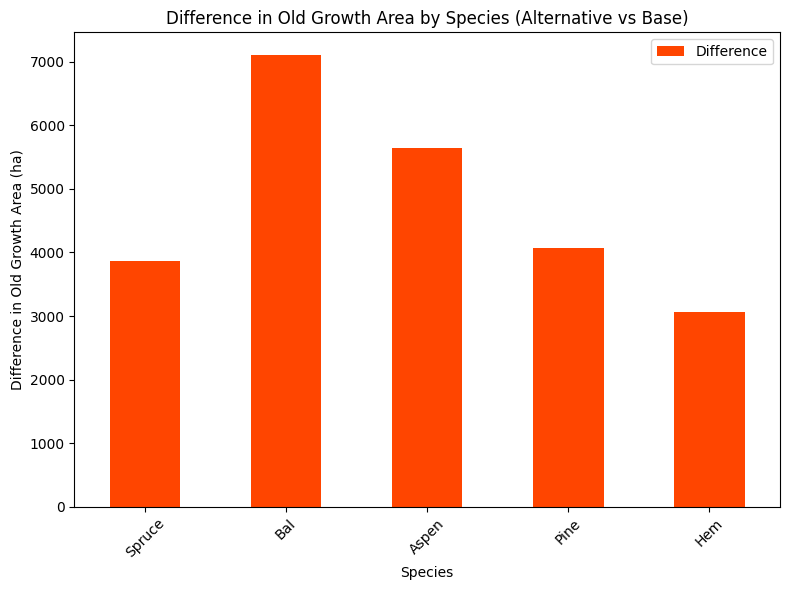

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_em_kpi_age_difference.pdf


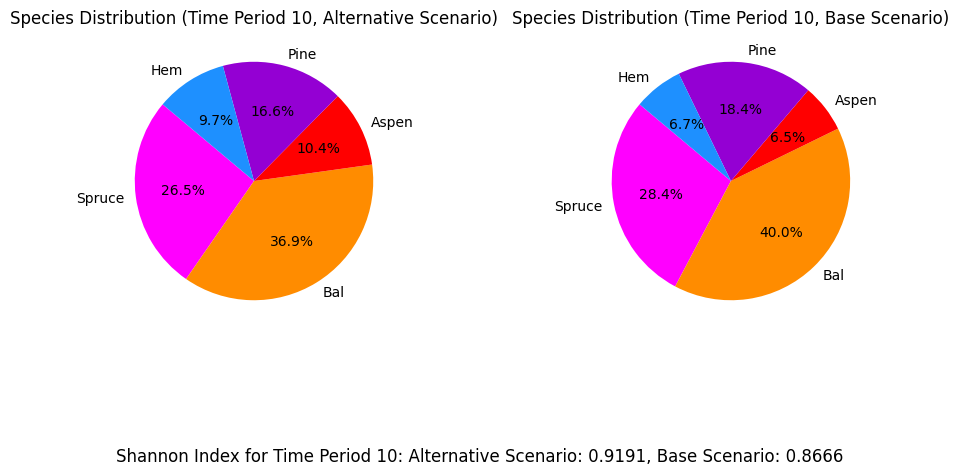

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_em_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
It took 8.1 minutes to run all scenarios.


In [14]:
Start = time.time()
scenario_names = ['gldbr_AAC_10%']
for scenario_name in scenario_names:
    print(f"Running for {case_study}_{obj_mode}_{scenario_name}...")
    results_scenarios(fm, 
                      clt_percentage, 
                      credibility, 
                      budget_input, 
                      n_steps, 
                      max_harvest, 
                      scenario_name, 
                      displacement_effect, 
                      hwp_pool_effect_value, 
                      release_immediately_value, 
                      case_study, 
                      obj_mode,                   
                      pickle_output_base=False, 
                      pickle_output_alter=False)
print('It took', round((time.time() - Start) / 60, 1), "minutes to run all scenarios.")

In [ ]:
print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")